In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt



In [21]:
#1. Camera Calibration 
def calibrateMyCamera(filePath,cornersNum,imgSize):
    import glob
    calibrationList=[]
    objPoints=[]
    imgPoints=[]
    objp=np.zeros((cornersNum[1]*cornersNum[0],3),np.float32)
    objp[:,:2]=np.mgrid[0:cornersNum[0],0:cornersNum[1]].T.reshape(-1,2)
    filePath=filePath+'*'
    images=glob.glob(filePath)
    for item in images:
        img=cv2.imread(item)
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        ret, corners=cv2.findChessboardCorners(gray,cornersNum,None)
        
        if ret==True:
            objPoints.append(objp)
            imgPoints.append(corners)
    global mtx
    global dist
    ret, mtx, dist, rvecs, tvecs=cv2.calibrateCamera(objPoints,imgPoints,imgSize,None,None)
    calibrationList.append(ret)
    calibrationList.append(mtx)
    calibrationList.append(dist)
    calibrationList.append(rvecs)
    calibrationList.append(tvecs)
    
    return calibrationList

In [22]:
#2. Image undistortion
def undistortMyImage(img,mtx,dist):
    return cv2.undistort(img,mtx,dist,None,mtx)

In [23]:
#3. Color Transform and gradient to make a threshold binary image
def abs_sobel_thresh(gray_img,orient='x',sobel_kernel=3,thresh=(0,255)):
    if orient=='x':
        sobel=cv2.Sobel(gray_img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    elif orient=='y':
        sobel=cv2.Sobel(gray_img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    else:
        print("ERROR")
        return
    sobel=abs(sobel)
    scale_factor=np.max(sobel)/255
    scaled_sobel=np.uint8(sobel/scale_factor)
    binary_img=np.zeros_like(scaled_sobel)
    binary_img[(scaled_sobel>thresh[0])&(scaled_sobel<thresh[1])]=1
    return binary_img

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    imgHLS=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    gray=imgHLS[:,:,2]
    binary_output=np.zeros_like(gray)
    # 3) Return a binary image of threshold result
    binary_output[(gray>thresh[0]) & (gray<=thresh[1])]=1
    #binary_output = np.copy(img) # placeholder line
    return binary_output

def getBinaryImage(img,g_thresh=(0,255),s_thresh=(0,255)):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobel_x=abs_sobel_thresh(gray,orient='x',sobel_kernel=3,thresh=g_thresh)
    s_channel=hls_select(img,s_thresh)
    #color_combined=np.dstack(np.zeros_like(gray),gray,s_channel)
    #plt.imshow(color_combined)
    binary=np.zeros_like(gray)
    binary[(sobel_x==1)|(s_channel==1)]=1
    return binary

In [24]:
#4. Prespective Transform
def getBirdEye(img,src,dst):
    imgSize=(img.shape[1],img.shape[0])
    global M
    global Minv
    M=cv2.getPerspectiveTransform(src,dst)
    Minv=cv2.getPerspectiveTransform(dst,src)
    
    warped=cv2.warpPerspective(img,M,imgSize,flags=cv2.INTER_LINEAR)
    
    return warped

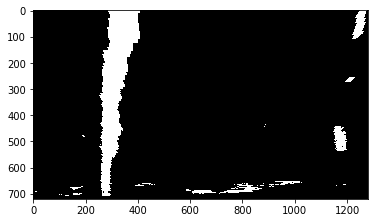

In [60]:
h,w=binary.shape[:2]
src=np.float32([[w,h-10],
                [0,h-10],
                [546,460],
                [732,460]])
dst=np.float32([[w,h],
                    [0,h],
                    [0,0],
                    [w,0]])
bird_img=getBirdEye(binary,src,dst)
plt.imshow(bird_img,cmap='gray')
plt.imsave('./test_images/bird_eye.png',bird_img,cmap='gray')

In [25]:
#5. Find lane lines and fit polynomial
def poly_fit(birdEyeImg):
    #1. Determine the left base and the right base of the lane lines
    #1.1. Take the histogram of the bottom half of the img to determine where are your peaks
    histogram=np.sum(birdEyeImg[birdEyeImg.shape[0]//2:,:],axis=0)
    #plt.plot(histogram)
    #1.2 Determine the midpoint of the img x axis img.shape[1]/2
    midpoint=np.int(birdEyeImg.shape[1]/2)
    #1.3 Determine the left and the right base of the lane lines
    left_base=np.argmax(histogram[:midpoint])
    right_base=np.argmax(histogram[midpoint:])+midpoint
    #print("left_base is {}".format(left_base))
    #print("right_base is {}".format(right_base))
    
    #2. Make an output img to put all the results in it
    out=np.dstack((birdEyeImg,birdEyeImg,birdEyeImg))*255
    
    #3.Parameters for the sliding windows
    #3.1. number of windows
    nwindows=9
    #3.2. hight of each window = (hight of the imag/number of windows)
    window_hight=np.int(birdEyeImg.shape[0]/nwindows)
    #3.3. the width of each window (margin) +/- 
    margin=100
    #3.4. Minimum number of pixel to accept it as a window
    minpix=50
    
    #4. get the coordinates of all non zero pixels in the image
    #4.1. get the non zeros points as a list of two lists [y_coordinates,x_coordinates]
    global nonzero
    nonzero=birdEyeImg.nonzero()
    #4.2. get the y coordinates of these points
    global nonzero_y
    nonzero_y=np.array(nonzero[0])
    global nonzero_x
    nonzero_x=np.array(nonzero[1])
    
    #5. make the current base equal to the previous base
    left_current=left_base
    right_current=right_base
    
    
    
    #6. empty lists to get the indices of the lanes
    global left_lane_inds
    left_lane_inds=[]
    global right_lane_inds
    right_lane_inds=[]
    
    #7.step through the windows one by one

    
    for window in range(nwindows):
        
        #7.1. identify the window boundaries by using the window's upper left point and lowe right point
        # each time we need to drow two windows around the two lanes, these two windows have the same
        # two y values (for lower and upper points) and four different x points 
        win_y_low=birdEyeImg.shape[0]-(window+1)*window_hight #low because the index is y decreased
        win_y_high=birdEyeImg.shape[0]- window*window_hight
        win_x_left_low=left_current-margin
        win_x_left_high=left_current+margin
        win_x_right_low=right_current-margin
        win_x_right_high=right_current+margin
        
        #7.2. Using the above parameters of the four points (2 for each line), we drow a rectangular window
        cv2.rectangle(out,(win_x_left_low,win_y_low),(win_x_left_high,win_y_high),(0,0,255),2)
        cv2.rectangle(out,(win_x_right_low,win_y_low),(win_x_right_high,win_y_high),(0,0,255),2)
        
        #7.3. Determine the indices of the nonzero pixels inside each window
        good_left_inds=((nonzero_y>=win_y_low)&(nonzero_y<win_y_high)&(nonzero_x>=win_x_left_low)&(nonzero_x<win_x_left_high)).nonzero()[0]
        good_right_inds=((nonzero_y>=win_y_low)&(nonzero_y<win_y_high)&(nonzero_x>=win_x_right_low)&(nonzero_x<win_x_right_high)).nonzero()[0]
        
        #7.4. Append the indices in indices' lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #7.5. Check if the number of nonzero pixels more than the minimum number, if yes, so we recenter the window to be around their mean
        if len(good_left_inds)>minpix:
            left_current=np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds)>minpix:
            right_current=np.int(np.mean(nonzero_x[good_right_inds]))
            
    #7.6. Concatenate the arrays of the indices
    left_lane_inds=np.concatenate(left_lane_inds)
    right_lane_inds=np.concatenate(right_lane_inds)

    #7.7. Extract left and right pixels (points) to fit a polynomial
    left_x=nonzero_x[left_lane_inds]
    left_y=nonzero_y[left_lane_inds]
    right_x=nonzero_x[right_lane_inds]
    right_y=nonzero_y[right_lane_inds]

    #7.8. fit the polynomial for the two lines
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_m=np.polyfit(left_y*ym_per_pix,left_x*xm_per_pix,2)
    right_fit_m=np.polyfit(right_y*ym_per_pix,right_x*xm_per_pix,2)
    left_fit=np.polyfit(left_y,left_x,2)
    right_fit=np.polyfit(right_y,right_x,2)
    #global left_fit_list
    left_fit_list=[left_fit,left_fit_m]
    #global right_fit_list
    right_fit_list=[right_fit,right_fit_m]
    
    #return out,left_fit,right_fit,nonzero_y,nonzero_x,left_lane_inds,right_lane_inds
    return out,left_fit_list,right_fit_list

In [61]:
out, left_fit_list,right_fit_list=poly_fit(bird_img)
left_fit=left_fit_list[0]
right_fit=right_fit_list[0]

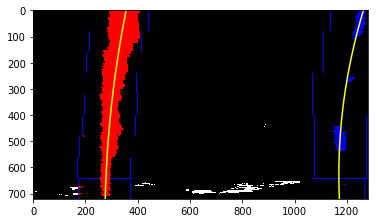

In [62]:
# Generate x and y values for plotting
ploty = np.linspace(0, bird_img.shape[0]-1, bird_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
out[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]
plt.imshow(out)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imsave('./test_images/poly_fit.png',cv2.cvtColor(out,cv2.COLOR_BGR2RGB))

In [30]:
#6. Curvature Radius
def getCurvature(img,left_fit,right_fit):
    y_eval = np.max(img.shape[0])/2
    y_eval= y_eval*30/720
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad,right_curverad

In [31]:
#7. get two lane lines by polynomial fitting
def getlane(out,left_fit,right_fit):
    ploty = np.linspace(0, out.shape[0]-1, num=out.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    out[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]
    
    warp_zero = np.zeros_like(out[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # offset calculation
    line_width=pts_right[0,-1,0]-pts_left[0,-1,0]
    from_borders=(img.shape[1]-line_width)/2
    offset=(img.shape[1]-pts_right[0,-1,0])-from_borders
    # from pixel to m
    offset=offset*3.7/700
    return result, offset #cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
    
    

In [45]:
#calibrationList=calibrateMyCamera('./camera_cal/',(9,6),(1280,720))
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [41]:
#line=Line()
global check
check=1

def process(image):
    global FIRST_FRAME

    #check=FIRST_FRAME
    global img
    img=image
    img=undistortMyImage(img,mtx,dist)
    binary=getBinaryImage(img,g_thresh=(100,255),s_thresh=(70,255))
    #plt.imshow(binary,cmap='gray')
    #plt.show()
    h,w=binary.shape[:2]
    
    src=np.float32([[w,h-10],
                [0,h-10],
                [546,460],
                [732,460]])
    dst=np.float32([[w,h],
                    [0,h],
                    [0,0],
                    [w,0]])
    warped_img=getBirdEye(binary,src,dst)
    if check==1:
        out,left_fit_list,right_fit_list=poly_fit(warped_img)
        global left_fit_m,right_fit_m
        left_fit_m=left_fit_list[1]
        right_fit_m=right_fit_list[1]
        global left_fit_x,right_fit_x
        left_fit_x=left_fit_list[0]
        right_fit_x=right_fit_list[0]
        left_curv, right_curv=getCurvature(out,left_fit_m,right_fit_m)
        left_curv=left_curv
        right_curv=right_curv
        global check
        print (left_fit_x)
        print (right_fit_x)
        global left_fit_x_temp,right_fit_x_temp, left_fit_x_temp_m, right_fit_x_temp_m
        left_fit_x_temp=left_fit_x
        right_fit_x_temp=right_fit_x
        left_fit_x_temp_m=left_fit_m
        right_fit_x_temp_m=right_fit_m
        check=0
    else:
        out,left_fit_list,right_fit_list=poly_fit(warped_img)

        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit_x[0]*(nonzeroy**2) + left_fit_x[1]*nonzeroy + left_fit_x[2] - margin)) & (nonzerox < (left_fit_x[0]*(nonzeroy**2) + left_fit_x[1]*nonzeroy + left_fit_x[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit_x[0]*(nonzeroy**2) + right_fit_x[1]*nonzeroy + right_fit_x[2] - margin)) & (nonzerox < (right_fit_x[0]*(nonzeroy**2) + right_fit_x[1]*nonzeroy + right_fit_x[2] + margin)))
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        global left_fit_x,right_fit_x
        left_fit_x = np.polyfit(lefty, leftx, 2)
        right_fit_x = np.polyfit(righty, rightx, 2)
        if (np.absolute(np.absolute(left_fit_x[0])-np.absolute(left_fit_x_temp[0]))>0.0001) | (np.absolute(np.absolute(right_fit_x[0])-np.absolute(right_fit_x_temp[0]))>0.0001):
            global left_fit_x,right_fit_x,left_fit_m,right_fit_m
            left_fit_x=left_fit_x_temp
            right_fit_x=right_fit_x_temp
            left_fit_m=left_fit_x_temp_m
            right_fit_m=right_fit_x_temp_m
            #ym_per_pix = 30/720 # meters per pixel in y dimension
            #xm_per_pix = 3.7/700 # meters per pixel in x dimension
            #global left_fit_m,right_fit_m
            #left_fit_m=np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
            #right_fit_m=np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)

            
        global left_fit_x_temp,right_fit_x_temp
        left_fit_x_temp=left_fit_x
        right_fit_x_temp=right_fit_x
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        global left_fit_m,right_fit_m,left_fit_x_temp_m,right_fit_x_temp_m
        left_fit_m=np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
        right_fit_m=np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
        left_fit_x_temp_m=left_fit_m
        right_fit_x_temp_m=right_fit_m
        left_curv, right_curv=getCurvature(warped_img,left_fit_m,right_fit_m)
        left_curv=left_curv
        right_curv=right_curv
        print (left_fit_x)
        print (right_fit_x)
    
    
    result,offset=getlane(out,left_fit_x,right_fit_x)
    #if np.absolute(left_curv)>2:
        #cv2.putText(result,"Curvature: left : straight line",(10,50),cv2.FONT_ITALIC, 1,(0,0,255),2,bottomLeftOrigin=False)
        #cv2.putText(result,"Curvature: right: straight line",(10,100),cv2.FONT_ITALIC, 1,(0,0,255),2,bottomLeftOrigin=False)
        
    cv2.putText(result,"Curvature: left {} m".format(left_curv),(10,50),cv2.FONT_ITALIC, 1,(0,0,255),2,bottomLeftOrigin=False)
    cv2.putText(result,"Curvature: right {} m".format(right_curv),(10,100),cv2.FONT_ITALIC, 1,(0,0,255),2,bottomLeftOrigin=False)
    cv2.putText(result,"offset from lane center {} m".format(offset),(10,150),cv2.FONT_ITALIC, 1,(0,0,255),2,bottomLeftOrigin=False)

    return result
    

In [33]:
calibrationList=calibrateMyCamera('./camera_cal/',(9,6),(720,1280))

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
video_output = 'video.mp4'
clip1 = VideoFileClip('./project_video.mp4')
video_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[ -2.92373947e-04   3.71330631e-01   1.78889176e+02]
[ -2.43571011e-04   4.10548878e-01   1.01090074e+03]
[MoviePy] >>>> Building video video.mp4
[MoviePy] Writing video video.mp4


  0%|          | 1/1261 [00:00<02:54,  7.22it/s]

[ -2.92373947e-04   3.71330631e-01   1.78889176e+02]
[ -2.43571011e-04   4.10548878e-01   1.01090074e+03]


  0%|          | 2/1261 [00:00<03:01,  6.95it/s]

[ -3.10536171e-04   3.89461225e-01   1.76077397e+02]
[ -2.61084985e-04   4.34841919e-01   1.00028386e+03]


  0%|          | 3/1261 [00:00<02:59,  7.00it/s]

[ -3.22877141e-04   4.02302435e-01   1.73835151e+02]
[ -2.66432924e-04   4.48325444e-01   9.93107528e+02]


  0%|          | 4/1261 [00:00<02:57,  7.09it/s]

[ -3.29375640e-04   4.11747891e-01   1.71638150e+02]
[ -2.08236974e-04   4.04008559e-01   9.97261915e+02]


  0%|          | 5/1261 [00:00<02:57,  7.08it/s]

[ -3.46090290e-04   4.28309484e-01   1.68179922e+02]
[ -2.77223977e-04   4.73724451e-01   9.81465917e+02]


  0%|          | 6/1261 [00:00<02:56,  7.10it/s]

[ -3.43718571e-04   4.32315944e-01   1.66815640e+02]
[ -3.12271842e-04   5.18150802e-01   9.66396996e+02]


  1%|          | 7/1261 [00:00<02:57,  7.07it/s]

[ -3.28933290e-04   4.29864449e-01   1.62962016e+02]
[ -2.92265528e-04   4.97414293e-01   9.71902302e+02]


  1%|          | 8/1261 [00:01<02:55,  7.15it/s]

[ -3.27047355e-04   4.35842865e-01   1.61112801e+02]
[ -3.34237976e-04   5.47219520e-01   9.53356278e+02]


  1%|          | 9/1261 [00:01<02:53,  7.21it/s]

[ -3.16424837e-04   4.31727626e-01   1.58151907e+02]
[ -3.28042023e-04   5.21531016e-01   9.65500228e+02]


  1%|          | 10/1261 [00:01<02:53,  7.21it/s]

[ -3.18128576e-04   4.37561176e-01   1.54216235e+02]
[ -2.83682887e-04   4.96558251e-01   9.67717099e+02]


  1%|          | 11/1261 [00:01<02:53,  7.22it/s]

[ -3.00936844e-04   4.29353764e-01   1.53427247e+02]
[ -2.77445665e-04   5.07074268e-01   9.57510586e+02]


  1%|          | 12/1261 [00:01<02:53,  7.20it/s]

[ -2.86661367e-04   4.29136553e-01   1.43735918e+02]
[ -1.93631390e-04   4.11340443e-01   9.91108416e+02]


  1%|          | 13/1261 [00:01<02:52,  7.22it/s]

[ -2.86661367e-04   4.29136553e-01   1.43735918e+02]
[ -1.93631390e-04   4.11340443e-01   9.91108416e+02]


  1%|          | 14/1261 [00:01<02:53,  7.21it/s]

[ -2.50418939e-04   4.05916723e-01   1.44902070e+02]
[ -2.81524814e-04   5.05111625e-01   9.61488929e+02]


  1%|          | 15/1261 [00:02<02:50,  7.29it/s]

[ -2.50418939e-04   4.05916723e-01   1.44902070e+02]
[ -2.81524814e-04   5.05111625e-01   9.61488929e+02]


  1%|▏         | 16/1261 [00:02<02:49,  7.32it/s]

[ -2.50418939e-04   4.05916723e-01   1.44902070e+02]
[ -2.81524814e-04   5.05111625e-01   9.61488929e+02]


  1%|▏         | 17/1261 [00:02<02:53,  7.17it/s]

[ -2.27408183e-04   3.77539919e-01   1.53184597e+02]
[ -1.91750251e-04   4.70773443e-01   9.33465177e+02]


  1%|▏         | 18/1261 [00:02<02:52,  7.19it/s]

[ -2.23465015e-04   3.74460094e-01   1.53154064e+02]
[ -2.11804518e-04   4.95414153e-01   9.23277246e+02]


  2%|▏         | 19/1261 [00:02<02:57,  7.01it/s]

[ -2.13282276e-04   3.69854854e-01   1.49683934e+02]
[ -2.25195691e-04   4.94949202e-01   9.30556099e+02]


  2%|▏         | 20/1261 [00:02<02:54,  7.10it/s]

[ -1.83991494e-04   3.48200913e-01   1.49646097e+02]
[ -2.03630421e-04   4.60895334e-01   9.43331967e+02]


  2%|▏         | 21/1261 [00:02<02:53,  7.15it/s]

[ -1.81891368e-04   3.47743617e-01   1.46555475e+02]
[ -2.80277776e-04   4.74573970e-01   9.56368638e+02]


  2%|▏         | 22/1261 [00:03<02:50,  7.26it/s]

[ -1.63259409e-04   3.34948112e-01   1.43896064e+02]
[ -3.07415148e-04   4.77164071e-01   9.67434087e+02]


  2%|▏         | 23/1261 [00:03<02:50,  7.28it/s]

[ -1.76807630e-04   3.44239789e-01   1.39373453e+02]
[ -2.47054725e-04   4.17607345e-01   9.86253254e+02]


  2%|▏         | 24/1261 [00:03<02:56,  7.03it/s]

[ -1.85555774e-04   3.41988619e-01   1.43185721e+02]
[ -3.23020108e-04   4.93947958e-01   9.65351107e+02]


  2%|▏         | 25/1261 [00:03<02:58,  6.94it/s]

[ -2.03290961e-04   3.49842490e-01   1.44379358e+02]
[ -2.66283517e-04   4.56108818e-01   9.68663393e+02]


  2%|▏         | 26/1261 [00:03<02:53,  7.10it/s]

[ -1.84872594e-04   3.35621015e-01   1.43216410e+02]
[ -1.96571612e-04   3.93317078e-01   9.87134797e+02]


  2%|▏         | 27/1261 [00:03<02:49,  7.27it/s]

[ -2.10905634e-04   3.51415242e-01   1.41100290e+02]
[ -1.69302153e-04   3.67129264e-01   9.94532927e+02]


  2%|▏         | 28/1261 [00:03<02:49,  7.29it/s]

[ -2.12441899e-04   3.51207154e-01   1.38416387e+02]
[ -1.58536657e-04   3.41602305e-01   1.01039774e+03]


  2%|▏         | 29/1261 [00:04<02:47,  7.35it/s]

[ -2.12441899e-04   3.51207154e-01   1.38416387e+02]
[ -1.58536657e-04   3.41602305e-01   1.01039774e+03]


  2%|▏         | 30/1261 [00:04<02:45,  7.42it/s]

[ -2.83186122e-04   3.89884255e-01   1.42057510e+02]
[ -2.07903106e-04   4.03590490e-01   9.86665483e+02]


  2%|▏         | 31/1261 [00:04<02:43,  7.51it/s]

[ -2.88201263e-04   3.87707768e-01   1.47543877e+02]
[ -2.04236403e-04   4.12721057e-01   9.78585338e+02]


  3%|▎         | 32/1261 [00:04<02:43,  7.52it/s]

[ -2.88201263e-04   3.87707768e-01   1.47543877e+02]
[ -2.04236403e-04   4.12721057e-01   9.78585338e+02]


  3%|▎         | 33/1261 [00:04<02:43,  7.49it/s]

[ -2.88201263e-04   3.87707768e-01   1.47543877e+02]
[ -2.04236403e-04   4.12721057e-01   9.78585338e+02]


  3%|▎         | 34/1261 [00:04<02:43,  7.52it/s]

[ -3.41961686e-04   4.27766788e-01   1.46920439e+02]
[ -3.02931514e-04   5.18036031e-01   9.49202443e+02]


  3%|▎         | 35/1261 [00:04<02:45,  7.41it/s]

[ -3.64307578e-04   4.47793902e-01   1.44805779e+02]
[ -3.63278399e-04   5.50911157e-01   9.46523330e+02]


  3%|▎         | 36/1261 [00:04<02:45,  7.40it/s]

[ -3.71427673e-04   4.59204444e-01   1.43852264e+02]
[ -3.09817942e-04   5.31980583e-01   9.39933856e+02]


  3%|▎         | 37/1261 [00:05<02:43,  7.48it/s]

[ -3.97771520e-04   4.83528493e-01   1.40069772e+02]
[ -3.13142683e-04   5.35097456e-01   9.37947142e+02]


  3%|▎         | 38/1261 [00:05<02:43,  7.48it/s]

[ -3.97771520e-04   4.83528493e-01   1.40069772e+02]
[ -3.13142683e-04   5.35097456e-01   9.37947142e+02]


  3%|▎         | 39/1261 [00:05<02:41,  7.59it/s]

[ -3.97771520e-04   4.83528493e-01   1.40069772e+02]
[ -3.13142683e-04   5.35097456e-01   9.37947142e+02]


  3%|▎         | 40/1261 [00:05<02:41,  7.56it/s]

[ -4.19151023e-04   5.10297030e-01   1.35605344e+02]
[ -2.97853010e-04   5.48360758e-01   9.21573939e+02]


  3%|▎         | 41/1261 [00:05<02:40,  7.59it/s]

[ -4.05782060e-04   5.05302597e-01   1.34759388e+02]
[ -2.54857628e-04   5.08815608e-01   9.30205202e+02]


  3%|▎         | 42/1261 [00:05<02:41,  7.56it/s]

[ -4.18094568e-04   5.22730913e-01   1.29999272e+02]
[ -2.48660456e-04   5.07960556e-01   9.29029404e+02]


  3%|▎         | 43/1261 [00:05<02:56,  6.89it/s]

[ -4.27120260e-04   5.35248328e-01   1.25385500e+02]
[ -2.81238163e-04   5.31391212e-01   9.29883982e+02]
[ -4.11856252e-04   5.29657587e-01   1.21928257e+02]
[ -3.11757995e-04   5.45454102e-01   9.35619887e+02]


  4%|▎         | 45/1261 [00:06<03:03,  6.62it/s]

[ -3.93846189e-04   5.22192823e-01   1.19922171e+02]
[ -3.27361295e-04   5.56085722e-01   9.37641730e+02]


  4%|▎         | 46/1261 [00:06<02:56,  6.88it/s]

[ -3.82131459e-04   5.15688815e-01   1.19085413e+02]
[ -3.72439237e-04   5.71991772e-01   9.37801736e+02]


  4%|▎         | 47/1261 [00:06<02:55,  6.92it/s]

[ -3.68498900e-04   5.10393082e-01   1.16296895e+02]
[ -3.48511971e-04   5.40885251e-01   9.47808367e+02]


  4%|▍         | 48/1261 [00:06<02:58,  6.78it/s]

[ -3.58376536e-04   5.05577945e-01   1.15997545e+02]
[ -3.47926821e-04   5.59052468e-01   9.36816145e+02]


  4%|▍         | 49/1261 [00:06<02:55,  6.89it/s]

[ -3.21009542e-04   4.83272328e-01   1.14016560e+02]
[ -3.52516765e-04   5.49687374e-01   9.47407932e+02]


  4%|▍         | 50/1261 [00:06<02:56,  6.87it/s]

[ -2.95406999e-04   4.66343501e-01   1.15271773e+02]
[ -3.57303354e-04   5.62986003e-01   9.41742263e+02]


  4%|▍         | 51/1261 [00:07<02:54,  6.92it/s]

[ -2.72533265e-04   4.50862759e-01   1.15645398e+02]
[ -4.10255201e-04   6.00865946e-01   9.36587754e+02]


  4%|▍         | 52/1261 [00:07<02:58,  6.78it/s]

[ -2.72533265e-04   4.50862759e-01   1.15645398e+02]
[ -4.10255201e-04   6.00865946e-01   9.36587754e+02]


  4%|▍         | 53/1261 [00:07<03:02,  6.62it/s]

[ -2.47710313e-04   4.27632666e-01   1.21299762e+02]
[ -4.33240607e-04   6.69933093e-01   9.00871362e+02]


  4%|▍         | 54/1261 [00:07<03:02,  6.62it/s]

[ -2.47710313e-04   4.27632666e-01   1.21299762e+02]
[ -4.33240607e-04   6.69933093e-01   9.00871362e+02]


  4%|▍         | 55/1261 [00:07<02:56,  6.82it/s]

[ -2.47710313e-04   4.27632666e-01   1.21299762e+02]
[ -4.33240607e-04   6.69933093e-01   9.00871362e+02]


  4%|▍         | 56/1261 [00:07<03:06,  6.46it/s]

[ -2.47710313e-04   4.27632666e-01   1.21299762e+02]
[ -4.33240607e-04   6.69933093e-01   9.00871362e+02]


  5%|▍         | 57/1261 [00:08<03:01,  6.65it/s]

[ -1.89377586e-04   3.75920395e-01   1.25745217e+02]
[ -3.45451201e-04   6.06311559e-01   9.08342145e+02]


  5%|▍         | 58/1261 [00:08<02:58,  6.75it/s]

[ -1.88202876e-04   3.71745041e-01   1.26092296e+02]
[ -3.15248313e-04   5.76103213e-01   9.14890312e+02]


  5%|▍         | 59/1261 [00:08<02:56,  6.81it/s]

[ -2.15237040e-04   3.81003043e-01   1.31053442e+02]
[ -2.99477380e-04   5.75774769e-01   9.02442963e+02]


  5%|▍         | 60/1261 [00:08<02:54,  6.89it/s]

[ -2.12122948e-04   3.69788913e-01   1.37100012e+02]
[ -3.40586975e-04   6.28181737e-01   8.79266005e+02]


  5%|▍         | 61/1261 [00:08<03:03,  6.54it/s]

[ -2.12122948e-04   3.69788913e-01   1.37100012e+02]
[ -3.40586975e-04   6.28181737e-01   8.79266005e+02]


  5%|▍         | 62/1261 [00:08<03:02,  6.58it/s]

[ -2.42416062e-04   3.80009546e-01   1.41512088e+02]
[ -2.44921056e-04   5.62906077e-01   8.80111970e+02]


  5%|▍         | 63/1261 [00:08<02:59,  6.66it/s]

[ -2.39914063e-04   3.75187681e-01   1.41139363e+02]
[ -2.70706331e-04   5.58728435e-01   8.90010304e+02]


  5%|▌         | 64/1261 [00:09<03:01,  6.60it/s]

[ -2.49304593e-04   3.73477287e-01   1.45239016e+02]
[ -2.03766793e-04   5.11973055e-01   8.93212826e+02]


  5%|▌         | 65/1261 [00:09<02:56,  6.78it/s]

[ -2.83705080e-04   4.00166585e-01   1.39026059e+02]
[ -1.69578396e-04   4.64195782e-01   9.09903467e+02]


  5%|▌         | 66/1261 [00:09<02:52,  6.91it/s]

[ -2.83590854e-04   3.93210025e-01   1.43473707e+02]
[ -1.60491007e-04   4.49811597e-01   9.12166633e+02]


  5%|▌         | 67/1261 [00:09<02:51,  6.98it/s]

[ -2.62363412e-04   3.73473010e-01   1.46287438e+02]
[ -1.75559419e-04   4.58019137e-01   9.11073575e+02]


  5%|▌         | 68/1261 [00:09<02:57,  6.72it/s]

[ -2.69988711e-04   3.74257227e-01   1.45632599e+02]
[ -2.10356234e-04   4.78760317e-01   9.12089147e+02]


  5%|▌         | 69/1261 [00:09<03:03,  6.50it/s]

[ -2.74416228e-04   3.76051597e-01   1.46956963e+02]
[ -2.61994031e-04   5.38266104e-01   8.93161129e+02]


  6%|▌         | 70/1261 [00:09<03:03,  6.50it/s]

[ -2.63550688e-04   3.72387545e-01   1.42736106e+02]
[ -2.59293030e-04   5.17225584e-01   9.06370635e+02]


  6%|▌         | 71/1261 [00:10<03:00,  6.58it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  6%|▌         | 72/1261 [00:10<03:07,  6.33it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  6%|▌         | 73/1261 [00:10<03:10,  6.24it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  6%|▌         | 74/1261 [00:10<03:02,  6.52it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  6%|▌         | 75/1261 [00:10<03:00,  6.56it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  6%|▌         | 76/1261 [00:10<02:57,  6.68it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  6%|▌         | 77/1261 [00:11<02:58,  6.63it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  6%|▌         | 78/1261 [00:11<02:57,  6.66it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  6%|▋         | 79/1261 [00:11<02:53,  6.81it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]
[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  6%|▋         | 81/1261 [00:11<03:08,  6.25it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  7%|▋         | 82/1261 [00:11<02:58,  6.60it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  7%|▋         | 83/1261 [00:11<02:53,  6.81it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  7%|▋         | 84/1261 [00:12<02:51,  6.85it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  7%|▋         | 85/1261 [00:12<02:52,  6.82it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  7%|▋         | 86/1261 [00:12<02:51,  6.86it/s]

[ -2.67542250e-04   3.74793515e-01   1.43167067e+02]
[ -3.19450117e-04   5.34349968e-01   9.07147478e+02]


  7%|▋         | 87/1261 [00:12<02:49,  6.94it/s]

[ -2.03845537e-04   2.89009859e-01   1.45099224e+02]
[ -2.97040683e-04   4.82370947e-01   9.40518153e+02]


  7%|▋         | 88/1261 [00:12<02:58,  6.56it/s]

[ -2.32776888e-04   3.00528862e-01   1.51282590e+02]
[ -3.91394780e-04   5.78639836e-01   9.11143578e+02]


  7%|▋         | 89/1261 [00:12<02:56,  6.63it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  7%|▋         | 90/1261 [00:12<02:50,  6.87it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  7%|▋         | 91/1261 [00:13<02:51,  6.83it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  7%|▋         | 92/1261 [00:13<02:51,  6.80it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  7%|▋         | 93/1261 [00:13<02:55,  6.64it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  7%|▋         | 94/1261 [00:13<02:48,  6.93it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  8%|▊         | 95/1261 [00:13<02:49,  6.87it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  8%|▊         | 96/1261 [00:13<02:49,  6.86it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  8%|▊         | 97/1261 [00:14<02:49,  6.89it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  8%|▊         | 98/1261 [00:14<02:44,  7.08it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  8%|▊         | 99/1261 [00:14<02:43,  7.10it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  8%|▊         | 100/1261 [00:14<02:53,  6.68it/s]

[ -2.53780809e-04   3.10811885e-01   1.55083796e+02]
[ -3.85076686e-04   5.74989623e-01   9.09338001e+02]


  8%|▊         | 101/1261 [00:14<02:52,  6.72it/s]

[ -2.48782237e-04   3.21843277e-01   1.61223538e+02]
[ -4.15560146e-04   5.71147827e-01   9.16615979e+02]


  8%|▊         | 102/1261 [00:14<02:52,  6.72it/s]

[ -2.57104620e-04   3.26111356e-01   1.63246891e+02]
[ -4.22515562e-04   5.92113417e-01   9.06742935e+02]


  8%|▊         | 103/1261 [00:14<02:49,  6.85it/s]

[ -2.72135014e-04   3.39833775e-01   1.61165318e+02]
[ -3.95669093e-04   5.71639686e-01   9.13065018e+02]


  8%|▊         | 104/1261 [00:15<02:50,  6.78it/s]

[ -2.71246508e-04   3.39064024e-01   1.62838681e+02]
[ -3.92937212e-04   5.73087565e-01   9.13585892e+02]


  8%|▊         | 105/1261 [00:15<03:00,  6.41it/s]

[ -2.71246508e-04   3.39064024e-01   1.62838681e+02]
[ -3.92937212e-04   5.73087565e-01   9.13585892e+02]


  8%|▊         | 106/1261 [00:15<02:55,  6.59it/s]

[ -2.49190320e-04   3.27745190e-01   1.59127514e+02]
[ -3.86621463e-04   5.56526212e-01   9.32105738e+02]


  8%|▊         | 107/1261 [00:15<02:50,  6.75it/s]

[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]
[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]


  9%|▊         | 109/1261 [00:15<02:56,  6.51it/s]

[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]


  9%|▊         | 110/1261 [00:15<02:54,  6.61it/s]

[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]


  9%|▉         | 111/1261 [00:16<02:47,  6.86it/s]

[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]


  9%|▉         | 112/1261 [00:16<02:50,  6.74it/s]

[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]


  9%|▉         | 113/1261 [00:16<02:47,  6.87it/s]

[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]


  9%|▉         | 114/1261 [00:16<02:46,  6.90it/s]

[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]


  9%|▉         | 115/1261 [00:16<02:44,  6.96it/s]

[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]


  9%|▉         | 116/1261 [00:16<02:47,  6.84it/s]

[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]


  9%|▉         | 117/1261 [00:16<02:51,  6.66it/s]

[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]


  9%|▉         | 118/1261 [00:17<02:47,  6.83it/s]

[ -2.52925422e-04   3.32682678e-01   1.57100951e+02]
[ -4.76448230e-04   6.41258667e-01   9.20797267e+02]


  9%|▉         | 119/1261 [00:17<02:46,  6.84it/s]

[ -3.47094113e-04   4.14373754e-01   1.58738917e+02]
[ -4.13630248e-04   6.07062017e-01   9.22960765e+02]


 10%|▉         | 120/1261 [00:17<02:49,  6.73it/s]

[ -3.53578624e-04   4.20984474e-01   1.60414049e+02]
[ -4.36487412e-04   6.52858890e-01   9.02855207e+02]


 10%|▉         | 121/1261 [00:17<02:46,  6.87it/s]

[ -3.74389468e-04   4.42144755e-01   1.55891738e+02]
[ -4.04349755e-04   6.19219128e-01   9.14786783e+02]


 10%|▉         | 122/1261 [00:17<02:45,  6.89it/s]

[ -3.65862417e-04   4.38924960e-01   1.56627573e+02]
[ -3.08813516e-04   5.65790317e-01   9.18006404e+02]


 10%|▉         | 123/1261 [00:17<02:39,  7.15it/s]

[ -3.92556769e-04   4.60853759e-01   1.55842308e+02]
[ -3.14600050e-04   5.68258275e-01   9.13270300e+02]


 10%|▉         | 124/1261 [00:18<02:50,  6.67it/s]

[ -3.71952925e-04   4.48373272e-01   1.56994158e+02]
[ -3.32157466e-04   5.80913397e-01   9.10320056e+02]


 10%|▉         | 125/1261 [00:18<02:51,  6.61it/s]

[ -3.78855745e-04   4.57575242e-01   1.55559860e+02]
[ -3.16454204e-04   5.75285774e-01   9.07880303e+02]


 10%|▉         | 126/1261 [00:18<02:52,  6.60it/s]

[ -3.53864421e-04   4.45007531e-01   1.52696843e+02]
[ -4.15196255e-04   6.12975681e-01   9.20590565e+02]


 10%|█         | 127/1261 [00:18<02:47,  6.78it/s]

[ -3.56760513e-04   4.50307734e-01   1.52069773e+02]
[ -3.58587414e-04   5.90425690e-01   9.15815457e+02]


 10%|█         | 128/1261 [00:18<02:54,  6.48it/s]

[ -3.40433804e-04   4.42864211e-01   1.50619885e+02]
[ -4.08249073e-04   6.28721982e-01   9.13166466e+02]


 10%|█         | 129/1261 [00:18<02:48,  6.72it/s]

[ -3.41082334e-04   4.43982693e-01   1.53880900e+02]
[ -4.26343853e-04   6.75425297e-01   8.88736468e+02]


 10%|█         | 130/1261 [00:18<02:49,  6.68it/s]

[ -3.29849315e-04   4.34843928e-01   1.54117940e+02]
[ -3.40110872e-04   5.86320859e-01   9.10535994e+02]


 10%|█         | 131/1261 [00:19<02:49,  6.65it/s]

[ -3.19229626e-04   4.25457193e-01   1.56447028e+02]
[ -4.06795057e-04   6.64949478e-01   8.88982562e+02]


 10%|█         | 132/1261 [00:19<02:49,  6.68it/s]

[ -3.22202247e-04   4.27539925e-01   1.58601690e+02]
[ -3.08427312e-04   5.72707833e-01   9.06037994e+02]


 11%|█         | 133/1261 [00:19<02:48,  6.69it/s]

[ -3.07057949e-04   4.17129581e-01   1.59617023e+02]
[ -3.27439461e-04   5.85395721e-01   9.08970708e+02]


 11%|█         | 134/1261 [00:19<02:45,  6.82it/s]

[ -3.00713039e-04   4.12354391e-01   1.61546425e+02]
[ -3.67695758e-04   6.13964012e-01   9.03606726e+02]


 11%|█         | 135/1261 [00:19<02:46,  6.77it/s]

[ -2.91603082e-04   4.06882676e-01   1.62305998e+02]
[ -3.56058479e-04   5.93641226e-01   9.13376259e+02]


 11%|█         | 136/1261 [00:19<02:51,  6.56it/s]

[ -2.76910374e-04   3.95831023e-01   1.63625522e+02]
[ -3.80197430e-04   6.07177062e-01   9.16413991e+02]


 11%|█         | 137/1261 [00:19<02:48,  6.67it/s]

[ -2.76910374e-04   3.95831023e-01   1.63625522e+02]
[ -3.80197430e-04   6.07177062e-01   9.16413991e+02]


 11%|█         | 138/1261 [00:20<02:44,  6.83it/s]

[ -2.76910374e-04   3.95831023e-01   1.63625522e+02]
[ -3.80197430e-04   6.07177062e-01   9.16413991e+02]


 11%|█         | 139/1261 [00:20<02:48,  6.67it/s]

[ -2.55516278e-04   3.78135537e-01   1.61461888e+02]
[ -3.21645304e-04   5.12138277e-01   9.60161035e+02]


 11%|█         | 140/1261 [00:20<02:49,  6.62it/s]

[ -2.41476623e-04   3.67569509e-01   1.59515331e+02]
[ -3.30015692e-04   5.09877488e-01   9.68929431e+02]


 11%|█         | 141/1261 [00:20<02:50,  6.57it/s]

[ -2.36995670e-04   3.60845738e-01   1.61558329e+02]
[ -2.70060939e-04   4.70455464e-01   9.70996197e+02]


 11%|█▏        | 142/1261 [00:20<02:47,  6.68it/s]

[ -2.39734552e-04   3.59061078e-01   1.63172858e+02]
[ -1.92774030e-04   4.07415504e-01   9.79305955e+02]


 11%|█▏        | 143/1261 [00:20<02:44,  6.82it/s]

[ -2.48655197e-04   3.58589011e-01   1.66866307e+02]
[ -1.73212263e-04   4.03759358e-01   9.70126323e+02]


 11%|█▏        | 144/1261 [00:21<02:51,  6.53it/s]

[ -2.51695819e-04   3.58549932e-01   1.67158357e+02]
[ -2.52781969e-04   4.77873760e-01   9.53667693e+02]


 11%|█▏        | 145/1261 [00:21<02:46,  6.69it/s]

[ -2.38492562e-04   3.48137731e-01   1.67971652e+02]
[ -2.34422844e-04   4.63868784e-01   9.55919158e+02]


 12%|█▏        | 146/1261 [00:21<02:48,  6.62it/s]

[ -2.32906437e-04   3.37879577e-01   1.73104326e+02]
[ -2.64936739e-04   4.96102262e-01   9.47137913e+02]


 12%|█▏        | 147/1261 [00:21<02:44,  6.79it/s]

[ -2.22748551e-04   3.30570784e-01   1.73775240e+02]
[ -2.52865982e-04   4.99641258e-01   9.44733702e+02]


 12%|█▏        | 148/1261 [00:21<02:51,  6.49it/s]

[ -2.34161962e-04   3.31072853e-01   1.82040955e+02]
[ -2.49338417e-04   5.17947120e-01   9.25847535e+02]


 12%|█▏        | 149/1261 [00:21<02:47,  6.62it/s]

[ -2.29399240e-04   3.23662796e-01   1.84598594e+02]
[ -2.34099500e-04   5.06857470e-01   9.27178542e+02]


 12%|█▏        | 150/1261 [00:21<02:44,  6.76it/s]

[ -2.13222541e-04   3.16255693e-01   1.82453109e+02]
[ -1.82014085e-04   4.44205394e-01   9.47551327e+02]


 12%|█▏        | 151/1261 [00:22<02:42,  6.84it/s]

[ -2.18287976e-04   3.23491715e-01   1.78642854e+02]
[ -2.12855656e-04   4.48287564e-01   9.54122440e+02]


 12%|█▏        | 152/1261 [00:22<02:47,  6.62it/s]

[ -2.18287976e-04   3.23491715e-01   1.78642854e+02]
[ -2.12855656e-04   4.48287564e-01   9.54122440e+02]


 12%|█▏        | 153/1261 [00:22<02:53,  6.40it/s]

[ -2.25990455e-04   3.30013523e-01   1.75872803e+02]
[ -3.03573635e-04   5.31258070e-01   9.33468212e+02]


 12%|█▏        | 154/1261 [00:22<02:51,  6.47it/s]

[ -2.07837263e-04   3.19606251e-01   1.72299675e+02]
[ -2.06494540e-04   4.23269951e-01   9.66613401e+02]


 12%|█▏        | 155/1261 [00:22<02:48,  6.58it/s]

[ -2.17403541e-04   3.28847576e-01   1.66960312e+02]
[ -2.06425682e-04   4.14624402e-01   9.73632141e+02]


 12%|█▏        | 156/1261 [00:22<02:48,  6.54it/s]

[ -2.31383606e-04   3.40395548e-01   1.63809287e+02]
[ -2.54184138e-04   4.66797950e-01   9.58383380e+02]


 12%|█▏        | 157/1261 [00:22<02:47,  6.59it/s]

[ -2.25613712e-04   3.36929648e-01   1.62220953e+02]
[ -2.77570998e-04   4.86880647e-01   9.54020262e+02]


 13%|█▎        | 158/1261 [00:23<02:44,  6.71it/s]

[ -2.57485428e-04   3.56876692e-01   1.62398069e+02]
[ -3.05832858e-04   5.31697062e-01   9.31959991e+02]


 13%|█▎        | 159/1261 [00:23<02:40,  6.89it/s]

[ -2.67648002e-04   3.68266867e-01   1.56480267e+02]
[ -3.26402397e-04   5.16176860e-01   9.43602677e+02]


 13%|█▎        | 160/1261 [00:23<02:50,  6.47it/s]

[ -2.90228002e-04   3.87299984e-01   1.52435067e+02]
[ -3.00379392e-04   5.27457598e-01   9.30568160e+02]


 13%|█▎        | 161/1261 [00:23<02:48,  6.51it/s]

[ -2.71931459e-04   3.80387681e-01   1.47723089e+02]
[ -3.37834969e-04   5.51060582e-01   9.32008150e+02]


 13%|█▎        | 162/1261 [00:23<02:43,  6.73it/s]

[ -2.76388658e-04   3.86960253e-01   1.43669563e+02]
[ -2.83477856e-04   5.19838454e-01   9.34632945e+02]


 13%|█▎        | 163/1261 [00:23<02:42,  6.77it/s]

[ -2.70841477e-04   3.87356719e-01   1.39312414e+02]
[ -2.66471665e-04   4.74670443e-01   9.56574772e+02]


 13%|█▎        | 164/1261 [00:24<02:50,  6.44it/s]

[ -2.70841477e-04   3.87356719e-01   1.39312414e+02]
[ -2.66471665e-04   4.74670443e-01   9.56574772e+02]


 13%|█▎        | 165/1261 [00:24<02:46,  6.59it/s]

[ -2.76148813e-04   3.88356419e-01   1.43254789e+02]
[ -2.57388880e-04   5.01557327e-01   9.29250281e+02]


 13%|█▎        | 166/1261 [00:24<02:43,  6.69it/s]

[ -2.76729363e-04   3.93702336e-01   1.38641517e+02]
[ -1.88145166e-04   4.41757194e-01   9.39430680e+02]


 13%|█▎        | 167/1261 [00:24<02:43,  6.70it/s]

[ -2.76729363e-04   3.93702336e-01   1.38641517e+02]
[ -1.88145166e-04   4.41757194e-01   9.39430680e+02]
[ -2.76729363e-04   3.93702336e-01   1.38641517e+02]
[ -1.88145166e-04   4.41757194e-01   9.39430680e+02]


 13%|█▎        | 169/1261 [00:24<02:54,  6.27it/s]

[ -2.35414162e-04   3.68129057e-01   1.35035202e+02]
[ -2.18317585e-04   4.51356553e-01   9.47465579e+02]


 13%|█▎        | 170/1261 [00:24<02:48,  6.49it/s]

[ -2.20267641e-04   3.62339204e-01   1.29349231e+02]
[ -2.77942654e-04   4.98798119e-01   9.42962808e+02]


 14%|█▎        | 171/1261 [00:25<02:44,  6.61it/s]

[ -2.02577431e-04   3.48884467e-01   1.29418299e+02]
[ -3.01310498e-04   4.86089427e-01   9.51320325e+02]


 14%|█▎        | 172/1261 [00:25<02:49,  6.41it/s]

[ -2.02577431e-04   3.48884467e-01   1.29418299e+02]
[ -3.01310498e-04   4.86089427e-01   9.51320325e+02]


 14%|█▎        | 173/1261 [00:25<02:44,  6.60it/s]

[ -2.02577431e-04   3.48884467e-01   1.29418299e+02]
[ -3.01310498e-04   4.86089427e-01   9.51320325e+02]


 14%|█▍        | 174/1261 [00:25<02:44,  6.62it/s]

[ -2.23143637e-04   3.58013079e-01   1.30561891e+02]
[ -2.78960669e-04   5.01154518e-01   9.25654196e+02]


 14%|█▍        | 175/1261 [00:25<02:39,  6.82it/s]

[ -2.37613275e-04   3.67144169e-01   1.30459786e+02]
[ -3.24473589e-04   5.66872407e-01   9.01083550e+02]
[ -2.37613275e-04   3.67144169e-01   1.30459786e+02]
[ -3.24473589e-04   5.66872407e-01   9.01083550e+02]


 14%|█▍        | 177/1261 [00:26<02:49,  6.39it/s]

[ -2.37613275e-04   3.67144169e-01   1.30459786e+02]
[ -3.24473589e-04   5.66872407e-01   9.01083550e+02]


 14%|█▍        | 178/1261 [00:26<02:44,  6.57it/s]

[ -2.11898189e-04   3.48406907e-01   1.26560784e+02]
[ -3.90925291e-04   5.94982738e-01   9.15121500e+02]


 14%|█▍        | 179/1261 [00:26<02:44,  6.56it/s]

[ -2.28048473e-04   3.59280057e-01   1.25423588e+02]
[ -4.73188289e-04   6.69939175e-01   9.04453994e+02]
[ -2.51549723e-04   3.71495296e-01   1.24479543e+02]
[ -4.87251697e-04   6.84335231e-01   9.06691855e+02]


 14%|█▍        | 181/1261 [00:26<02:52,  6.26it/s]

[ -2.92146390e-04   3.93120245e-01   1.28078521e+02]
[ -5.44484423e-04   7.62388365e-01   8.81448948e+02]


 14%|█▍        | 182/1261 [00:26<02:47,  6.43it/s]

[ -3.04709666e-04   4.01571096e-01   1.25194280e+02]
[ -4.94096586e-04   7.02798416e-01   9.01726400e+02]


 15%|█▍        | 183/1261 [00:26<02:43,  6.58it/s]

[ -3.26873261e-04   4.10136225e-01   1.29717273e+02]
[ -5.08902486e-04   7.42389880e-01   8.82695750e+02]


 15%|█▍        | 184/1261 [00:27<02:48,  6.38it/s]

[ -3.61580399e-04   4.32359652e-01   1.30542591e+02]
[ -4.80329509e-04   7.52345674e-01   8.67112725e+02]


 15%|█▍        | 185/1261 [00:27<02:45,  6.51it/s]

[ -3.91287955e-04   4.50855786e-01   1.31847242e+02]
[ -4.71341840e-04   7.62064963e-01   8.56768965e+02]


 15%|█▍        | 186/1261 [00:27<02:39,  6.74it/s]

[ -4.57999339e-04   5.00878956e-01   1.31651606e+02]
[ -4.67350221e-04   7.89076515e-01   8.31583817e+02]


 15%|█▍        | 187/1261 [00:27<02:37,  6.83it/s]

[ -4.41920044e-04   4.88168932e-01   1.35079230e+02]
[ -4.79730667e-04   8.06970832e-01   8.25096894e+02]
[ -4.58975411e-04   5.05489845e-01   1.34708360e+02]
[ -3.82135457e-04   7.21552078e-01   8.38329810e+02]


 15%|█▍        | 189/1261 [00:27<02:43,  6.55it/s]

[ -4.48497595e-04   5.02386698e-01   1.34817005e+02]
[ -4.59198124e-04   7.83345075e-01   8.28118952e+02]


 15%|█▌        | 190/1261 [00:28<02:44,  6.51it/s]

[ -4.34748428e-04   4.97497831e-01   1.35572715e+02]
[ -4.33607350e-04   7.73492607e-01   8.24787215e+02]


 15%|█▌        | 191/1261 [00:28<02:39,  6.71it/s]

[ -4.34748428e-04   4.97497831e-01   1.35572715e+02]
[ -4.33607350e-04   7.73492607e-01   8.24787215e+02]


 15%|█▌        | 192/1261 [00:28<02:40,  6.65it/s]

[ -4.12607661e-04   4.90674660e-01   1.36298132e+02]
[ -3.55832411e-04   6.96799858e-01   8.41083190e+02]


 15%|█▌        | 193/1261 [00:28<02:38,  6.73it/s]

[ -3.98728887e-04   4.84207624e-01   1.39101454e+02]
[ -3.71513204e-04   7.23321363e-01   8.30008753e+02]


 15%|█▌        | 194/1261 [00:28<02:39,  6.69it/s]

[ -3.75532584e-04   4.70489051e-01   1.40245618e+02]
[ -3.51282212e-04   6.90718619e-01   8.42272435e+02]


 15%|█▌        | 195/1261 [00:28<02:38,  6.71it/s]

[ -3.70052203e-04   4.67320216e-01   1.40674426e+02]
[ -3.52496716e-04   6.92470442e-01   8.42402575e+02]


 16%|█▌        | 196/1261 [00:28<02:38,  6.70it/s]

[ -3.28162531e-04   4.43108530e-01   1.34331273e+02]
[ -3.72475765e-04   6.36641291e-01   8.85026689e+02]


 16%|█▌        | 197/1261 [00:29<02:44,  6.48it/s]

[ -2.91903195e-04   4.24076428e-01   1.26922539e+02]
[ -3.69483936e-04   5.87919492e-01   9.19463683e+02]


 16%|█▌        | 198/1261 [00:29<02:40,  6.61it/s]

[ -2.69347449e-04   4.16440692e-01   1.17644954e+02]
[ -3.17239133e-04   5.08178418e-01   9.55322165e+02]


 16%|█▌        | 199/1261 [00:29<02:40,  6.63it/s]

[ -2.49012086e-04   4.09437983e-01   1.09192569e+02]
[ -2.64497639e-04   4.40166320e-01   9.84414261e+02]
[ -2.39914553e-04   3.99689663e-01   1.10866654e+02]
[ -2.97339313e-04   4.88243299e-01   9.66032964e+02]


 16%|█▌        | 201/1261 [00:29<02:49,  6.26it/s]

[ -2.16846626e-04   3.82798128e-01   1.09323537e+02]
[ -3.20492719e-04   4.94746676e-01   9.69825060e+02]


 16%|█▌        | 202/1261 [00:29<02:41,  6.54it/s]

[ -2.22157880e-04   3.79917221e-01   1.12907470e+02]
[ -3.72093380e-04   5.71716190e-01   9.39188159e+02]


 16%|█▌        | 203/1261 [00:30<02:42,  6.50it/s]

[ -2.23952427e-04   3.73007584e-01   1.17544690e+02]
[ -3.13984889e-04   5.38472251e-01   9.35279085e+02]


 16%|█▌        | 204/1261 [00:30<02:47,  6.30it/s]

[ -2.43347440e-04   3.84881222e-01   1.15195685e+02]
[ -3.12559368e-04   5.46071253e-01   9.29922409e+02]


 16%|█▋        | 205/1261 [00:30<02:42,  6.51it/s]

[ -2.68224593e-04   3.98826886e-01   1.17949266e+02]
[ -2.41062945e-04   4.86745965e-01   9.34237853e+02]


 16%|█▋        | 206/1261 [00:30<02:42,  6.49it/s]

[ -2.68224593e-04   3.98826886e-01   1.17949266e+02]
[ -2.41062945e-04   4.86745965e-01   9.34237853e+02]


 16%|█▋        | 207/1261 [00:30<02:39,  6.62it/s]

[ -3.28981460e-04   4.37115140e-01   1.22735641e+02]
[ -3.40555177e-04   6.23390194e-01   8.83114057e+02]


 16%|█▋        | 208/1261 [00:30<02:43,  6.45it/s]

[ -3.45677076e-04   4.46680055e-01   1.25114213e+02]
[ -3.27184191e-04   6.28875939e-01   8.73213185e+02]


 17%|█▋        | 209/1261 [00:30<02:39,  6.60it/s]

[ -3.14994310e-04   4.28596458e-01   1.23942398e+02]
[ -3.52939646e-04   6.30517783e-01   8.83014956e+02]


 17%|█▋        | 210/1261 [00:31<02:34,  6.80it/s]

[ -3.14994310e-04   4.28596458e-01   1.23942398e+02]
[ -3.52939646e-04   6.30517783e-01   8.83014956e+02]


 17%|█▋        | 211/1261 [00:31<02:34,  6.79it/s]

[ -3.02252236e-04   4.28696990e-01   1.15234990e+02]
[ -2.80145004e-04   5.32222807e-01   9.24674787e+02]
[ -3.04568611e-04   4.29898363e-01   1.16377969e+02]
[ -2.82620508e-04   5.39179832e-01   9.19371225e+02]


 17%|█▋        | 213/1261 [00:31<02:46,  6.28it/s]

[ -3.04568611e-04   4.29898363e-01   1.16377969e+02]
[ -2.82620508e-04   5.39179832e-01   9.19371225e+02]


 17%|█▋        | 214/1261 [00:31<02:43,  6.39it/s]

[ -3.04568611e-04   4.29898363e-01   1.16377969e+02]
[ -2.82620508e-04   5.39179832e-01   9.19371225e+02]


 17%|█▋        | 215/1261 [00:31<02:41,  6.49it/s]

[ -3.34224514e-04   4.56133670e-01   1.09730005e+02]
[ -2.98083138e-04   5.68583671e-01   8.99661142e+02]


 17%|█▋        | 216/1261 [00:32<02:40,  6.51it/s]

[ -3.34723686e-04   4.60010768e-01   1.06456425e+02]
[ -1.98969428e-04   4.76436854e-01   9.16230012e+02]


 17%|█▋        | 217/1261 [00:32<02:39,  6.56it/s]

[ -3.40872600e-04   4.66038601e-01   1.04470448e+02]
[ -1.79065756e-04   4.62162394e-01   9.12706131e+02]


 17%|█▋        | 218/1261 [00:32<02:33,  6.79it/s]

[ -3.18981879e-04   4.55974974e-01   1.00182244e+02]
[ -1.52554487e-04   4.14789582e-01   9.31416026e+02]


 17%|█▋        | 219/1261 [00:32<02:32,  6.84it/s]

[ -3.18981879e-04   4.55974974e-01   1.00182244e+02]
[ -1.52554487e-04   4.14789582e-01   9.31416026e+02]


 17%|█▋        | 220/1261 [00:32<02:32,  6.81it/s]

[ -3.18981879e-04   4.55974974e-01   1.00182244e+02]
[ -1.52554487e-04   4.14789582e-01   9.31416026e+02]


 18%|█▊        | 221/1261 [00:32<02:35,  6.67it/s]

[ -3.18981879e-04   4.55974974e-01   1.00182244e+02]
[ -1.52554487e-04   4.14789582e-01   9.31416026e+02]


 18%|█▊        | 222/1261 [00:32<02:32,  6.83it/s]

[ -3.18981879e-04   4.55974974e-01   1.00182244e+02]
[ -1.52554487e-04   4.14789582e-01   9.31416026e+02]


 18%|█▊        | 223/1261 [00:33<02:30,  6.88it/s]

[ -2.59154564e-04   4.23872628e-01   9.60144609e+01]
[ -2.45280707e-04   4.99387407e-01   9.10715890e+02]
[ -2.62864171e-04   4.22343309e-01   1.01013667e+02]
[ -2.32106234e-04   5.12598874e-01   8.94038823e+02]


 18%|█▊        | 225/1261 [00:33<02:37,  6.58it/s]

[ -2.53156194e-04   4.17204611e-01   9.86693984e+01]
[ -1.63050898e-04   4.37164440e-01   9.14605564e+02]


 18%|█▊        | 226/1261 [00:33<02:34,  6.71it/s]

[ -2.59124252e-04   4.14102389e-01   1.03018947e+02]
[ -2.09567000e-04   4.90735935e-01   8.94120098e+02]


 18%|█▊        | 227/1261 [00:33<02:35,  6.66it/s]

[ -2.38868549e-04   4.00616472e-01   1.01717996e+02]
[ -1.77450584e-04   4.49817728e-01   9.06300512e+02]


 18%|█▊        | 228/1261 [00:33<02:36,  6.58it/s]

[ -2.22086929e-04   3.89917635e-01   9.94693748e+01]
[ -2.07750784e-04   4.66432139e-01   9.07088616e+02]


 18%|█▊        | 229/1261 [00:33<02:35,  6.63it/s]

[ -2.11648514e-04   3.75193338e-01   1.02138266e+02]
[ -1.80670350e-04   4.31730475e-01   9.15650210e+02]


 18%|█▊        | 230/1261 [00:34<02:33,  6.74it/s]

[ -2.16200734e-04   3.82627014e-01   9.53525363e+01]
[ -1.38129667e-04   3.72917924e-01   9.35052762e+02]


 18%|█▊        | 231/1261 [00:34<02:30,  6.85it/s]

[ -2.16200734e-04   3.82627014e-01   9.53525363e+01]
[ -1.38129667e-04   3.72917924e-01   9.35052762e+02]


 18%|█▊        | 232/1261 [00:34<02:33,  6.71it/s]

[ -2.16200734e-04   3.82627014e-01   9.53525363e+01]
[ -1.38129667e-04   3.72917924e-01   9.35052762e+02]


 18%|█▊        | 233/1261 [00:34<02:34,  6.64it/s]

[ -2.16200734e-04   3.82627014e-01   9.53525363e+01]
[ -1.38129667e-04   3.72917924e-01   9.35052762e+02]


 19%|█▊        | 234/1261 [00:34<02:33,  6.67it/s]

[ -1.99840007e-04   3.71329297e-01   8.77641488e+01]
[ -2.33114604e-04   4.70110351e-01   9.07702866e+02]


 19%|█▊        | 235/1261 [00:34<02:33,  6.68it/s]

[ -2.04070186e-04   3.70535503e-01   8.73526333e+01]
[ -2.66256705e-04   4.98832905e-01   8.99820572e+02]


 19%|█▊        | 236/1261 [00:35<02:36,  6.54it/s]

[ -2.29683525e-04   3.83023226e-01   9.06054766e+01]
[ -2.77785602e-04   5.37105789e-01   8.76265439e+02]


 19%|█▉        | 237/1261 [00:35<02:35,  6.60it/s]

[ -2.29683525e-04   3.83023226e-01   9.06054766e+01]
[ -2.77785602e-04   5.37105789e-01   8.76265439e+02]


 19%|█▉        | 238/1261 [00:35<02:33,  6.68it/s]

[ -2.40701283e-04   3.83909421e-01   9.17834604e+01]
[ -3.11172249e-04   5.64338795e-01   8.68837755e+02]


 19%|█▉        | 239/1261 [00:35<02:35,  6.58it/s]

[ -2.45265815e-04   3.80142010e-01   9.49805224e+01]
[ -3.96901235e-04   6.47204411e-01   8.48675370e+02]
[ -2.37840759e-04   3.72583466e-01   9.52041078e+01]
[ -3.23385534e-04   5.79837934e-01   8.63989035e+02]


 19%|█▉        | 241/1261 [00:35<02:40,  6.37it/s]

[ -2.66552194e-04   3.94961862e-01   9.13352215e+01]
[ -3.10384847e-04   5.62366726e-01   8.68836915e+02]


 19%|█▉        | 242/1261 [00:35<02:41,  6.33it/s]

[ -2.56380724e-04   3.88545200e-01   8.73727510e+01]
[ -3.47485690e-04   5.89016988e-01   8.71566709e+02]


 19%|█▉        | 243/1261 [00:36<03:04,  5.50it/s]

[ -2.80919370e-04   4.00665752e-01   9.12793494e+01]
[ -3.54701981e-04   6.17110581e-01   8.54078605e+02]
[ -2.72071625e-04   3.91743223e-01   9.15323405e+01]
[ -3.47314899e-04   5.97425681e-01   8.62792819e+02]


 20%|█▉        | 246/1261 [00:36<02:52,  5.87it/s]

[ -2.86078005e-04   3.98224043e-01   9.31758197e+01]
[ -3.07644804e-04   6.21387631e-01   8.39273097e+02]
[ -2.97562909e-04   4.03749521e-01   9.42506510e+01]
[ -3.56672941e-04   6.59444030e-01   8.28516614e+02]


 20%|█▉        | 248/1261 [00:36<02:45,  6.11it/s]

[ -2.96806198e-04   4.02514015e-01   9.29807093e+01]
[ -2.99027816e-04   5.85728924e-01   8.50569250e+02]
[ -3.08991447e-04   4.07861024e-01   9.74057869e+01]
[ -3.37470892e-04   6.33338021e-01   8.30775296e+02]


 20%|█▉        | 250/1261 [00:37<02:37,  6.40it/s]

[ -2.91031852e-04   3.95223875e-01   9.60383827e+01]
[ -3.67788360e-04   6.27339127e-01   8.46195590e+02]
[ -2.97636592e-04   3.97409940e-01   9.78728312e+01]
[ -4.07721904e-04   6.69591128e-01   8.33817892e+02]


 20%|█▉        | 251/1261 [00:37<02:36,  6.44it/s]

[ -2.81309858e-04   3.85699739e-01   9.75003911e+01]
[ -4.14103259e-04   6.64658992e-01   8.41416179e+02]
[ -2.81309858e-04   3.85699739e-01   9.75003911e+01]
[ -4.14103259e-04   6.64658992e-01   8.41416179e+02]


 20%|██        | 253/1261 [00:37<02:49,  5.96it/s]

[ -2.71825301e-04   3.73890076e-01   1.00388553e+02]
[ -3.74376948e-04   6.20823390e-01   8.55276620e+02]
[ -2.57997189e-04   3.66270043e-01   9.87109424e+01]


 20%|██        | 254/1261 [00:38<03:02,  5.51it/s]

[ -3.74050045e-04   6.14045962e-01   8.62083793e+02]


 20%|██        | 255/1261 [00:38<03:23,  4.95it/s]

[ -2.70422576e-04   3.69517810e-01   1.03701378e+02]
[ -3.85761470e-04   6.39141775e-01   8.50272866e+02]


 20%|██        | 257/1261 [00:38<03:10,  5.28it/s]

[ -2.72785275e-04   3.67091172e-01   1.05932854e+02]
[ -3.42139012e-04   5.91957674e-01   8.62320578e+02]
[ -2.78337207e-04   3.64337565e-01   1.11383472e+02]
[ -3.10945901e-04   5.98265906e-01   8.54325933e+02]


 21%|██        | 259/1261 [00:38<02:51,  5.86it/s]

[ -2.73308867e-04   3.51697476e-01   1.18579545e+02]
[ -2.95857673e-04   5.88898307e-01   8.51630014e+02]
[ -2.84006435e-04   3.62063835e-01   1.16586759e+02]
[ -2.90864031e-04   5.44191212e-01   8.74823303e+02]


 21%|██        | 261/1261 [00:39<02:44,  6.07it/s]

[ -2.61131361e-04   3.36870223e-01   1.26515724e+02]
[ -2.74291926e-04   5.26007877e-01   8.77794850e+02]
[ -2.41581071e-04   3.24432497e-01   1.25521488e+02]
[ -2.09304232e-04   4.46770062e-01   9.07517340e+02]


 21%|██        | 263/1261 [00:39<02:32,  6.52it/s]

[ -2.41581071e-04   3.24432497e-01   1.25521488e+02]
[ -2.09304232e-04   4.46770062e-01   9.07517340e+02]
[ -2.15087333e-04   2.95258436e-01   1.35664310e+02]
[ -2.74540856e-04   4.86212907e-01   9.07442144e+02]


 21%|██        | 265/1261 [00:39<02:36,  6.37it/s]

[ -2.01996322e-04   2.79839495e-01   1.39320570e+02]
[ -2.87417639e-04   4.85444112e-01   9.14375791e+02]
[ -2.28720556e-04   2.98168881e-01   1.37279287e+02]
[ -2.20579709e-04   4.15796273e-01   9.32444640e+02]


 21%|██        | 267/1261 [00:40<02:26,  6.77it/s]

[ -2.26861710e-04   3.00692983e-01   1.32366576e+02]
[ -2.75807970e-04   4.51351115e-01   9.36788975e+02]
[ -2.25334991e-04   2.90961033e-01   1.40030526e+02]
[ -3.09377776e-04   4.96327296e-01   9.22189712e+02]


 21%|██▏       | 269/1261 [00:40<02:32,  6.49it/s]

[ -2.20515926e-04   2.87457067e-01   1.39630549e+02]
[ -2.98775483e-04   4.80138844e-01   9.29371161e+02]
[ -2.45724035e-04   3.08267908e-01   1.34131951e+02]
[ -2.89778642e-04   4.53107872e-01   9.46062622e+02]


 21%|██▏       | 271/1261 [00:40<02:27,  6.73it/s]

[ -2.43739040e-04   3.02653665e-01   1.37264335e+02]
[ -2.70817796e-04   4.47930764e-01   9.43299677e+02]
[ -2.43780147e-04   2.95223516e-01   1.44353993e+02]
[ -2.16022413e-04   4.18186714e-01   9.43383617e+02]


 22%|██▏       | 273/1261 [00:41<02:23,  6.87it/s]

[ -2.51610091e-04   2.92384831e-01   1.53730525e+02]
[ -2.61453894e-04   4.73984870e-01   9.21422821e+02]
[ -2.49048876e-04   2.91819220e-01   1.54979737e+02]
[ -2.39369528e-04   4.50445505e-01   9.26727257e+02]


 22%|██▏       | 275/1261 [00:41<02:23,  6.87it/s]

[ -2.61593082e-04   2.93494805e-01   1.62258038e+02]
[ -2.16228156e-04   4.50132255e-01   9.16494775e+02]
[ -2.50228945e-04   2.86079099e-01   1.62961686e+02]
[ -2.18824238e-04   4.39204817e-01   9.25699740e+02]


 22%|██▏       | 277/1261 [00:41<02:32,  6.46it/s]

[ -2.20623118e-04   2.67218484e-01   1.63112760e+02]
[ -1.74800644e-04   3.81084073e-01   9.48808053e+02]
[ -2.25732226e-04   2.69128356e-01   1.63392565e+02]
[ -2.56011208e-04   4.48869521e-01   9.38786105e+02]


 22%|██▏       | 279/1261 [00:41<02:23,  6.85it/s]

[ -2.25485268e-04   2.72957137e-01   1.60590771e+02]
[ -2.84453421e-04   4.68154104e-01   9.40561604e+02]
[ -2.17954637e-04   2.60697387e-01   1.68730502e+02]
[ -2.64732930e-04   4.56408929e-01   9.37824912e+02]


 22%|██▏       | 281/1261 [00:42<02:29,  6.53it/s]

[ -2.19726614e-04   2.59174684e-01   1.71598330e+02]
[ -2.57917316e-04   4.43797077e-01   9.42251026e+02]
[ -2.07475381e-04   2.46533866e-01   1.76192940e+02]
[ -2.48376733e-04   4.37573755e-01   9.45147900e+02]


 22%|██▏       | 283/1261 [00:42<02:26,  6.69it/s]

[ -2.06579477e-04   2.38391977e-01   1.83650022e+02]
[ -2.37264694e-04   4.34275474e-01   9.42657150e+02]
[ -1.89040666e-04   2.28964900e-01   1.83148409e+02]
[ -2.31177874e-04   4.12081193e-01   9.57541526e+02]


 23%|██▎       | 285/1261 [00:42<02:33,  6.37it/s]

[ -1.82407731e-04   2.17468099e-01   1.90559778e+02]
[ -2.19651716e-04   4.01508456e-01   9.60990726e+02]
[ -1.68090449e-04   2.09335186e-01   1.91021295e+02]
[ -2.36406137e-04   4.01288122e-01   9.70366827e+02]


 23%|██▎       | 287/1261 [00:43<02:26,  6.65it/s]

[ -1.56970755e-04   2.00593637e-01   1.91030662e+02]
[ -2.79282708e-04   4.19877340e-01   9.78492150e+02]
[ -1.70340493e-04   2.08812218e-01   1.92673469e+02]
[ -2.60917666e-04   4.01832438e-01   9.83907395e+02]


 23%|██▎       | 289/1261 [00:43<02:26,  6.62it/s]

[ -1.41486561e-04   1.84293442e-01   1.96368547e+02]
[ -2.21331115e-04   3.59829416e-01   9.99577403e+02]
[ -1.52401427e-04   1.80010505e-01   2.07372304e+02]
[ -1.34318943e-04   2.94078077e-01   1.00424674e+03]


 23%|██▎       | 291/1261 [00:43<02:22,  6.83it/s]

[ -1.52957070e-04   1.77847654e-01   2.08587072e+02]
[ -1.96368626e-04   3.41314440e-01   1.00134440e+03]
[ -1.61150960e-04   1.72465422e-01   2.18568630e+02]
[ -2.16553340e-04   3.80171451e-01   9.83359103e+02]


 23%|██▎       | 292/1261 [00:43<02:32,  6.33it/s]

[ -1.45930287e-04   1.56527268e-01   2.24867019e+02]
[ -2.11089078e-04   3.75667434e-01   9.82861161e+02]


 23%|██▎       | 294/1261 [00:44<02:39,  6.08it/s]

[ -1.42122225e-04   1.55938671e-01   2.24150923e+02]
[ -1.77063033e-04   3.53943101e-01   9.88559836e+02]
[ -1.43399943e-04   1.53426302e-01   2.28118230e+02]
[ -1.97462720e-04   3.77075662e-01   9.79925208e+02]


 23%|██▎       | 296/1261 [00:44<02:24,  6.68it/s]

[ -1.52150403e-04   1.65061795e-01   2.24338321e+02]
[ -2.41524090e-04   3.88566338e-01   9.86970427e+02]
[ -1.10281321e-04   1.26818108e-01   2.33920594e+02]
[ -2.57545976e-04   4.11286747e-01   9.79056631e+02]


 24%|██▎       | 298/1261 [00:44<02:22,  6.76it/s]

[ -1.07274745e-04   1.27724152e-01   2.31080811e+02]
[ -2.00771610e-04   3.49721580e-01   9.96248798e+02]
[ -1.20545049e-04   1.43616884e-01   2.25427371e+02]
[ -2.72679227e-04   4.08073829e-01   9.87680547e+02]


 24%|██▍       | 300/1261 [00:45<02:19,  6.90it/s]

[ -1.03927264e-04   1.32535719e-01   2.25781398e+02]
[ -1.92176913e-04   3.37193175e-01   1.00222897e+03]
[ -9.99878019e-05   1.33015717e-01   2.22139684e+02]
[ -1.23641498e-04   2.73409472e-01   1.01842966e+03]


 24%|██▍       | 302/1261 [00:45<02:19,  6.87it/s]

[ -1.16010673e-04   1.41548194e-01   2.22191455e+02]
[ -1.30418425e-04   2.81342413e-01   1.01482187e+03]
[ -1.15448718e-04   1.50049391e-01   2.13847019e+02]
[ -1.06113509e-04   2.38897108e-01   1.03452394e+03]


 24%|██▍       | 304/1261 [00:45<02:21,  6.79it/s]

[ -9.35475225e-05   1.33966246e-01   2.15466864e+02]
[ -1.67519992e-04   3.10489780e-01   1.01387924e+03]
[ -8.63882154e-05   1.24199447e-01   2.18736337e+02]
[ -1.87466239e-04   3.29568065e-01   1.00888834e+03]


 24%|██▍       | 306/1261 [00:46<02:24,  6.62it/s]

[ -8.41179145e-05   1.27413616e-01   2.14306119e+02]
[ -2.13991256e-04   3.27336277e-01   1.01904075e+03]
[ -8.23287627e-05   1.13803684e-01   2.25278087e+02]
[ -1.95391147e-04   3.54906183e-01   9.94906406e+02]


 24%|██▍       | 308/1261 [00:46<02:22,  6.70it/s]

[ -8.08711867e-05   1.19282488e-01   2.20451978e+02]
[ -1.61012932e-04   3.10950233e-01   1.01419053e+03]
[ -9.08737622e-05   1.05553368e-01   2.37890800e+02]
[ -1.66538435e-04   3.38504772e-01   9.94703167e+02]


 25%|██▍       | 310/1261 [00:46<02:21,  6.72it/s]

[ -7.09242636e-05   8.84638985e-02   2.41558272e+02]
[ -7.15607813e-05   2.45844492e-01   1.01857288e+03]
[ -7.09242636e-05   8.84638985e-02   2.41558272e+02]
[ -7.15607813e-05   2.45844492e-01   1.01857288e+03]


 25%|██▍       | 312/1261 [00:46<02:20,  6.76it/s]

[ -6.09887216e-05   6.41945113e-02   2.57798182e+02]
[ -2.27625515e-05   2.03295881e-01   1.02123008e+03]
[ -3.30402939e-05   3.75728362e-02   2.64131082e+02]
[ -5.79112770e-05   2.28292957e-01   1.01854227e+03]


 25%|██▍       | 313/1261 [00:47<02:19,  6.80it/s]

[ -4.75477601e-05   3.15708037e-02   2.77168564e+02]
[ -5.13583126e-05   2.33075756e-01   1.00808657e+03]
[ -2.42534856e-05   1.37473426e-02   2.79297563e+02]
[ -9.43355983e-06   1.73533540e-01   1.02964671e+03]


 25%|██▌       | 316/1261 [00:47<02:24,  6.55it/s]

[ -9.54846481e-06  -3.12408602e-03   2.84301110e+02]
[ -4.18081015e-05   2.01276104e-01   1.02524986e+03]
[ -1.05921475e-05   9.12555308e-04   2.81678881e+02]
[  3.48166309e-05   1.03236806e-01   1.05699282e+03]


 25%|██▌       | 318/1261 [00:47<02:30,  6.25it/s]

[ -1.07346732e-05   2.64532908e-03   2.80555872e+02]
[ -1.22652319e-04   2.31500233e-01   1.03675942e+03]
[ -8.98159661e-06  -1.52671690e-02   2.94144420e+02]
[ -6.65462598e-05   2.12657843e-01   1.02821010e+03]


 25%|██▌       | 319/1261 [00:48<02:44,  5.72it/s]

[ -9.51678616e-06  -1.62291181e-02   2.94710329e+02]
[  3.98377348e-05   8.85962026e-02   1.06545877e+03]


 25%|██▌       | 321/1261 [00:48<02:44,  5.71it/s]

[  3.33272789e-06  -3.27067549e-02   3.02822569e+02]
[ -4.48960535e-05   1.92900699e-01   1.03179204e+03]
[  1.52060753e-05  -4.03121038e-02   3.02759132e+02]
[ -3.41470533e-05   1.58960828e-01   1.04924349e+03]


 26%|██▌       | 323/1261 [00:48<02:39,  5.90it/s]

[  2.43784021e-05  -4.74911229e-02   3.03870122e+02]
[ -8.42614016e-05   1.82043304e-01   1.05275760e+03]
[  2.34083688e-05  -4.89551702e-02   3.05804869e+02]
[ -1.00063853e-04   1.91484563e-01   1.05251204e+03]


 26%|██▌       | 325/1261 [00:49<02:27,  6.36it/s]

[  7.73664128e-05  -8.54134305e-02   3.05057633e+02]
[ -1.61148213e-05   9.94619506e-02   1.08239845e+03]
[  7.73664128e-05  -8.54134305e-02   3.05057633e+02]
[ -1.61148213e-05   9.94619506e-02   1.08239845e+03]


 26%|██▌       | 327/1261 [00:49<02:29,  6.24it/s]

[  7.73664128e-05  -8.54134305e-02   3.05057633e+02]
[ -1.61148213e-05   9.94619506e-02   1.08239845e+03]
[  7.73664128e-05  -8.54134305e-02   3.05057633e+02]
[ -1.61148213e-05   9.94619506e-02   1.08239845e+03]


 26%|██▌       | 329/1261 [00:49<02:22,  6.54it/s]

[  7.73664128e-05  -8.54134305e-02   3.05057633e+02]
[ -1.61148213e-05   9.94619506e-02   1.08239845e+03]
[  1.37714947e-05  -3.23117940e-02   2.88232803e+02]
[ -9.04173647e-05   1.45959042e-01   1.09260665e+03]


 26%|██▌       | 331/1261 [00:50<02:23,  6.49it/s]

[  4.73000485e-06  -3.45755927e-02   2.95070382e+02]
[ -1.57065970e-04   2.30814762e-01   1.06307435e+03]
[ -2.17610962e-05  -2.48083009e-02   3.00018893e+02]
[ -8.20096318e-05   1.83165650e-01   1.06619856e+03]


 26%|██▋       | 333/1261 [00:50<02:22,  6.49it/s]

[ -3.05142279e-05  -3.27335324e-02   3.12246424e+02]
[ -1.36289981e-04   2.44565644e-01   1.04034800e+03]
[ -3.05142279e-05  -3.27335324e-02   3.12246424e+02]
[ -1.36289981e-04   2.44565644e-01   1.04034800e+03]


 27%|██▋       | 335/1261 [00:50<02:25,  6.36it/s]

[ -3.05142279e-05  -3.27335324e-02   3.12246424e+02]
[ -1.36289981e-04   2.44565644e-01   1.04034800e+03]
[ -1.55491694e-05  -4.74460951e-02   3.17249301e+02]
[ -5.08592527e-05   1.77432673e-01   1.04913306e+03]


 27%|██▋       | 337/1261 [00:50<02:19,  6.64it/s]

[ -5.63630782e-06  -3.78557948e-02   3.04488447e+02]
[ -1.91825428e-05   1.18994167e-01   1.07954594e+03]
[ -1.20050113e-05  -3.71252466e-02   3.05807077e+02]
[ -5.57821853e-05   1.41988471e-01   1.08001564e+03]


 27%|██▋       | 339/1261 [00:51<02:18,  6.65it/s]

[ -4.90954153e-06  -4.03259472e-02   3.05232452e+02]
[ -7.51950520e-05   1.56721138e-01   1.07940213e+03]
[ -3.20219484e-07  -4.46282356e-02   3.06925697e+02]
[ -4.70408650e-05   1.34636788e-01   1.08107207e+03]


 27%|██▋       | 341/1261 [00:51<02:13,  6.90it/s]

[  2.91147524e-05  -7.95095930e-02   3.20060662e+02]
[ -5.47582409e-05   1.50659880e-01   1.07173320e+03]
[  3.23950794e-05  -8.20970916e-02   3.21391393e+02]
[ -7.49371450e-05   1.68937681e-01   1.06903282e+03]


 27%|██▋       | 343/1261 [00:51<02:13,  6.85it/s]

[  3.70764641e-05  -1.00789954e-01   3.34804203e+02]
[ -3.52546747e-05   1.69925994e-01   1.05246854e+03]
[  4.24738020e-05  -9.42072447e-02   3.27231175e+02]
[ -7.01604625e-05   1.65028361e-01   1.06516804e+03]


 27%|██▋       | 345/1261 [00:52<02:13,  6.85it/s]

[  8.23195183e-05  -1.18561707e-01   3.26139216e+02]
[ -1.20886475e-05   1.18072424e-01   1.07732199e+03]
[  3.63720556e-05  -7.22706078e-02   3.14904792e+02]
[ -1.92032755e-05   1.10940423e-01   1.08302540e+03]


 28%|██▊       | 347/1261 [00:52<02:18,  6.58it/s]

[  5.92754743e-05  -8.49888052e-02   3.12496812e+02]
[ -2.76127371e-05   1.04967555e-01   1.09160732e+03]
[  4.55664320e-05  -7.82806094e-02   3.15141364e+02]
[ -9.29449667e-06   1.02573841e-01   1.08422759e+03]


 28%|██▊       | 349/1261 [00:52<02:13,  6.81it/s]

[  4.51045409e-05  -7.20919811e-02   3.09601431e+02]
[ -8.82841299e-05   1.55644536e-01   1.08404792e+03]
[  1.25731516e-05  -5.43306110e-02   3.11210656e+02]
[  2.42013922e-06   8.10552309e-02   1.09404318e+03]


 28%|██▊       | 351/1261 [00:53<02:16,  6.69it/s]

[  3.65770495e-06  -4.14937598e-02   3.04485887e+02]
[ -3.75517304e-05   1.06762484e-01   1.09595040e+03]
[ -7.63563780e-06  -3.52381705e-02   3.04818693e+02]
[ -2.24316531e-05   8.96789613e-02   1.10023239e+03]


 28%|██▊       | 353/1261 [00:53<02:12,  6.87it/s]

[ -3.65412467e-05  -9.38846796e-03   2.99417953e+02]
[ -2.19092390e-05   8.50226215e-02   1.10250765e+03]
[ -6.13271664e-05   1.26975765e-02   2.92176285e+02]
[ -6.02738968e-05   1.06181211e-01   1.10574119e+03]


 28%|██▊       | 355/1261 [00:53<02:15,  6.68it/s]

[ -8.57708456e-05   2.89669903e-02   2.92025339e+02]
[ -8.09438562e-05   1.15741821e-01   1.10291114e+03]
[ -8.48741866e-05   3.09316633e-02   2.89496726e+02]
[ -4.42252715e-05   9.66611623e-02   1.10664274e+03]


 28%|██▊       | 357/1261 [00:53<02:12,  6.81it/s]

[ -9.76184695e-05   4.17236677e-02   2.88692077e+02]
[ -1.22144136e-05   7.65426633e-02   1.10770058e+03]
[ -8.30186262e-05   2.18576976e-02   2.98609783e+02]
[ -1.44212539e-05   9.27472380e-02   1.09489659e+03]


 28%|██▊       | 359/1261 [00:54<02:19,  6.46it/s]

[ -8.30186262e-05   2.18576976e-02   2.98609783e+02]
[ -1.44212539e-05   9.27472380e-02   1.09489659e+03]
[ -6.49234036e-05   1.29003920e-02   3.01517137e+02]
[  1.88219226e-05   6.47276279e-02   1.09751471e+03]


 29%|██▊       | 361/1261 [00:54<02:13,  6.75it/s]

[ -4.03109936e-05   2.36818692e-03   2.98752662e+02]
[  3.53666632e-06   6.33923377e-02   1.10542815e+03]
[ -1.87486716e-05  -1.67763417e-02   3.02971924e+02]
[ -3.54260386e-05   9.27105768e-02   1.10285305e+03]


 29%|██▉       | 363/1261 [00:54<02:13,  6.72it/s]

[  1.61950237e-05  -4.93187506e-02   3.11889764e+02]
[ -2.66364535e-05   9.17698244e-02   1.09679096e+03]
[  5.60416406e-05  -7.61339201e-02   3.14699874e+02]
[ -8.32018251e-05   1.47937518e-01   1.08599396e+03]


 29%|██▉       | 365/1261 [00:55<02:06,  7.06it/s]

[  5.60053294e-05  -8.93006191e-02   3.26229104e+02]
[ -1.13026030e-04   1.98983664e-01   1.06306463e+03]
[  7.35805095e-05  -9.74501063e-02   3.23935782e+02]
[ -7.34550707e-05   1.45851170e-01   1.08249014e+03]


 29%|██▉       | 367/1261 [00:55<02:14,  6.64it/s]

[  1.24548195e-04  -1.42901887e-01   3.32947071e+02]
[ -7.72190565e-05   1.61186813e-01   1.07601493e+03]
[  1.23295691e-04  -1.37969956e-01   3.28720369e+02]
[ -6.46365371e-06   9.16127434e-02   1.09442185e+03]


 29%|██▉       | 369/1261 [00:55<02:10,  6.85it/s]

[  1.53664066e-04  -1.59954037e-01   3.28245641e+02]
[ -5.32960430e-05   1.17713626e-01   1.09521572e+03]
[  1.75493757e-04  -1.92622173e-01   3.41216500e+02]
[ -7.48684620e-05   1.46926867e-01   1.08128467e+03]


 29%|██▉       | 371/1261 [00:56<02:12,  6.72it/s]

[  1.76096950e-04  -1.90220003e-01   3.36341741e+02]
[ -9.86891331e-05   1.60616729e-01   1.08416219e+03]
[  1.67100775e-04  -1.90755545e-01   3.38098412e+02]
[ -2.35135257e-05   9.23303857e-02   1.09753911e+03]


 30%|██▉       | 373/1261 [00:56<02:11,  6.76it/s]

[  1.66765125e-04  -1.85674676e-01   3.31450949e+02]
[  4.37749737e-05   2.43554844e-02   1.11486160e+03]
[  1.27735099e-04  -1.57984540e-01   3.26129615e+02]
[ -1.91576958e-05   8.11384266e-02   1.10469591e+03]


 30%|██▉       | 375/1261 [00:56<02:23,  6.16it/s]

[  1.17170528e-04  -1.67122964e-01   3.33574518e+02]
[ -3.48661811e-05   1.03449239e-01   1.09356367e+03]
[  7.88319669e-05  -1.43810362e-01   3.33077625e+02]
[ -5.98603613e-05   1.32597091e-01   1.08415550e+03]


 30%|██▉       | 377/1261 [00:56<02:15,  6.54it/s]

[  2.13649260e-05  -1.20163058e-01   3.41427611e+02]
[ -6.52814716e-05   1.57779191e-01   1.06656992e+03]
[  8.39058336e-06  -1.10912401e-01   3.39570533e+02]
[  3.73783094e-05   8.63009283e-02   1.07856999e+03]


 30%|███       | 379/1261 [00:57<02:19,  6.31it/s]

[ -3.47966148e-05  -8.21339989e-02   3.38607758e+02]
[  8.77354798e-06   1.06244277e-01   1.07300001e+03]
[ -4.19442901e-05  -6.82010631e-02   3.32057014e+02]
[  4.55572073e-05   5.86220189e-02   1.08969856e+03]


 30%|███       | 381/1261 [00:57<02:14,  6.54it/s]

[ -4.79752983e-05  -5.79946304e-02   3.27907149e+02]
[  1.66791335e-05   7.72295583e-02   1.09076892e+03]
[ -5.67960217e-05  -3.89421392e-02   3.19806393e+02]
[  1.98928974e-05   6.50571849e-02   1.09782281e+03]


 30%|███       | 383/1261 [00:57<02:11,  6.66it/s]

[ -4.80428860e-05  -4.37564300e-02   3.19388982e+02]
[  1.40033363e-05   6.14727641e-02   1.10072171e+03]
[ -7.19572864e-05  -2.55053168e-02   3.19416008e+02]
[  1.27498466e-06   7.30730409e-02   1.09628976e+03]


 31%|███       | 385/1261 [00:58<02:07,  6.87it/s]

[ -6.68119583e-05  -2.91604730e-02   3.20687754e+02]
[  3.57783855e-05   4.21094945e-02   1.10220022e+03]
[ -5.13365530e-05  -3.68984635e-02   3.20220329e+02]
[  4.08924045e-05   3.41155186e-02   1.10552915e+03]


 31%|███       | 387/1261 [00:58<02:14,  6.51it/s]

[ -3.38860773e-05  -4.39233129e-02   3.16530641e+02]
[ -2.02777165e-05   8.52972018e-02   1.09835585e+03]
[ -2.38631800e-05  -3.71217126e-02   3.07558307e+02]
[ -8.96141077e-06   6.51587605e-02   1.10843996e+03]


 31%|███       | 389/1261 [00:58<02:12,  6.57it/s]

[ -3.74563712e-05  -2.41259844e-02   3.06328732e+02]
[ -3.80622797e-05   1.00756853e-01   1.09683534e+03]
[ -1.46673273e-05  -3.25462499e-02   3.01930349e+02]
[ -1.00460601e-06   5.36697604e-02   1.11161860e+03]


 31%|███       | 391/1261 [00:59<02:11,  6.62it/s]

[ -5.46781020e-06  -2.82599845e-02   2.94911522e+02]
[  5.45109728e-05   2.14396226e-02   1.11601612e+03]
[ -2.74500397e-05  -6.87494862e-03   2.89592165e+02]
[  2.98210126e-05   3.41656880e-02   1.11354938e+03]


 31%|███       | 393/1261 [00:59<02:10,  6.64it/s]

[ -2.67093709e-05   2.18231931e-03   2.82386008e+02]
[  2.05354485e-05   4.01104363e-02   1.11356387e+03]
[ -2.27302355e-05  -5.88209597e-03   2.87930775e+02]
[  2.03868457e-05   5.28028315e-02   1.10083565e+03]


 31%|███▏      | 395/1261 [00:59<02:16,  6.36it/s]

[ -2.81602170e-05   6.70951237e-03   2.79713675e+02]
[ -1.22187494e-05   6.68216483e-02   1.10292040e+03]
[ -2.66683596e-05   7.61048867e-03   2.78358549e+02]
[ -9.09089403e-05   1.43712211e-01   1.08344892e+03]


 31%|███▏      | 397/1261 [01:00<02:11,  6.57it/s]

[ -3.48159977e-05   1.64024338e-02   2.74866037e+02]
[ -8.86367277e-05   1.45477866e-01   1.08101561e+03]
[ -4.71360280e-05   3.30864679e-02   2.67074079e+02]
[ -3.67529389e-05   9.63692407e-02   1.09347289e+03]


 32%|███▏      | 399/1261 [01:00<02:15,  6.36it/s]

[ -6.70141786e-05   4.61471209e-02   2.64730515e+02]
[  3.99249000e-05   2.91348730e-02   1.10408905e+03]
[ -6.62779611e-05   4.84777844e-02   2.61451247e+02]
[  5.64822434e-05   2.32951271e-03   1.11459140e+03]


 32%|███▏      | 401/1261 [01:00<02:10,  6.59it/s]

[ -6.54110622e-05   4.58603317e-02   2.62620229e+02]
[  1.25491280e-05   4.82979166e-02   1.10295753e+03]
[ -4.84932769e-05   3.74715586e-02   2.60284747e+02]
[  3.79600372e-05   2.14073441e-02   1.11113340e+03]


 32%|███▏      | 403/1261 [01:01<02:13,  6.42it/s]

[ -6.86964711e-05   5.61506271e-02   2.55946142e+02]
[  4.02230798e-05   2.49920596e-02   1.10988280e+03]
[ -4.08084208e-05   3.28149752e-02   2.61076241e+02]
[  1.34406940e-04  -2.79387525e-02   1.10932164e+03]


 32%|███▏      | 405/1261 [01:01<02:11,  6.49it/s]

[ -3.28893323e-05   3.20316363e-02   2.56424411e+02]
[  9.51526851e-05  -1.80022269e-02   1.11468503e+03]
[ -2.81377482e-05   2.38032287e-02   2.60655212e+02]
[  5.42547796e-05   1.71394037e-02   1.10287216e+03]


 32%|███▏      | 407/1261 [01:01<02:14,  6.34it/s]

[ -5.37200192e-06   1.36078088e-02   2.56640401e+02]
[ -8.73139858e-05   1.07010465e-01   1.09621340e+03]
[ -7.67317895e-07   1.15287536e-02   2.54342773e+02]
[ -1.76763438e-05   5.74561552e-02   1.10317533e+03]


 32%|███▏      | 409/1261 [01:01<02:12,  6.43it/s]

[  1.88801334e-05  -6.63915408e-03   2.57320510e+02]
[  7.40075150e-05  -2.06690759e-02   1.11496908e+03]
[  3.13002005e-05  -1.83891554e-02   2.58781564e+02]
[  5.79364002e-05  -9.21502411e-03   1.11264015e+03]


 33%|███▎      | 411/1261 [01:02<02:13,  6.37it/s]

[  1.43469659e-05  -1.33764803e-02   2.61271395e+02]
[  7.70968345e-06   4.59904830e-02   1.09582447e+03]
[  2.47727632e-05  -2.22582458e-02   2.60979677e+02]
[  1.00985262e-05   4.15347200e-02   1.09720616e+03]


 33%|███▎      | 413/1261 [01:02<02:08,  6.62it/s]

[  8.47331695e-06  -1.13444591e-02   2.59513850e+02]
[  6.85671450e-06   4.96269233e-02   1.09239597e+03]
[  1.72467807e-05  -2.17769572e-02   2.61091628e+02]
[  7.71047351e-06   4.62405148e-02   1.09423057e+03]


 33%|███▎      | 415/1261 [01:02<02:11,  6.44it/s]

[  4.40068540e-06  -1.25708260e-02   2.59737374e+02]
[  6.12288509e-05   2.39085763e-02   1.09269665e+03]
[ -2.06156175e-05  -6.92688679e-03   2.66559961e+02]
[  1.39726669e-04  -2.04433102e-02   1.08865631e+03]


 33%|███▎      | 417/1261 [01:03<02:09,  6.51it/s]

[ -4.01532201e-05   2.08360974e-02   2.52903532e+02]
[  1.05045842e-04  -1.82842442e-02   1.09940390e+03]
[ -6.05216960e-05   2.96354089e-02   2.55429550e+02]
[  3.88582761e-05   3.73625088e-02   1.08454713e+03]


 33%|███▎      | 419/1261 [01:03<02:09,  6.50it/s]

[ -6.05216960e-05   2.96354089e-02   2.55429550e+02]
[  3.88582761e-05   3.73625088e-02   1.08454713e+03]
[ -5.93558090e-05   3.79427802e-02   2.47883905e+02]
[  7.41683203e-05  -2.76686845e-03   1.09594287e+03]


 33%|███▎      | 421/1261 [01:03<02:05,  6.68it/s]

[ -7.97407847e-05   4.86902922e-02   2.50886427e+02]
[  1.27878330e-05   5.78118991e-02   1.07813708e+03]
[ -5.38166807e-05   2.76434028e-02   2.54030177e+02]
[ -2.58895594e-05   8.73831328e-02   1.07421912e+03]


 33%|███▎      | 422/1261 [01:03<02:12,  6.35it/s]

[ -5.19877134e-05   1.48363737e-02   2.62530046e+02]
[ -6.41331038e-06   8.29845219e-02   1.06587077e+03]
[ -6.06961800e-05   2.92567705e-02   2.54161171e+02]
[  8.43472090e-06   5.52927899e-02   1.07765721e+03]


 34%|███▎      | 425/1261 [01:04<02:08,  6.51it/s]

[ -5.55805597e-05   3.08876016e-02   2.50100885e+02]
[ -2.01072092e-06   6.63184147e-02   1.07394133e+03]
[ -6.62079800e-05   4.27525553e-02   2.46299561e+02]
[  2.25595085e-05   4.39462894e-02   1.07673898e+03]


 34%|███▍      | 427/1261 [01:04<02:11,  6.32it/s]

[ -6.24026449e-05   5.33115522e-02   2.34783237e+02]
[ -4.07163608e-05   6.27242023e-02   1.08671745e+03]
[ -5.14014939e-05   4.26955080e-02   2.37761084e+02]
[ -3.59782195e-05   7.67515951e-02   1.07789047e+03]


 34%|███▍      | 429/1261 [01:05<02:05,  6.64it/s]

[ -3.44267745e-05   2.94396681e-02   2.38484173e+02]
[  5.16213370e-05   1.12741033e-02   1.08603302e+03]
[ -3.41797238e-05   2.78497609e-02   2.39951008e+02]
[ -4.92614838e-06   5.48832580e-02   1.07543437e+03]


 34%|███▍      | 431/1261 [01:05<02:10,  6.34it/s]

[ -1.91514161e-05   1.55242170e-02   2.40412584e+02]
[ -3.15010470e-05   7.82966420e-02   1.06907675e+03]
[ -3.94168353e-05   4.29364520e-02   2.27709271e+02]
[ -7.60105145e-05   1.02790043e-01   1.07295551e+03]


 34%|███▍      | 433/1261 [01:05<02:05,  6.59it/s]

[ -2.70847286e-05   3.17431327e-02   2.29739490e+02]
[  2.61296446e-05   1.88371815e-02   1.08584424e+03]
[ -6.69113837e-06   2.73586877e-02   2.21011568e+02]
[ -2.04334203e-05   4.19621781e-02   1.09270502e+03]


 34%|███▍      | 435/1261 [01:06<02:14,  6.15it/s]

[ -2.25677498e-05   3.03165228e-02   2.24305805e+02]
[ -6.15140320e-06   4.07072840e-02   1.08649680e+03]
[ -2.57259846e-05   3.42487766e-02   2.22508089e+02]
[  2.68789299e-05   4.85277814e-03   1.09498270e+03]


 35%|███▍      | 437/1261 [01:06<02:03,  6.67it/s]

[  7.22608974e-06  -3.83981260e-03   2.33473209e+02]
[ -4.26223871e-05   7.84296903e-02   1.07642335e+03]
[  1.77074327e-05  -2.41451055e-02   2.44705735e+02]
[ -1.17501452e-04   1.24404899e-01   1.06391542e+03]


 35%|███▍      | 439/1261 [01:06<02:05,  6.57it/s]

[  1.10718647e-05  -1.28719770e-02   2.36995798e+02]
[ -1.32464025e-04   1.35332459e-01   1.06609236e+03]
[  1.10718647e-05  -1.28719770e-02   2.36995798e+02]
[ -1.32464025e-04   1.35332459e-01   1.06609236e+03]


 35%|███▍      | 441/1261 [01:06<02:01,  6.77it/s]

[  1.10718647e-05  -1.28719770e-02   2.36995798e+02]
[ -1.32464025e-04   1.35332459e-01   1.06609236e+03]
[  1.10718647e-05  -1.28719770e-02   2.36995798e+02]
[ -1.32464025e-04   1.35332459e-01   1.06609236e+03]


 35%|███▌      | 443/1261 [01:07<02:07,  6.39it/s]

[  4.38919038e-05  -6.74626661e-02   2.60061179e+02]
[ -1.49240293e-04   1.82131612e-01   1.04381911e+03]
[  4.38919038e-05  -6.74626661e-02   2.60061179e+02]
[ -1.49240293e-04   1.82131612e-01   1.04381911e+03]


 35%|███▌      | 445/1261 [01:07<02:00,  6.76it/s]

[  4.38919038e-05  -6.74626661e-02   2.60061179e+02]
[ -1.49240293e-04   1.82131612e-01   1.04381911e+03]
[  4.38919038e-05  -6.74626661e-02   2.60061179e+02]
[ -1.49240293e-04   1.82131612e-01   1.04381911e+03]


 35%|███▌      | 447/1261 [01:07<02:02,  6.65it/s]

[  4.38919038e-05  -6.74626661e-02   2.60061179e+02]
[ -1.49240293e-04   1.82131612e-01   1.04381911e+03]
[  4.38919038e-05  -6.74626661e-02   2.60061179e+02]
[ -1.49240293e-04   1.82131612e-01   1.04381911e+03]


 36%|███▌      | 449/1261 [01:08<02:00,  6.76it/s]

[  4.38919038e-05  -6.74626661e-02   2.60061179e+02]
[ -1.49240293e-04   1.82131612e-01   1.04381911e+03]
[  3.79770857e-05  -9.05054835e-02   2.65179330e+02]
[ -1.12701553e-04   1.40763471e-01   1.05172316e+03]


 36%|███▌      | 451/1261 [01:08<02:04,  6.49it/s]

[  3.42574143e-05  -8.78887519e-02   2.63659028e+02]
[ -3.09657543e-05   1.01570436e-01   1.05546233e+03]
[  3.70184111e-05  -9.80655687e-02   2.69170175e+02]
[  1.24589567e-05   6.37808632e-02   1.06164610e+03]


 36%|███▌      | 453/1261 [01:08<02:02,  6.61it/s]

[  4.10902149e-05  -1.02165856e-01   2.69892253e+02]
[ -1.41247388e-05   7.96121088e-02   1.06045016e+03]
[  4.85913095e-05  -1.08642053e-01   2.69441048e+02]
[  1.04378472e-05   5.12642561e-02   1.07031612e+03]


 36%|███▌      | 455/1261 [01:09<02:06,  6.38it/s]

[  4.85913095e-05  -1.08642053e-01   2.69441048e+02]
[  1.04378472e-05   5.12642561e-02   1.07031612e+03]
[  1.95861776e-05  -1.00566022e-01   2.80518795e+02]
[ -8.08923039e-05   1.35007392e-01   1.05083717e+03]


 36%|███▌      | 457/1261 [01:09<02:03,  6.52it/s]

[  1.82294144e-05  -1.03354528e-01   2.83507483e+02]
[ -3.28124126e-05   8.92599827e-02   1.06197276e+03]
[  3.77703359e-05  -1.19970887e-01   2.88851332e+02]
[  2.29355512e-05   3.67791061e-02   1.07200168e+03]


 36%|███▋      | 458/1261 [01:09<02:01,  6.59it/s]

[  2.94710221e-05  -1.13583056e-01   2.88605691e+02]
[ -5.47631918e-05   1.05054236e-01   1.06230721e+03]
[ -1.43028493e-06  -1.03602958e-01   2.97725267e+02]
[ -1.57823409e-05   8.07894691e-02   1.05920595e+03]


 37%|███▋      | 461/1261 [01:09<01:56,  6.86it/s]

[ -2.43087674e-05  -8.03319660e-02   2.90909546e+02]
[ -1.74541697e-05   7.55211136e-02   1.06401715e+03]
[ -4.13563708e-05  -6.24112907e-02   2.87138501e+02]
[  3.83067018e-06   6.63715895e-02   1.06615574e+03]


 37%|███▋      | 463/1261 [01:10<02:04,  6.40it/s]

[ -6.07772837e-05  -3.73370801e-02   2.76976714e+02]
[  9.29707897e-05  -5.88984649e-03   1.08407254e+03]
[ -6.73748358e-05  -2.03515690e-02   2.67891147e+02]
[  3.72924024e-05   1.59060351e-02   1.09045558e+03]


 37%|███▋      | 465/1261 [01:10<02:00,  6.59it/s]

[ -6.71592557e-05  -3.28723080e-02   2.79452470e+02]
[ -3.23456561e-05   7.72699157e-02   1.07214188e+03]
[ -7.79247337e-05  -2.01829418e-02   2.76478208e+02]
[  1.49212918e-05   3.90382583e-02   1.07881211e+03]


 37%|███▋      | 467/1261 [01:10<02:04,  6.39it/s]

[ -9.09005898e-05  -1.85949117e-02   2.82877611e+02]
[  1.01972912e-04  -2.32700495e-02   1.08325606e+03]
[ -8.41625067e-05  -1.40665053e-02   2.77967143e+02]
[  9.44326950e-05  -2.71175329e-02   1.08708411e+03]


 37%|███▋      | 469/1261 [01:11<01:58,  6.68it/s]

[ -9.50093540e-05  -1.38194727e-03   2.75582613e+02]
[  2.21804176e-05   3.40464255e-02   1.07593824e+03]
[ -7.54450458e-05  -1.54843016e-02   2.78341467e+02]
[  8.62047442e-05  -2.85540101e-02   1.08792141e+03]


 37%|███▋      | 471/1261 [01:11<02:06,  6.27it/s]

[ -8.28451204e-05   4.98986151e-03   2.65107395e+02]
[  5.92566260e-05  -2.18662227e-02   1.09659589e+03]
[ -7.40496353e-05  -3.49031555e-03   2.70056790e+02]
[  7.78909936e-05  -3.57558979e-02   1.09526532e+03]


 38%|███▊      | 473/1261 [01:11<02:03,  6.38it/s]

[ -8.02327234e-05   9.10536437e-03   2.64427376e+02]
[  3.05924755e-05   1.29685122e-03   1.09128782e+03]
[ -6.97929977e-05   7.05563648e-03   2.63058657e+02]
[  6.84730905e-05  -2.08376904e-02   1.09251483e+03]


 38%|███▊      | 475/1261 [01:12<02:06,  6.23it/s]

[ -2.93943353e-05  -2.61769513e-02   2.70412932e+02]
[  1.34513181e-05   6.83374208e-03   1.08897422e+03]
[ -2.79145766e-05  -1.30821765e-02   2.59246140e+02]
[  8.73957944e-05  -5.80742156e-02   1.10963276e+03]


 38%|███▊      | 477/1261 [01:12<01:59,  6.57it/s]

[ -2.30608350e-05  -1.59100726e-02   2.60784206e+02]
[  3.67289536e-05  -2.96550937e-02   1.10734285e+03]
[ -1.94386660e-05  -8.60676808e-03   2.53000440e+02]
[  3.11914507e-05  -3.91308144e-02   1.11866234e+03]


 38%|███▊      | 479/1261 [01:12<02:04,  6.26it/s]

[ -5.42825219e-06  -1.39194606e-02   2.50754263e+02]
[ -4.20623515e-05   4.89734778e-03   1.11918484e+03]
[  6.97935570e-06  -2.12921746e-02   2.50059877e+02]
[  3.48186398e-05  -5.74584672e-02   1.13124429e+03]


 38%|███▊      | 481/1261 [01:13<01:57,  6.65it/s]

[  1.83509121e-05  -2.55146127e-02   2.45929711e+02]
[ -4.84125867e-06  -3.32106144e-02   1.13556375e+03]
[  3.64138191e-05  -5.24449390e-02   2.56576877e+02]
[  2.75590179e-06  -2.72280422e-02   1.12863933e+03]


 38%|███▊      | 483/1261 [01:13<02:02,  6.34it/s]

[  3.64138191e-05  -5.24449390e-02   2.56576877e+02]
[  2.75590179e-06  -2.72280422e-02   1.12863933e+03]
[  5.43951489e-05  -6.03274745e-02   2.48640853e+02]
[ -3.25675208e-05  -8.85189416e-03   1.13659925e+03]


 38%|███▊      | 485/1261 [01:13<01:57,  6.63it/s]

[  3.58501483e-05  -5.59611225e-02   2.54245705e+02]
[  2.69303031e-06  -3.52939366e-02   1.13764808e+03]
[  2.44032866e-05  -5.22024485e-02   2.54946932e+02]
[ -7.13732088e-05   3.09848251e-02   1.12462070e+03]


 39%|███▊      | 487/1261 [01:14<02:00,  6.40it/s]

[  9.39373967e-06  -5.10291985e-02   2.62065492e+02]
[ -2.26564621e-05   2.11563252e-02   1.11598580e+03]
[ -4.21172250e-06  -4.35984825e-02   2.63903937e+02]
[ -4.62789639e-05   3.67048573e-02   1.11399349e+03]


 39%|███▉      | 489/1261 [01:14<01:54,  6.73it/s]

[  7.24135810e-06  -6.69865923e-02   2.76711278e+02]
[ -2.81178932e-05   4.62917364e-02   1.10065425e+03]
[ -7.45178026e-06  -6.19836572e-02   2.81411796e+02]
[ -1.07688639e-04   1.09250696e-01   1.08635143e+03]


 39%|███▉      | 491/1261 [01:14<02:00,  6.40it/s]

[  1.23860570e-06  -6.92299259e-02   2.82832510e+02]
[ -3.70238005e-05   5.46214652e-02   1.09667359e+03]
[  7.85792548e-06  -7.49343206e-02   2.85588922e+02]
[  5.58968520e-06   2.43161110e-02   1.09881131e+03]


 39%|███▉      | 493/1261 [01:14<01:57,  6.52it/s]

[  4.14020240e-06  -5.93391063e-02   2.75949876e+02]
[ -7.68347505e-05   8.75764573e-02   1.09335164e+03]
[  7.58242825e-06  -6.56492332e-02   2.77960698e+02]
[  2.37262815e-05  -1.13867815e-02   1.11516075e+03]


 39%|███▉      | 495/1261 [01:15<01:55,  6.61it/s]

[  9.69280770e-06  -5.55542816e-02   2.68591312e+02]
[  6.67417151e-06  -4.44014726e-03   1.11995991e+03]
[  3.28340365e-05  -6.87248424e-02   2.67103375e+02]
[ -4.06189903e-05   3.69092509e-02   1.11465191e+03]


 39%|███▉      | 497/1261 [01:15<01:52,  6.81it/s]

[  4.11933265e-06  -4.84831015e-02   2.65709995e+02]
[ -4.40507416e-05   4.43906495e-02   1.10950460e+03]
[  6.44217356e-06  -5.04361035e-02   2.65808822e+02]
[ -1.32885363e-04   1.07666153e-01   1.09891186e+03]


 40%|███▉      | 499/1261 [01:15<01:54,  6.64it/s]

[ -1.57554914e-05  -3.60702682e-02   2.66868762e+02]
[ -1.13527137e-04   1.03120011e-01   1.09411308e+03]
[ -2.47930393e-05  -2.03448210e-02   2.58408548e+02]
[  3.47427053e-05   1.28467382e-02   1.10540804e+03]


 40%|███▉      | 501/1261 [01:16<01:53,  6.71it/s]

[ -2.59222164e-05  -6.87507713e-03   2.47710855e+02]
[  3.35991722e-06   1.59596784e-02   1.11568430e+03]
[ -2.85961041e-05   6.52418079e-03   2.39482892e+02]
[  4.29932448e-05  -2.16679816e-02   1.12824701e+03]


 40%|███▉      | 503/1261 [01:16<01:58,  6.39it/s]

[ -8.54286536e-06  -2.48095915e-03   2.35236359e+02]
[ -1.33604749e-06  -1.03909798e-02   1.14015406e+03]
[ -6.87518848e-07  -2.16039621e-02   2.47728736e+02]
[ -7.65833490e-05   6.92062657e-02   1.11727381e+03]


 40%|████      | 505/1261 [01:16<01:57,  6.46it/s]

[ -2.31616198e-05  -3.23322274e-03   2.44496562e+02]
[ -1.25483670e-05   1.48611364e-02   1.12750619e+03]
[ -3.27854332e-05   3.83564636e-03   2.43307635e+02]
[ -2.94955597e-05   3.05050960e-02   1.12503543e+03]


 40%|████      | 507/1261 [01:17<02:06,  5.97it/s]

[ -3.24371763e-05   2.72619554e-03   2.44440436e+02]
[ -3.14288238e-05   3.69842054e-02   1.12095957e+03]
[ -2.08816664e-05   1.11431959e-03   2.39220502e+02]
[  2.99867864e-05  -3.44028380e-02   1.14190652e+03]


 40%|████      | 509/1261 [01:17<01:59,  6.29it/s]

[ -3.20794100e-05   7.88458624e-03   2.39971643e+02]
[  2.53832517e-05  -1.60173585e-02   1.13054774e+03]
[ -3.77777424e-05   1.81109538e-02   2.33320128e+02]
[  1.14930910e-04  -4.78213628e-02   1.13049081e+03]


 41%|████      | 511/1261 [01:17<01:57,  6.38it/s]

[ -3.77777424e-05   1.81109538e-02   2.33320128e+02]
[  1.14930910e-04  -4.78213628e-02   1.13049081e+03]
[ -5.40103863e-05   3.39138518e-02   2.31091181e+02]
[  7.56482556e-05  -3.35948705e-02   1.12407823e+03]


 41%|████      | 513/1261 [01:18<01:50,  6.77it/s]

[ -3.19608017e-05   1.69337872e-02   2.34745203e+02]
[  6.44413982e-05  -2.43608258e-02   1.11880853e+03]
[ -4.20954358e-05   1.36079646e-02   2.43190128e+02]
[ -2.09494520e-05   4.96095208e-02   1.09631201e+03]


 41%|████      | 515/1261 [01:18<01:55,  6.47it/s]

[ -6.33478145e-05   4.19579477e-02   2.32862035e+02]
[  3.01463453e-05   3.76716274e-03   1.10647443e+03]
[ -3.41116999e-05   1.77968984e-02   2.37967642e+02]
[ -2.41644128e-05   5.07060466e-02   1.09658717e+03]


 41%|████      | 517/1261 [01:18<01:48,  6.88it/s]

[ -1.05247915e-04   9.15721887e-02   2.17613681e+02]
[ -6.34177003e-05   7.27774777e-02   1.09921637e+03]
[ -9.90952812e-05   9.49984955e-02   2.12040899e+02]
[ -8.28964520e-05   8.56797679e-02   1.10111059e+03]


 41%|████      | 519/1261 [01:18<01:52,  6.60it/s]

[ -2.36486799e-05   2.31025677e-02   2.28093866e+02]
[ -5.74633182e-05   6.51277583e-02   1.10272652e+03]
[  5.06685609e-06  -7.09152675e-04   2.30851293e+02]
[ -3.97120110e-05   3.46928228e-02   1.11751388e+03]


 41%|████▏     | 521/1261 [01:19<01:53,  6.54it/s]

[  7.27710051e-05  -7.29861328e-02   2.52695102e+02]
[ -3.42119829e-05   3.73222377e-02   1.11192292e+03]
[  9.94456113e-05  -1.03710770e-01   2.61757987e+02]
[  4.78675696e-05  -4.47806263e-03   1.11856437e+03]


 41%|████▏     | 523/1261 [01:19<01:54,  6.45it/s]

[  5.99897015e-05  -7.32756035e-02   2.58415643e+02]
[ -9.02479252e-05   8.75660923e-02   1.10664672e+03]
[  2.58968186e-05  -5.11335884e-02   2.58993614e+02]
[ -1.09084023e-04   9.25426486e-02   1.10587508e+03]


 42%|████▏     | 525/1261 [01:19<01:50,  6.68it/s]

[ -8.02438294e-05   3.21638246e-02   2.48641069e+02]
[ -1.17166914e-05   3.67725010e-02   1.10722048e+03]
[ -1.28078138e-04   7.15217066e-02   2.44407032e+02]
[ -2.91340982e-05   5.80298017e-02   1.09732204e+03]


 42%|████▏     | 527/1261 [01:20<01:53,  6.49it/s]

[ -7.61119671e-05   4.15568443e-02   2.39614365e+02]
[ -2.85638917e-05   2.92531910e-02   1.11753549e+03]
[ -7.61119671e-05   4.15568443e-02   2.39614365e+02]
[ -2.85638917e-05   2.92531910e-02   1.11753549e+03]


 42%|████▏     | 529/1261 [01:20<01:48,  6.74it/s]

[ -1.51974085e-04   1.26939797e-01   2.10889194e+02]
[ -2.01353914e-05  -2.41776124e-03   1.13810979e+03]
[ -1.51974085e-04   1.26939797e-01   2.10889194e+02]
[ -2.01353914e-05  -2.41776124e-03   1.13810979e+03]


 42%|████▏     | 531/1261 [01:20<01:51,  6.55it/s]

[ -1.51974085e-04   1.26939797e-01   2.10889194e+02]
[ -2.01353914e-05  -2.41776124e-03   1.13810979e+03]
[ -1.51974085e-04   1.26939797e-01   2.10889194e+02]
[ -2.01353914e-05  -2.41776124e-03   1.13810979e+03]


 42%|████▏     | 533/1261 [01:21<01:46,  6.84it/s]

[ -7.26316390e-05  -3.12362159e-03   2.74406824e+02]
[ -6.35300340e-05   1.02716463e-01   1.07566232e+03]
[ -3.89948031e-05  -3.96737387e-02   2.84611755e+02]
[  9.04215989e-05   1.56771716e-02   1.08449220e+03]


 42%|████▏     | 535/1261 [01:21<01:50,  6.56it/s]

[ -1.24870417e-04   3.88852215e-02   2.69762506e+02]
[  3.31248176e-05   4.16194302e-02   1.08473958e+03]
[ -1.47323826e-04   6.09928464e-02   2.61161891e+02]
[  3.67672573e-05   2.19311041e-02   1.09720799e+03]


 43%|████▎     | 537/1261 [01:21<01:52,  6.46it/s]

[ -1.28997605e-04   6.36922079e-02   2.52483505e+02]
[ -9.73085243e-06   2.95240538e-02   1.11125581e+03]
[ -2.21102371e-04   1.30313514e-01   2.45225641e+02]
[  3.81885158e-05  -1.38308350e-03   1.11443019e+03]


 43%|████▎     | 539/1261 [01:22<01:58,  6.09it/s]

[ -1.39167290e-04   8.26682561e-02   2.46589338e+02]
[  2.82141175e-05  -1.53475727e-02   1.12815694e+03]
[ -1.97756445e-04   1.22927292e-01   2.43516745e+02]
[  8.02626749e-05  -5.64944965e-02   1.13243288e+03]


 43%|████▎     | 541/1261 [01:22<01:57,  6.12it/s]

[ -1.33792131e-04   7.61809640e-02   2.50955460e+02]
[  8.92333392e-05  -6.87927099e-02   1.13591918e+03]
[ -1.04246535e-04   6.20028956e-02   2.52431739e+02]
[  9.12206223e-05  -7.12999511e-02   1.13417710e+03]


 43%|████▎     | 542/1261 [01:22<01:58,  6.09it/s]

[ -6.10649560e-05   3.27465375e-02   2.58498152e+02]
[  8.50205995e-05  -6.78291138e-02   1.13123099e+03]


 43%|████▎     | 544/1261 [01:22<02:04,  5.76it/s]

[ -8.82111971e-05   5.15232556e-02   2.53316279e+02]
[  8.56415525e-05  -7.56353297e-02   1.13563210e+03]
[ -1.64422487e-04   1.03869338e-01   2.48348340e+02]
[  7.53898755e-05  -6.38984968e-02   1.12934658e+03]


 43%|████▎     | 546/1261 [01:23<01:57,  6.07it/s]

[ -1.11137333e-04   7.12795094e-02   2.48201460e+02]
[  8.87846961e-05  -8.84660124e-02   1.13997066e+03]
[ -1.07163961e-04   6.06979382e-02   2.53342640e+02]
[  7.66494034e-05  -7.99334440e-02   1.13835284e+03]


 43%|████▎     | 548/1261 [01:23<01:59,  5.98it/s]

[ -6.08851983e-05   3.89309109e-02   2.50401826e+02]
[  3.76069254e-05  -6.29795732e-02   1.14238389e+03]
[ -6.14714615e-05   3.84425145e-02   2.46884510e+02]
[  2.02324096e-05  -5.49073617e-02   1.14425336e+03]


 44%|████▎     | 550/1261 [01:23<01:56,  6.12it/s]

[ -3.35248129e-05   1.39624615e-02   2.48853536e+02]
[  1.87511824e-05  -5.96246847e-02   1.14954622e+03]
[ -6.59171854e-05   2.99577295e-02   2.38725905e+02]
[ -8.87113764e-06  -5.96664047e-02   1.16795064e+03]


 44%|████▎     | 551/1261 [01:24<01:54,  6.18it/s]

[ -1.04369046e-04   6.94355119e-02   2.30021547e+02]
[ -4.54044875e-05  -2.40621261e-02   1.16189154e+03]
[  1.50048675e-05  -3.73272272e-03   2.34662058e+02]
[ -3.88219622e-05  -3.45557281e-02   1.17010098e+03]


 44%|████▍     | 554/1261 [01:24<01:59,  5.92it/s]

[  5.53692672e-05  -3.85528877e-02   2.41738170e+02]
[ -2.17104725e-05  -5.00301022e-02   1.17397582e+03]
[  4.62102755e-05  -2.33246213e-02   2.33976495e+02]
[ -5.88896674e-06  -6.66036477e-02   1.17916061e+03]


 44%|████▍     | 555/1261 [01:24<01:58,  5.98it/s]

[  3.67955328e-05  -2.68316150e-02   2.40977202e+02]
[  1.48377581e-05  -7.14169754e-02   1.17500033e+03]


 44%|████▍     | 557/1261 [01:25<02:03,  5.72it/s]

[ -1.39865448e-05  -3.42415655e-03   2.47597256e+02]
[  3.59833914e-05  -6.69764114e-02   1.16340638e+03]
[ -4.29565164e-05   1.41108026e-02   2.48850677e+02]
[  4.66600547e-05  -7.04856967e-02   1.15935604e+03]


 44%|████▍     | 559/1261 [01:25<01:56,  6.03it/s]

[ -5.69207199e-05   3.46509032e-02   2.37974924e+02]
[  4.73358525e-05  -7.95054295e-02   1.16737000e+03]
[ -4.37899611e-05   5.43417310e-02   2.11029347e+02]
[  4.95333450e-05  -1.21995779e-01   1.20548351e+03]


 44%|████▍     | 561/1261 [01:25<01:58,  5.93it/s]

[  2.90251515e-05   5.88777958e-02   1.66759875e+02]
[  5.41320295e-05  -1.95356866e-01   1.27102228e+03]
[ -1.96367302e-05   1.08273100e-01   1.46785477e+02]
[  5.39008010e-05  -2.21020170e-01   1.28892062e+03]


 45%|████▍     | 563/1261 [01:26<01:55,  6.06it/s]

[ -6.74991841e-05   1.66361716e-01   1.23849085e+02]
[ -4.32565807e-05  -1.52390413e-01   1.29379293e+03]
[ -7.59421698e-05   1.18404866e-01   1.65902907e+02]
[  3.15271960e-05  -1.55372125e-01   1.24999576e+03]


 45%|████▍     | 564/1261 [01:26<01:55,  6.04it/s]

[ -6.01569022e-05   5.25806707e-02   2.10275378e+02]
[ -9.72675296e-06  -4.92820730e-02   1.18548288e+03]
[ -1.26619634e-04   9.13169261e-02   2.17950508e+02]
[  4.27191330e-05  -6.17357764e-02   1.16507058e+03]


 45%|████▍     | 567/1261 [01:26<01:53,  6.13it/s]

[ -6.99947618e-05   1.14527650e-02   2.53948691e+02]
[  7.51527884e-05  -4.79012466e-02   1.13712285e+03]
[ -1.84783457e-05  -4.12084707e-02   2.71153748e+02]
[  5.82031570e-05  -2.61576700e-02   1.12364464e+03]


 45%|████▌     | 569/1261 [01:27<01:52,  6.16it/s]

[  1.52595409e-05  -6.14467373e-02   2.74115796e+02]
[  4.81920998e-05  -1.88823548e-02   1.12231584e+03]
[ -2.73143820e-05  -1.71555343e-04   2.49555416e+02]
[  1.43626108e-05  -1.88677062e-02   1.13929269e+03]


 45%|████▌     | 571/1261 [01:27<01:46,  6.51it/s]

[ -3.24998711e-05   1.01139415e-02   2.43887738e+02]
[  3.84488097e-05  -4.95589704e-02   1.15390875e+03]
[  2.48298821e-05  -3.02150752e-02   2.42674509e+02]
[  6.46460665e-06  -5.81211557e-02   1.17633366e+03]


 45%|████▌     | 572/1261 [01:27<01:51,  6.20it/s]

[  2.93686059e-05  -4.19325327e-02   2.49522513e+02]
[  7.77582397e-06  -5.78250844e-02   1.17574093e+03]
[  2.28839667e-05  -2.26650863e-02   2.37387531e+02]
[ -3.63871646e-05  -2.66923860e-02   1.17696249e+03]


 46%|████▌     | 575/1261 [01:28<01:44,  6.58it/s]

[  1.12428447e-05  -2.19624135e-02   2.43678097e+02]
[ -1.35457494e-04   8.08004231e-02   1.15235068e+03]
[ -5.64656153e-06  -1.23049363e-02   2.45506654e+02]
[ -1.25399415e-04   7.82051467e-02   1.15012577e+03]


 46%|████▌     | 577/1261 [01:28<01:48,  6.33it/s]

[  1.44224115e-05  -3.95924817e-02   2.56555940e+02]
[ -1.23776706e-04   9.05385917e-02   1.14092911e+03]
[ -2.84037422e-06  -3.06669577e-02   2.59165569e+02]
[ -7.25977213e-05   8.18683213e-02   1.12961953e+03]


 46%|████▌     | 579/1261 [01:28<01:44,  6.54it/s]

[ -5.61163094e-05   9.89282574e-03   2.56671626e+02]
[ -9.23371473e-05   1.16098314e-01   1.11244068e+03]
[ -4.02992626e-05  -1.34926152e-02   2.66016785e+02]
[ -1.13397504e-04   1.44992733e-01   1.09836508e+03]


 46%|████▌     | 580/1261 [01:28<01:45,  6.43it/s]

[ -1.43223200e-05  -3.07659183e-02   2.66844582e+02]
[ -1.20783829e-04   1.51096203e-01   1.09910503e+03]
[  8.46134484e-06  -4.71219121e-02   2.68715177e+02]
[ -8.28284152e-05   1.29084906e-01   1.10133360e+03]


 46%|████▌     | 583/1261 [01:29<01:46,  6.35it/s]

[ -1.84680781e-05  -1.95078932e-02   2.60502850e+02]
[ -5.95308748e-05   1.09233631e-01   1.10348013e+03]
[ -1.47792841e-05  -2.58128582e-02   2.62381656e+02]
[ -8.08639307e-05   1.34506611e-01   1.09195210e+03]


 46%|████▋     | 585/1261 [01:29<01:46,  6.34it/s]

[ -8.51197115e-05   3.30803724e-02   2.55232943e+02]
[ -6.01205002e-05   1.37873303e-01   1.07670265e+03]
[ -1.07785448e-04   6.87535951e-02   2.36238689e+02]
[ -8.87874105e-05   1.47997120e-01   1.08227977e+03]


 47%|████▋     | 587/1261 [01:29<01:40,  6.69it/s]

[ -7.81859437e-05   3.84935718e-02   2.49126854e+02]
[ -7.94865864e-05   1.60256202e-01   1.06876765e+03]
[ -6.13646517e-05   3.23375719e-02   2.43833175e+02]
[  6.58760113e-05  -1.86378128e-03   1.11026888e+03]


 47%|████▋     | 589/1261 [01:30<01:44,  6.40it/s]

[ -7.40017177e-05   4.56844544e-02   2.43074751e+02]
[  1.24506669e-04  -6.17751540e-02   1.12126389e+03]
[ -7.40017177e-05   4.56844544e-02   2.43074751e+02]
[  1.24506669e-04  -6.17751540e-02   1.12126389e+03]


 47%|████▋     | 591/1261 [01:30<01:41,  6.60it/s]

[ -7.40017177e-05   4.56844544e-02   2.43074751e+02]
[  1.24506669e-04  -6.17751540e-02   1.12126389e+03]
[  6.30967460e-06   1.10999620e-02   2.22428423e+02]
[  1.36131161e-04  -1.15772858e-01   1.15809636e+03]


 47%|████▋     | 593/1261 [01:30<01:48,  6.18it/s]

[ -2.96696145e-05   4.29769404e-02   2.16106271e+02]
[  1.16377537e-04  -9.47083769e-02   1.14968666e+03]
[  7.91044655e-06   1.50129463e-02   2.15965168e+02]
[  7.67020204e-05  -7.83326538e-02   1.15037241e+03]


 47%|████▋     | 595/1261 [01:31<01:41,  6.55it/s]

[  4.68954141e-05  -1.40566621e-02   2.16087582e+02]
[  8.11341814e-05  -9.32604460e-02   1.15758506e+03]
[  3.78620832e-05  -9.98052564e-03   2.17588331e+02]
[  1.05195634e-04  -1.04984824e-01   1.15368169e+03]


 47%|████▋     | 597/1261 [01:31<01:43,  6.41it/s]

[  6.35672734e-05  -2.00494816e-02   2.11058034e+02]
[  1.05441872e-04  -1.22768213e-01   1.16756890e+03]
[  7.76874433e-05  -3.12449421e-02   2.10098953e+02]
[  6.80211427e-05  -9.76627353e-02   1.16780406e+03]


 48%|████▊     | 599/1261 [01:31<01:37,  6.76it/s]

[  1.06146527e-04  -6.13754331e-02   2.14697985e+02]
[  3.50603544e-05  -7.27044576e-02   1.16553152e+03]
[  5.09447991e-05  -1.02366698e-02   2.01874745e+02]
[  4.75437451e-05  -8.62383939e-02   1.16807123e+03]


 48%|████▊     | 601/1261 [01:32<01:36,  6.81it/s]

[  5.88630569e-05  -2.45027564e-02   2.06046872e+02]
[  9.31363071e-05  -1.44273299e-01   1.18344014e+03]
[  1.35292635e-04  -8.17450630e-02   2.06895718e+02]
[ -1.30715059e-04   2.92613663e-02   1.15973654e+03]


 48%|████▊     | 603/1261 [01:32<01:34,  6.93it/s]

[  1.59019185e-04  -9.67336070e-02   2.04001504e+02]
[ -9.30602699e-05   3.25827912e-03   1.17123625e+03]
[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]


 48%|████▊     | 604/1261 [01:32<01:40,  6.52it/s]

[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]
[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]


 48%|████▊     | 607/1261 [01:32<01:36,  6.77it/s]

[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]
[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]


 48%|████▊     | 608/1261 [01:33<01:41,  6.45it/s]

[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]
[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]


 48%|████▊     | 611/1261 [01:33<01:41,  6.40it/s]

[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]
[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]


 49%|████▊     | 612/1261 [01:33<01:40,  6.46it/s]

[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]
[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]


 49%|████▉     | 615/1261 [01:34<01:39,  6.52it/s]

[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]
[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]


 49%|████▉     | 617/1261 [01:34<01:40,  6.40it/s]

[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]
[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]


 49%|████▉     | 619/1261 [01:34<01:41,  6.35it/s]

[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]
[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]


 49%|████▉     | 621/1261 [01:35<01:37,  6.59it/s]

[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]
[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]


 49%|████▉     | 623/1261 [01:35<01:35,  6.71it/s]

[  1.33306226e-04  -8.95812345e-02   2.06831961e+02]
[  2.65415270e-05  -1.04055813e-01   1.19623389e+03]
[  6.21029445e-05  -2.61617176e-01   3.39616918e+02]
[  1.23023142e-04  -2.83592216e-01   1.22024062e+03]


 50%|████▉     | 625/1261 [01:35<01:38,  6.44it/s]

[  6.21029445e-05  -2.61617176e-01   3.39616918e+02]
[  1.23023142e-04  -2.83592216e-01   1.22024062e+03]
[  6.21029445e-05  -2.61617176e-01   3.39616918e+02]
[  1.23023142e-04  -2.83592216e-01   1.22024062e+03]


 50%|████▉     | 627/1261 [01:36<01:31,  6.95it/s]

[  6.21029445e-05  -2.61617176e-01   3.39616918e+02]
[  1.23023142e-04  -2.83592216e-01   1.22024062e+03]
[  6.21029445e-05  -2.61617176e-01   3.39616918e+02]
[  1.23023142e-04  -2.83592216e-01   1.22024062e+03]


 50%|████▉     | 629/1261 [01:36<01:42,  6.18it/s]

[  6.21029445e-05  -2.61617176e-01   3.39616918e+02]
[  1.23023142e-04  -2.83592216e-01   1.22024062e+03]
[  6.21029445e-05  -2.61617176e-01   3.39616918e+02]
[  1.23023142e-04  -2.83592216e-01   1.22024062e+03]


 50%|█████     | 631/1261 [01:36<01:43,  6.10it/s]

[  6.21029445e-05  -2.61617176e-01   3.39616918e+02]
[  1.23023142e-04  -2.83592216e-01   1.22024062e+03]
[  6.21029445e-05  -2.61617176e-01   3.39616918e+02]
[  1.23023142e-04  -2.83592216e-01   1.22024062e+03]


 50%|█████     | 633/1261 [01:37<01:41,  6.17it/s]

[  6.21029445e-05  -2.61617176e-01   3.39616918e+02]
[  1.23023142e-04  -2.83592216e-01   1.22024062e+03]
[  6.21029445e-05  -2.61617176e-01   3.39616918e+02]
[  1.23023142e-04  -2.83592216e-01   1.22024062e+03]


 50%|█████     | 635/1261 [01:37<01:38,  6.37it/s]

[  1.28867887e-04  -3.98301597e-01   4.10316462e+02]
[  1.32993711e-04  -3.24418620e-01   1.27548161e+03]
[  1.28867887e-04  -3.98301597e-01   4.10316462e+02]
[  1.32993711e-04  -3.24418620e-01   1.27548161e+03]


 51%|█████     | 637/1261 [01:37<01:42,  6.08it/s]

[  1.28867887e-04  -3.98301597e-01   4.10316462e+02]
[  1.32993711e-04  -3.24418620e-01   1.27548161e+03]
[  1.28867887e-04  -3.98301597e-01   4.10316462e+02]
[  1.32993711e-04  -3.24418620e-01   1.27548161e+03]


 51%|█████     | 639/1261 [01:38<01:34,  6.57it/s]

[  1.28867887e-04  -3.98301597e-01   4.10316462e+02]
[  1.32993711e-04  -3.24418620e-01   1.27548161e+03]
[  1.28867887e-04  -3.98301597e-01   4.10316462e+02]
[  1.32993711e-04  -3.24418620e-01   1.27548161e+03]


 51%|█████     | 641/1261 [01:38<01:41,  6.09it/s]

[  1.28867887e-04  -3.98301597e-01   4.10316462e+02]
[  1.32993711e-04  -3.24418620e-01   1.27548161e+03]
[  1.53768969e-04  -4.23886317e-01   4.45242692e+02]
[  1.79808088e-04  -3.45167785e-01   1.27792738e+03]


 51%|█████     | 643/1261 [01:38<01:36,  6.40it/s]

[  1.14288461e-04  -3.73237354e-01   4.29104609e+02]
[  8.33935543e-05  -2.97520480e-01   1.27969284e+03]
[  1.01952807e-04  -3.72819004e-01   4.39009816e+02]
[  1.81266712e-04  -3.55589058e-01   1.28372122e+03]


 51%|█████     | 644/1261 [01:38<01:36,  6.39it/s]

[  1.36449122e-04  -4.16277212e-01   4.59419059e+02]
[  2.60692165e-04  -3.95585664e-01   1.28032168e+03]
[  1.13613775e-04  -3.97920289e-01   4.60348867e+02]
[  2.52395679e-04  -3.87395182e-01   1.27655849e+03]


 51%|█████▏    | 647/1261 [01:39<01:37,  6.31it/s]

[  8.69166406e-05  -3.85509396e-01   4.68459190e+02]
[  3.14134293e-04  -4.26741674e-01   1.27589669e+03]
[  1.11294810e-04  -3.95071159e-01   4.66649264e+02]
[  3.27132334e-04  -4.38922627e-01   1.27884296e+03]


 51%|█████▏    | 649/1261 [01:39<01:38,  6.20it/s]

[  1.11294810e-04  -3.95071159e-01   4.66649264e+02]
[  3.27132334e-04  -4.38922627e-01   1.27884296e+03]
[  1.32039238e-04  -3.99820538e-01   4.65077667e+02]
[  2.41956977e-04  -3.60906021e-01   1.26046315e+03]


 52%|█████▏    | 651/1261 [01:39<01:31,  6.68it/s]

[  1.35860679e-04  -3.84006426e-01   4.52908397e+02]
[  2.29380122e-04  -3.55126693e-01   1.26377420e+03]
[  1.91261714e-04  -4.29254580e-01   4.61680782e+02]
[  2.44395465e-04  -3.65550303e-01   1.26355587e+03]


 52%|█████▏    | 653/1261 [01:40<01:35,  6.37it/s]

[  1.80149243e-04  -4.13447518e-01   4.56649791e+02]
[  2.51419079e-04  -3.70644322e-01   1.26352730e+03]
[  1.87500305e-04  -4.19188045e-01   4.59975929e+02]
[  2.45143239e-04  -3.61250572e-01   1.25952437e+03]


 52%|█████▏    | 655/1261 [01:40<01:30,  6.69it/s]

[  2.11463930e-04  -4.31299941e-01   4.60854843e+02]
[  2.61613968e-04  -3.76569199e-01   1.26283827e+03]
[  2.38846611e-04  -4.52028543e-01   4.65818252e+02]
[  2.34074221e-04  -3.57474900e-01   1.26010967e+03]


 52%|█████▏    | 657/1261 [01:40<01:34,  6.42it/s]

[  2.38846611e-04  -4.52028543e-01   4.65818252e+02]
[  2.34074221e-04  -3.57474900e-01   1.26010967e+03]
[  2.97617926e-04  -4.97981626e-01   4.74452492e+02]
[  2.67713267e-04  -3.74215497e-01   1.26278098e+03]


 52%|█████▏    | 659/1261 [01:41<01:30,  6.67it/s]

[  2.66631325e-04  -4.79553077e-01   4.76862217e+02]
[  2.45044912e-04  -3.55420364e-01   1.25645734e+03]
[  2.72586296e-04  -4.75816109e-01   4.70398670e+02]
[  1.49196458e-04  -2.97068311e-01   1.25512652e+03]


 52%|█████▏    | 661/1261 [01:41<01:29,  6.67it/s]

[  2.65264168e-04  -4.75835528e-01   4.73255350e+02]
[  1.78706316e-04  -3.10342383e-01   1.25216841e+03]
[  3.32351756e-04  -5.26287856e-01   4.78272270e+02]
[  2.07114392e-04  -3.36899086e-01   1.26067041e+03]


 53%|█████▎    | 663/1261 [01:41<01:29,  6.71it/s]

[  3.30317819e-04  -5.17770860e-01   4.72083901e+02]
[  1.71936799e-04  -3.05101334e-01   1.25693451e+03]
[  3.28386863e-04  -5.18878440e-01   4.72125575e+02]
[  1.87034371e-04  -3.13507850e-01   1.25685539e+03]


 53%|█████▎    | 664/1261 [01:41<01:30,  6.63it/s]

[  3.14597972e-04  -5.07829614e-01   4.69943714e+02]
[  1.77283717e-04  -3.03311305e-01   1.25578060e+03]
[  2.87102935e-04  -4.86136971e-01   4.68354153e+02]
[  1.87128335e-04  -3.03540231e-01   1.25226628e+03]


 53%|█████▎    | 667/1261 [01:42<01:30,  6.56it/s]

[  2.54241634e-04  -4.75009618e-01   4.73768788e+02]
[  1.62258862e-04  -2.69986535e-01   1.24021222e+03]
[  2.54241634e-04  -4.75009618e-01   4.73768788e+02]
[  1.62258862e-04  -2.69986535e-01   1.24021222e+03]


 53%|█████▎    | 669/1261 [01:42<01:38,  6.00it/s]

[  2.16746195e-04  -4.35071227e-01   4.62798623e+02]
[  2.58769526e-04  -3.30965752e-01   1.25118373e+03]
[  1.69738776e-04  -3.94352528e-01   4.54511861e+02]
[  1.75326527e-04  -2.65212778e-01   1.24179199e+03]


 53%|█████▎    | 671/1261 [01:43<01:30,  6.54it/s]

[  1.45363078e-04  -3.72509310e-01   4.50116102e+02]
[  2.09134545e-04  -3.09387364e-01   1.25592655e+03]
[  1.58318482e-04  -3.77594290e-01   4.48447689e+02]
[  1.72365925e-04  -2.78658115e-01   1.25156079e+03]


 53%|█████▎    | 673/1261 [01:43<01:32,  6.34it/s]

[  1.65810458e-04  -3.95482069e-01   4.58765149e+02]
[  1.77080852e-04  -2.78982632e-01   1.24726997e+03]
[  1.58747897e-04  -3.86823470e-01   4.56086814e+02]
[  1.74166396e-04  -2.75091905e-01   1.24665033e+03]


 54%|█████▎    | 675/1261 [01:43<01:31,  6.41it/s]

[  1.89161094e-04  -4.16668480e-01   4.64660676e+02]
[  1.88005323e-04  -2.79066635e-01   1.24387023e+03]
[  1.67418286e-04  -3.98524851e-01   4.62860950e+02]
[  1.87604533e-04  -2.80046569e-01   1.24399547e+03]


 54%|█████▎    | 676/1261 [01:43<01:32,  6.35it/s]

[  1.78607034e-04  -4.14858370e-01   4.70338253e+02]
[  2.12153820e-04  -2.97626544e-01   1.24401250e+03]
[  1.63131888e-04  -3.97130513e-01   4.66534494e+02]
[  2.12252770e-04  -2.95815520e-01   1.24299670e+03]


 54%|█████▍    | 679/1261 [01:44<01:32,  6.27it/s]

[  1.45597858e-04  -3.75964296e-01   4.59492144e+02]
[  2.21695965e-04  -3.07606282e-01   1.24787291e+03]
[  1.68194408e-04  -3.96662031e-01   4.65661437e+02]
[  2.61596537e-04  -3.20532322e-01   1.24441590e+03]


 54%|█████▍    | 681/1261 [01:44<01:35,  6.10it/s]

[  1.48886759e-04  -3.75044116e-01   4.59827765e+02]
[  2.10432957e-04  -2.95541460e-01   1.24393490e+03]
[  1.63882337e-04  -3.86730010e-01   4.62707652e+02]
[  2.86063720e-04  -3.37255533e-01   1.24601325e+03]


 54%|█████▍    | 683/1261 [01:44<01:28,  6.50it/s]

[  1.54295242e-04  -3.75062418e-01   4.59010586e+02]
[  2.84131723e-04  -3.41895254e-01   1.24811484e+03]
[  1.64779248e-04  -3.80624616e-01   4.59050721e+02]
[  2.13940680e-04  -2.82919365e-01   1.23599346e+03]


 54%|█████▍    | 685/1261 [01:45<01:34,  6.08it/s]

[  1.68207011e-04  -3.72605200e-01   4.52124002e+02]
[  2.77425830e-04  -3.45111206e-01   1.25190360e+03]
[  1.46780979e-04  -3.51049527e-01   4.47880448e+02]
[  3.08624884e-04  -3.75201259e-01   1.25829954e+03]


 54%|█████▍    | 687/1261 [01:45<01:28,  6.45it/s]

[  1.64746299e-04  -3.66684047e-01   4.52675244e+02]
[  2.18701707e-04  -2.92752886e-01   1.23821435e+03]
[  2.03839485e-04  -4.00081059e-01   4.58667598e+02]
[  2.36346944e-04  -3.08245545e-01   1.23987046e+03]


 55%|█████▍    | 688/1261 [01:45<01:29,  6.43it/s]

[  2.05200778e-04  -3.93981634e-01   4.53416213e+02]
[  2.34017130e-04  -3.08459767e-01   1.24191290e+03]
[  1.73511452e-04  -3.48273840e-01   4.35274025e+02]
[  2.23150027e-04  -3.11412808e-01   1.25018778e+03]


 55%|█████▍    | 691/1261 [01:46<01:27,  6.53it/s]

[  2.37084972e-04  -4.02384354e-01   4.45545747e+02]
[  2.29054637e-04  -3.13882546e-01   1.24867946e+03]
[  2.14568107e-04  -3.87463271e-01   4.44160985e+02]
[  2.00361171e-04  -2.91033585e-01   1.24444761e+03]


 55%|█████▍    | 693/1261 [01:46<01:27,  6.50it/s]

[  2.63221270e-04  -4.38796520e-01   4.58698179e+02]
[  1.71267927e-04  -2.58788379e-01   1.23433183e+03]
[  2.81594909e-04  -4.51129938e-01   4.58919735e+02]
[  2.19904231e-04  -2.96420862e-01   1.23986010e+03]


 55%|█████▌    | 695/1261 [01:46<01:26,  6.52it/s]

[  2.83499302e-04  -4.53019001e-01   4.58188489e+02]
[  2.08998017e-04  -2.91502864e-01   1.23983493e+03]
[  2.94226169e-04  -4.60529548e-01   4.58779202e+02]
[  1.54887665e-04  -2.50357674e-01   1.23304225e+03]


 55%|█████▌    | 697/1261 [01:47<01:27,  6.43it/s]

[  3.01412976e-04  -4.67045699e-01   4.58971324e+02]
[  1.56844537e-04  -2.51294010e-01   1.23286815e+03]
[  2.86204375e-04  -4.61712196e-01   4.62155128e+02]
[  1.68503164e-04  -2.50410061e-01   1.22715479e+03]


 55%|█████▌    | 699/1261 [01:47<01:25,  6.58it/s]

[  2.99912507e-04  -4.82504438e-01   4.70207762e+02]
[  1.81626675e-04  -2.60254457e-01   1.22736750e+03]
[  2.99652624e-04  -4.86009604e-01   4.73173989e+02]
[  2.29005990e-04  -2.95291042e-01   1.22988848e+03]


 56%|█████▌    | 701/1261 [01:47<01:28,  6.36it/s]

[  3.36642865e-04  -5.31122577e-01   4.88072671e+02]
[  2.42924639e-04  -3.03890659e-01   1.22839777e+03]
[  3.51287901e-04  -5.52502712e-01   4.95754523e+02]
[  2.29254919e-04  -2.88486872e-01   1.22297863e+03]


 56%|█████▌    | 703/1261 [01:48<01:21,  6.84it/s]

[  3.31746835e-04  -5.27805662e-01   4.86093783e+02]
[  2.36167667e-04  -3.05029252e-01   1.23187699e+03]
[  3.26433150e-04  -5.30114916e-01   4.88001258e+02]
[  2.30342118e-04  -2.95351558e-01   1.22900203e+03]


 56%|█████▌    | 705/1261 [01:48<01:22,  6.70it/s]

[  3.26433150e-04  -5.30114916e-01   4.88001258e+02]
[  2.30342118e-04  -2.95351558e-01   1.22900203e+03]
[  2.61091735e-04  -4.86669936e-01   4.84794047e+02]
[  3.12233543e-04  -3.37285564e-01   1.22942371e+03]


 56%|█████▌    | 707/1261 [01:48<01:21,  6.79it/s]

[  2.39765730e-04  -4.65133655e-01   4.78211038e+02]
[  3.62133808e-04  -3.82104452e-01   1.23916405e+03]
[  2.06958043e-04  -4.35489346e-01   4.70851577e+02]
[  3.40565480e-04  -3.68461440e-01   1.23769871e+03]


 56%|█████▌    | 709/1261 [01:48<01:26,  6.41it/s]

[  2.01456587e-04  -4.32288837e-01   4.70205232e+02]
[  2.89473843e-04  -3.33843574e-01   1.23173440e+03]
[  2.26770369e-04  -4.56879903e-01   4.76891399e+02]
[  2.85453231e-04  -3.31692601e-01   1.22800547e+03]


 56%|█████▋    | 711/1261 [01:49<01:20,  6.80it/s]

[  2.02907134e-04  -4.41436719e-01   4.76549047e+02]
[  2.86375699e-04  -3.35635471e-01   1.22935483e+03]
[  1.79341746e-04  -4.17709629e-01   4.71288999e+02]
[  2.82383487e-04  -3.36539790e-01   1.23078053e+03]


 57%|█████▋    | 713/1261 [01:49<01:22,  6.66it/s]

[  2.01265960e-04  -4.27757895e-01   4.68131658e+02]
[  2.70163023e-04  -3.33326709e-01   1.23321877e+03]
[  2.00679073e-04  -4.20685158e-01   4.63567474e+02]
[  2.63206756e-04  -3.34808079e-01   1.23669847e+03]


 57%|█████▋    | 715/1261 [01:49<01:18,  6.92it/s]

[  1.97695628e-04  -4.25880246e-01   4.70320965e+02]
[  2.64781637e-04  -3.33845092e-01   1.23327475e+03]
[  1.69987788e-04  -4.12130549e-01   4.73312722e+02]
[  2.58122918e-04  -3.31047072e-01   1.23265883e+03]


 57%|█████▋    | 717/1261 [01:50<01:21,  6.64it/s]

[  1.69987788e-04  -4.12130549e-01   4.73312722e+02]
[  2.58122918e-04  -3.31047072e-01   1.23265883e+03]
[  2.02157278e-04  -4.27185615e-01   4.70988514e+02]
[  3.02880227e-04  -3.69211478e-01   1.24617049e+03]


 57%|█████▋    | 719/1261 [01:50<01:18,  6.90it/s]

[  1.59335329e-04  -3.84499593e-01   4.59958854e+02]
[  2.51345522e-04  -3.45470518e-01   1.25127149e+03]
[  1.67733096e-04  -3.93625879e-01   4.63640353e+02]
[  2.65407784e-04  -3.63802578e-01   1.25761796e+03]


 57%|█████▋    | 721/1261 [01:50<01:23,  6.48it/s]

[  1.65191271e-04  -3.88308587e-01   4.61558968e+02]
[  3.15644759e-04  -4.05595993e-01   1.26727000e+03]
[  2.04526879e-04  -4.27029542e-01   4.71285240e+02]
[  2.88636206e-04  -3.91289473e-01   1.26994201e+03]


 57%|█████▋    | 723/1261 [01:51<01:18,  6.82it/s]

[  2.15278590e-04  -4.35038436e-01   4.72425428e+02]
[  2.67869368e-04  -3.85939766e-01   1.27515215e+03]
[  2.15278590e-04  -4.35038436e-01   4.72425428e+02]
[  2.67869368e-04  -3.85939766e-01   1.27515215e+03]


 57%|█████▋    | 725/1261 [01:51<01:20,  6.67it/s]

[  2.20490035e-04  -4.35151547e-01   4.72404608e+02]
[  1.81010112e-04  -3.15382498e-01   1.26865771e+03]
[  2.42155688e-04  -4.45181346e-01   4.69641204e+02]
[  1.41901709e-04  -2.86177200e-01   1.26988103e+03]


 58%|█████▊    | 727/1261 [01:51<01:19,  6.75it/s]

[  2.75214480e-04  -4.79306057e-01   4.80683669e+02]
[  1.69401100e-04  -3.09413747e-01   1.27334693e+03]
[  2.27048698e-04  -4.52381607e-01   4.82254744e+02]
[  1.83845187e-04  -3.25789804e-01   1.27893737e+03]


 58%|█████▊    | 729/1261 [01:51<01:19,  6.67it/s]

[  2.23534051e-04  -4.46719178e-01   4.82595892e+02]
[  1.67603877e-04  -3.12881484e-01   1.27756942e+03]
[  2.75172480e-04  -4.96459758e-01   4.95223836e+02]
[  2.23289415e-04  -3.50025480e-01   1.28340952e+03]


 58%|█████▊    | 731/1261 [01:52<01:19,  6.68it/s]

[  2.38150838e-04  -4.64592346e-01   4.91065122e+02]
[  2.21498695e-04  -3.47163750e-01   1.28432429e+03]
[  2.57040084e-04  -4.89463750e-01   5.01662099e+02]
[  2.39987531e-04  -3.62346668e-01   1.28596291e+03]


 58%|█████▊    | 733/1261 [01:52<01:20,  6.54it/s]

[  2.39804596e-04  -4.85707373e-01   5.08143996e+02]
[  2.45305391e-04  -3.55286515e-01   1.27746490e+03]
[  2.39804596e-04  -4.85707373e-01   5.08143996e+02]
[  2.45305391e-04  -3.55286515e-01   1.27746490e+03]


 58%|█████▊    | 735/1261 [01:52<01:17,  6.79it/s]

[  2.64833068e-04  -5.18438497e-01   5.22409843e+02]
[  1.48330627e-04  -2.71263601e-01   1.26005099e+03]
[  3.13992528e-04  -5.57047197e-01   5.28517660e+02]
[  1.80716865e-04  -3.03429247e-01   1.26956004e+03]


 58%|█████▊    | 737/1261 [01:53<01:18,  6.69it/s]

[  3.39957155e-04  -5.84579642e-01   5.36703599e+02]
[  1.99716035e-04  -3.20877130e-01   1.27355087e+03]
[  2.97515798e-04  -5.52124962e-01   5.32647810e+02]
[  1.85644562e-04  -3.13015902e-01   1.27518782e+03]


 59%|█████▊    | 739/1261 [01:53<01:15,  6.88it/s]

[  3.19173969e-04  -5.75064628e-01   5.40736284e+02]
[  2.14655522e-04  -3.38019971e-01   1.27965471e+03]
[  2.78363427e-04  -5.35339429e-01   5.31352972e+02]
[  1.95531465e-04  -3.25178134e-01   1.28211250e+03]


 59%|█████▉    | 741/1261 [01:53<01:19,  6.53it/s]

[  2.78363427e-04  -5.35339429e-01   5.31352972e+02]
[  1.95531465e-04  -3.25178134e-01   1.28211250e+03]
[  2.78363427e-04  -5.35339429e-01   5.31352972e+02]
[  1.95531465e-04  -3.25178134e-01   1.28211250e+03]


 59%|█████▉    | 743/1261 [01:54<01:15,  6.86it/s]

[  2.78363427e-04  -5.35339429e-01   5.31352972e+02]
[  1.95531465e-04  -3.25178134e-01   1.28211250e+03]
[  2.78363427e-04  -5.35339429e-01   5.31352972e+02]
[  1.95531465e-04  -3.25178134e-01   1.28211250e+03]


 59%|█████▉    | 745/1261 [01:54<01:19,  6.49it/s]

[  2.78363427e-04  -5.35339429e-01   5.31352972e+02]
[  1.95531465e-04  -3.25178134e-01   1.28211250e+03]
[  2.32067869e-04  -5.07037463e-01   5.41357277e+02]
[  2.11944968e-04  -3.28929602e-01   1.27821330e+03]


 59%|█████▉    | 747/1261 [01:54<01:15,  6.78it/s]

[  2.38903553e-04  -5.10343984e-01   5.41121778e+02]
[  2.01798996e-04  -3.26432827e-01   1.28210660e+03]
[  2.21345787e-04  -4.88449952e-01   5.36240799e+02]
[  1.54579336e-04  -2.86484953e-01   1.27905256e+03]


 59%|█████▉    | 749/1261 [01:54<01:18,  6.56it/s]

[  2.18629369e-04  -4.77532803e-01   5.31559072e+02]
[  1.90146974e-04  -3.24606696e-01   1.29188190e+03]
[  2.09893351e-04  -4.63505499e-01   5.27651558e+02]
[  1.40377390e-04  -2.87472666e-01   1.29166449e+03]


 60%|█████▉    | 751/1261 [01:55<01:14,  6.82it/s]

[  2.23161569e-04  -4.79496015e-01   5.34352076e+02]
[  1.48665880e-04  -2.94079896e-01   1.29404150e+03]
[  2.12788584e-04  -4.74030876e-01   5.37192769e+02]
[  1.65615804e-04  -3.14248798e-01   1.30075769e+03]


 60%|█████▉    | 753/1261 [01:55<01:17,  6.58it/s]

[  2.09827721e-04  -4.70234139e-01   5.36319843e+02]
[  1.76423690e-04  -3.24972905e-01   1.30740415e+03]
[  2.13294835e-04  -4.76557555e-01   5.41749098e+02]
[  1.96627915e-04  -3.45503814e-01   1.31228704e+03]


 60%|█████▉    | 755/1261 [01:55<01:12,  6.97it/s]

[  2.04046854e-04  -4.78750229e-01   5.51183586e+02]
[  2.25540598e-04  -3.74237189e-01   1.31811417e+03]
[  2.21379516e-04  -4.95126491e-01   5.58042494e+02]
[  2.50031699e-04  -3.97297213e-01   1.32529839e+03]


 60%|██████    | 757/1261 [01:56<01:18,  6.44it/s]

[  2.16311479e-04  -4.81378333e-01   5.52168969e+02]
[  2.40371836e-04  -3.96477168e-01   1.33306958e+03]
[  2.16311479e-04  -4.81378333e-01   5.52168969e+02]
[  2.40371836e-04  -3.96477168e-01   1.33306958e+03]


 60%|██████    | 759/1261 [01:56<01:14,  6.74it/s]

[  2.16311479e-04  -4.81378333e-01   5.52168969e+02]
[  2.40371836e-04  -3.96477168e-01   1.33306958e+03]
[  2.05363459e-04  -4.43192287e-01   5.37021270e+02]
[  1.52153603e-04  -3.41608605e-01   1.33813476e+03]


 60%|██████    | 761/1261 [01:56<01:17,  6.48it/s]

[  1.99200447e-04  -4.33746390e-01   5.34905890e+02]
[  2.02295530e-04  -3.83344014e-01   1.34563113e+03]
[  2.37554348e-04  -4.63420263e-01   5.39349035e+02]
[  2.35223242e-04  -4.14489913e-01   1.35195061e+03]


 61%|██████    | 763/1261 [01:57<01:13,  6.79it/s]

[  2.48686370e-04  -4.59529123e-01   5.31820476e+02]
[  1.72666919e-04  -3.57322899e-01   1.34575462e+03]
[  2.48686370e-04  -4.59529123e-01   5.31820476e+02]
[  1.72666919e-04  -3.57322899e-01   1.34575462e+03]


 61%|██████    | 765/1261 [01:57<01:17,  6.41it/s]

[  2.48686370e-04  -4.59529123e-01   5.31820476e+02]
[  1.72666919e-04  -3.57322899e-01   1.34575462e+03]
[  2.73034701e-04  -4.72609586e-01   5.30089810e+02]
[  1.43712398e-04  -3.28743002e-01   1.34065207e+03]


 61%|██████    | 767/1261 [01:57<01:15,  6.56it/s]

[  2.61322371e-04  -4.67718318e-01   5.32346626e+02]
[  1.29351116e-04  -2.80232307e-01   1.31867004e+03]
[  2.84471668e-04  -4.83200907e-01   5.32932970e+02]
[  1.18075240e-04  -2.65923881e-01   1.31546826e+03]


 61%|██████    | 769/1261 [01:58<01:18,  6.31it/s]

[  2.97076778e-04  -4.97965510e-01   5.37932264e+02]
[  1.71822841e-04  -3.25677675e-01   1.33117868e+03]
[  3.16392910e-04  -5.23038470e-01   5.48176788e+02]
[ -1.05067359e-04  -1.00739538e-01   1.29084615e+03]


 61%|██████    | 771/1261 [01:58<01:13,  6.64it/s]

[  3.29860098e-04  -5.37416140e-01   5.53201404e+02]
[ -3.02092567e-05  -1.46508775e-01   1.29571477e+03]
[  3.04728616e-04  -5.13794578e-01   5.47971423e+02]
[  9.17951506e-06  -1.76194355e-01   1.30381525e+03]


 61%|██████▏   | 773/1261 [01:58<01:17,  6.30it/s]

[  2.88608584e-04  -4.91561441e-01   5.38712162e+02]
[  1.01000074e-05  -1.71112802e-01   1.30602075e+03]
[  2.73660938e-04  -4.77381837e-01   5.33609828e+02]
[ -4.02685528e-05  -1.15074230e-01   1.29305232e+03]


 61%|██████▏   | 775/1261 [01:58<01:13,  6.58it/s]

[  2.86729598e-04  -4.87279417e-01   5.34908846e+02]
[ -4.16677484e-05  -9.69647709e-02   1.28444275e+03]
[  2.66640987e-04  -4.73219407e-01   5.32601657e+02]
[  7.34839058e-05  -2.09443934e-01   1.30972190e+03]


 62%|██████▏   | 777/1261 [01:59<01:17,  6.25it/s]

[  2.55167212e-04  -4.75670373e-01   5.38695329e+02]
[  7.99908929e-05  -1.90909452e-01   1.29591855e+03]
[  2.59339533e-04  -4.81290963e-01   5.41643282e+02]
[  1.46988138e-04  -2.25220617e-01   1.29445703e+03]


 62%|██████▏   | 779/1261 [01:59<01:13,  6.54it/s]

[  2.55519856e-04  -4.85787426e-01   5.47247239e+02]
[  1.85082568e-04  -2.56208627e-01   1.29529207e+03]
[  2.57126807e-04  -4.88120743e-01   5.48347338e+02]
[  1.93798272e-04  -2.76120754e-01   1.30211951e+03]


 62%|██████▏   | 781/1261 [01:59<01:13,  6.50it/s]

[  2.12440421e-04  -4.45017866e-01   5.38465627e+02]
[  1.92606911e-04  -2.65281138e-01   1.29688157e+03]
[  2.05051198e-04  -4.31488391e-01   5.32465774e+02]
[  1.16873010e-04  -2.13317603e-01   1.29373663e+03]


 62%|██████▏   | 783/1261 [02:00<01:11,  6.68it/s]

[  1.89874129e-04  -4.03065766e-01   5.17861702e+02]
[  1.03851924e-04  -2.12272035e-01   1.30014623e+03]
[  1.86226922e-04  -3.98793836e-01   5.16765210e+02]
[  9.34616135e-05  -1.93977485e-01   1.29068477e+03]


 62%|██████▏   | 785/1261 [02:00<01:14,  6.40it/s]

[  1.75254487e-04  -3.78079825e-01   5.07616857e+02]
[  1.57829980e-04  -2.49928408e-01   1.30093247e+03]
[  1.75254487e-04  -3.78079825e-01   5.07616857e+02]
[  1.57829980e-04  -2.49928408e-01   1.30093247e+03]


 62%|██████▏   | 787/1261 [02:00<01:09,  6.83it/s]

[  2.02936469e-04  -3.96947723e-01   5.08675613e+02]
[  1.11383808e-04  -1.88831584e-01   1.28206046e+03]
[  2.09944606e-04  -3.97925627e-01   5.06276927e+02]
[  1.35282918e-04  -2.07119937e-01   1.28377440e+03]


 63%|██████▎   | 789/1261 [02:01<01:11,  6.57it/s]

[  2.13287018e-04  -4.08299794e-01   5.12154408e+02]
[  1.76320075e-04  -2.41606458e-01   1.28684036e+03]
[  2.07549470e-04  -4.08508438e-01   5.16172267e+02]
[  1.99297173e-04  -2.61786998e-01   1.28674358e+03]


 63%|██████▎   | 791/1261 [02:01<01:10,  6.65it/s]

[  1.91986070e-04  -3.96102498e-01   5.15734403e+02]
[  2.85372748e-04  -3.27851946e-01   1.29598625e+03]
[  1.91648401e-04  -3.92511811e-01   5.13861087e+02]
[  2.33481268e-04  -2.89228866e-01   1.29085967e+03]


 63%|██████▎   | 792/1261 [02:01<01:15,  6.25it/s]

[  1.91648401e-04  -3.92511811e-01   5.13861087e+02]
[  2.33481268e-04  -2.89228866e-01   1.29085967e+03]
[  1.59755815e-04  -3.59322090e-01   5.06110756e+02]
[  2.78749173e-04  -3.40203540e-01   1.30137975e+03]


 63%|██████▎   | 795/1261 [02:02<01:13,  6.31it/s]

[  1.59755815e-04  -3.59322090e-01   5.06110756e+02]
[  2.78749173e-04  -3.40203540e-01   1.30137975e+03]
[  1.59755815e-04  -3.59322090e-01   5.06110756e+02]
[  2.78749173e-04  -3.40203540e-01   1.30137975e+03]


 63%|██████▎   | 797/1261 [02:02<01:08,  6.73it/s]

[  1.59755815e-04  -3.59322090e-01   5.06110756e+02]
[  2.78749173e-04  -3.40203540e-01   1.30137975e+03]
[  1.59755815e-04  -3.59322090e-01   5.06110756e+02]
[  2.78749173e-04  -3.40203540e-01   1.30137975e+03]


 63%|██████▎   | 799/1261 [02:02<01:10,  6.54it/s]

[  1.59755815e-04  -3.59322090e-01   5.06110756e+02]
[  2.78749173e-04  -3.40203540e-01   1.30137975e+03]
[  1.59755815e-04  -3.59322090e-01   5.06110756e+02]
[  2.78749173e-04  -3.40203540e-01   1.30137975e+03]


 64%|██████▎   | 801/1261 [02:02<01:07,  6.81it/s]

[  1.59755815e-04  -3.59322090e-01   5.06110756e+02]
[  2.78749173e-04  -3.40203540e-01   1.30137975e+03]
[  1.59755815e-04  -3.59322090e-01   5.06110756e+02]
[  2.78749173e-04  -3.40203540e-01   1.30137975e+03]


 64%|██████▎   | 803/1261 [02:03<01:10,  6.53it/s]

[  9.14630934e-05  -2.42424256e-01   4.54260802e+02]
[  1.85014696e-04  -2.36081923e-01   1.27319778e+03]
[  9.14630934e-05  -2.42424256e-01   4.54260802e+02]
[  1.85014696e-04  -2.36081923e-01   1.27319778e+03]


 64%|██████▍   | 805/1261 [02:03<01:05,  6.94it/s]

[  9.14630934e-05  -2.42424256e-01   4.54260802e+02]
[  1.85014696e-04  -2.36081923e-01   1.27319778e+03]
[  9.14630934e-05  -2.42424256e-01   4.54260802e+02]
[  1.85014696e-04  -2.36081923e-01   1.27319778e+03]


 64%|██████▍   | 807/1261 [02:03<01:09,  6.52it/s]

[  1.68627816e-04  -3.10440322e-01   4.70632815e+02]
[  9.43593329e-05  -1.22587885e-01   1.22306514e+03]
[  1.54621576e-04  -2.90612376e-01   4.62674235e+02]
[  7.55350613e-05  -1.04218892e-01   1.21922166e+03]


 64%|██████▍   | 809/1261 [02:04<01:05,  6.93it/s]

[  1.89440702e-04  -3.18325445e-01   4.67319129e+02]
[  8.23923234e-05  -9.89739492e-02   1.21207074e+03]
[  2.10797224e-04  -3.17942438e-01   4.56744492e+02]
[  6.64111608e-05  -9.36298584e-02   1.21750628e+03]


 64%|██████▍   | 811/1261 [02:04<01:10,  6.42it/s]

[  2.25291182e-04  -3.21145811e-01   4.50168165e+02]
[  4.76810616e-05  -8.45472421e-02   1.22027050e+03]
[  2.44295536e-04  -3.29550025e-01   4.45091551e+02]
[  6.84465703e-05  -9.60126210e-02   1.22207473e+03]


 64%|██████▍   | 813/1261 [02:04<01:07,  6.59it/s]

[  2.25246101e-04  -2.99668167e-01   4.28885378e+02]
[  1.10630216e-04  -1.25429878e-01   1.23179302e+03]
[  2.40083706e-04  -3.12228975e-01   4.27600579e+02]
[  1.55311284e-04  -1.54067165e-01   1.23405721e+03]


 65%|██████▍   | 815/1261 [02:05<01:10,  6.32it/s]

[  2.27461217e-04  -2.97039573e-01   4.19550133e+02]
[  1.39164247e-04  -1.48699235e-01   1.23421975e+03]
[  2.34960346e-04  -3.11346778e-01   4.22065255e+02]
[  8.92742723e-05  -1.11772761e-01   1.22400526e+03]


 65%|██████▍   | 817/1261 [02:05<01:08,  6.47it/s]

[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]
[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]


 65%|██████▍   | 819/1261 [02:05<01:10,  6.27it/s]

[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]
[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]


 65%|██████▌   | 821/1261 [02:06<01:06,  6.60it/s]

[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]
[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]


 65%|██████▌   | 823/1261 [02:06<01:09,  6.31it/s]

[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]
[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]


 65%|██████▌   | 825/1261 [02:06<01:06,  6.59it/s]

[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]
[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]


 66%|██████▌   | 827/1261 [02:06<01:09,  6.21it/s]

[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]
[  2.65299376e-04  -3.56543133e-01   4.38505858e+02]
[  8.93524177e-05  -8.78766515e-02   1.20255912e+03]


 66%|██████▌   | 829/1261 [02:07<01:06,  6.53it/s]

[  1.82369989e-04  -3.22074383e-01   4.25663431e+02]
[  9.85744253e-05  -1.60612024e-01   1.20901834e+03]
[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]


 66%|██████▌   | 831/1261 [02:07<01:09,  6.21it/s]

[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]
[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]


 66%|██████▌   | 833/1261 [02:07<01:06,  6.48it/s]

[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]
[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]


 66%|██████▌   | 835/1261 [02:08<01:07,  6.34it/s]

[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]
[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]


 66%|██████▋   | 837/1261 [02:08<01:06,  6.42it/s]

[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]
[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]


 67%|██████▋   | 839/1261 [02:08<01:09,  6.09it/s]

[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]
[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]


 67%|██████▋   | 841/1261 [02:09<01:06,  6.35it/s]

[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]
[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]


 67%|██████▋   | 843/1261 [02:09<01:07,  6.19it/s]

[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]
[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]


 67%|██████▋   | 845/1261 [02:09<01:03,  6.57it/s]

[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]
[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]


 67%|██████▋   | 847/1261 [02:10<01:07,  6.12it/s]

[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]
[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]


 67%|██████▋   | 849/1261 [02:10<01:04,  6.41it/s]

[  1.90640295e-04  -3.28600655e-01   4.26942967e+02]
[  1.19341891e-04  -1.68662526e-01   1.20552814e+03]
[  2.53977866e-04  -3.68307565e-01   3.72247774e+02]
[  2.00556575e-04  -3.40688232e-01   1.26643660e+03]


 67%|██████▋   | 851/1261 [02:10<01:06,  6.19it/s]

[  2.42856572e-04  -3.66062766e-01   3.74078897e+02]
[  2.00000683e-04  -3.35169384e-01   1.26436547e+03]
[  2.07411162e-04  -3.46370486e-01   3.76264352e+02]
[  1.82558811e-04  -3.35721725e-01   1.27022461e+03]


 68%|██████▊   | 853/1261 [02:11<01:01,  6.59it/s]

[  1.97491900e-04  -3.41694638e-01   3.75687913e+02]
[  1.55928493e-04  -3.18433301e-01   1.27195181e+03]
[  1.69758002e-04  -3.33672019e-01   3.82183415e+02]
[  1.35139239e-04  -2.92305008e-01   1.26354789e+03]


 68%|██████▊   | 855/1261 [02:11<01:00,  6.67it/s]

[  1.58732076e-04  -3.18372964e-01   3.75740180e+02]
[  1.38763156e-04  -3.01670199e-01   1.27169587e+03]
[  1.33097669e-04  -2.94407663e-01   3.69525429e+02]
[  1.06388704e-04  -2.73600323e-01   1.26888075e+03]


 68%|██████▊   | 857/1261 [02:11<01:01,  6.53it/s]

[  1.35533310e-04  -2.99942585e-01   3.74050034e+02]
[  1.31419075e-04  -2.94857452e-01   1.27232840e+03]
[  1.24660355e-04  -2.89656146e-01   3.72043963e+02]
[  1.01210441e-04  -2.58122468e-01   1.26218508e+03]


 68%|██████▊   | 859/1261 [02:12<01:02,  6.42it/s]

[  1.57807868e-04  -3.27525019e-01   3.83149928e+02]
[  1.59571373e-04  -3.05800050e-01   1.26752703e+03]
[  1.17889533e-04  -2.96140859e-01   3.80715836e+02]
[  2.57479794e-04  -3.51775002e-01   1.26658056e+03]


 68%|██████▊   | 861/1261 [02:12<01:01,  6.50it/s]

[  1.72523651e-04  -3.39176691e-01   3.86573836e+02]
[  2.46060238e-04  -3.58099688e-01   1.26914279e+03]
[  1.61326265e-04  -3.31586014e-01   3.87881083e+02]
[  2.85164827e-04  -3.85593661e-01   1.27010700e+03]


 68%|██████▊   | 863/1261 [02:12<01:03,  6.24it/s]

[  1.61592353e-04  -3.20135405e-01   3.80733587e+02]
[  2.83082121e-04  -3.91659832e-01   1.27374592e+03]
[  1.53143760e-04  -3.08700851e-01   3.76899019e+02]
[  3.58770594e-04  -4.54203114e-01   1.28417362e+03]


 69%|██████▊   | 865/1261 [02:12<01:00,  6.60it/s]

[  1.53143760e-04  -3.08700851e-01   3.76899019e+02]
[  3.58770594e-04  -4.54203114e-01   1.28417362e+03]
[  1.53143760e-04  -3.08700851e-01   3.76899019e+02]
[  3.58770594e-04  -4.54203114e-01   1.28417362e+03]


 69%|██████▉   | 867/1261 [02:13<01:00,  6.46it/s]

[  1.47285506e-04  -2.79051219e-01   3.60215317e+02]
[  2.75175011e-04  -4.16044507e-01   1.29011624e+03]
[  1.33731412e-04  -2.54612116e-01   3.47574074e+02]
[  2.06276712e-04  -3.70835019e-01   1.29096058e+03]


 69%|██████▉   | 869/1261 [02:13<00:58,  6.75it/s]

[  1.39012859e-04  -2.64741830e-01   3.52181405e+02]
[  1.81814437e-04  -3.45567005e-01   1.28413653e+03]
[  1.41273088e-04  -2.74185844e-01   3.59353180e+02]
[  1.71218885e-04  -3.26891668e-01   1.27539126e+03]


 69%|██████▉   | 871/1261 [02:13<01:01,  6.35it/s]

[  1.27778603e-04  -2.66779824e-01   3.57814642e+02]
[  1.70099265e-04  -3.31257698e-01   1.27971592e+03]
[  1.65592437e-04  -3.02369793e-01   3.67261816e+02]
[  1.53612298e-04  -3.30690679e-01   1.28160494e+03]


 69%|██████▉   | 873/1261 [02:14<00:59,  6.47it/s]

[  1.51691004e-04  -2.77576465e-01   3.54616364e+02]
[  1.49948336e-04  -3.33008128e-01   1.28844921e+03]
[  1.66875143e-04  -2.90993996e-01   3.56837449e+02]
[  1.13193139e-04  -3.22567177e-01   1.29206452e+03]


 69%|██████▉   | 875/1261 [02:14<01:01,  6.27it/s]

[  1.49980532e-04  -2.68537750e-01   3.47448907e+02]
[  1.17452375e-04  -3.26618749e-01   1.29757645e+03]
[  1.54259678e-04  -2.71474939e-01   3.48467097e+02]
[  9.11436050e-05  -3.15339209e-01   1.29877557e+03]


 70%|██████▉   | 877/1261 [02:14<00:58,  6.55it/s]

[  1.54259678e-04  -2.71474939e-01   3.48467097e+02]
[  9.11436050e-05  -3.15339209e-01   1.29877557e+03]
[  1.73214938e-04  -2.86622475e-01   3.53007806e+02]
[  8.11801238e-05  -2.97102950e-01   1.29557922e+03]


 70%|██████▉   | 879/1261 [02:15<01:00,  6.27it/s]

[  1.73214938e-04  -2.86622475e-01   3.53007806e+02]
[  8.11801238e-05  -2.97102950e-01   1.29557922e+03]
[  2.09439948e-04  -3.23489278e-01   3.62650931e+02]
[  1.61699271e-04  -3.54927037e-01   1.30290432e+03]


 70%|██████▉   | 881/1261 [02:15<00:58,  6.49it/s]

[  2.15650250e-04  -3.31115446e-01   3.64807595e+02]
[  1.22790661e-04  -3.17598721e-01   1.29637593e+03]
[  2.24294190e-04  -3.43113631e-01   3.69629968e+02]
[  5.48149692e-05  -2.38977731e-01   1.27587958e+03]


 70%|███████   | 883/1261 [02:15<01:00,  6.28it/s]

[  1.92563579e-04  -3.09551999e-01   3.56095241e+02]
[  1.68525288e-05  -2.18675970e-01   1.27808425e+03]
[  2.18102351e-04  -3.45011384e-01   3.68045200e+02]
[  1.16210805e-04  -2.76464749e-01   1.28080657e+03]


 70%|███████   | 885/1261 [02:16<00:58,  6.44it/s]

[  2.06530132e-04  -3.48783618e-01   3.75786702e+02]
[  1.48109728e-04  -2.99994442e-01   1.28106385e+03]
[  1.52597301e-04  -3.12753602e-01   3.74671016e+02]
[  1.85336702e-04  -3.26877944e-01   1.28140481e+03]


 70%|███████   | 887/1261 [02:16<00:59,  6.24it/s]

[  1.49200142e-04  -3.28490288e-01   3.89884801e+02]
[  2.20360739e-04  -3.43160856e-01   1.27331827e+03]
[  1.25830293e-04  -3.05890040e-01   3.84761778e+02]
[  2.25504895e-04  -3.52721586e-01   1.27794429e+03]


 70%|███████   | 889/1261 [02:16<00:56,  6.61it/s]

[  1.25830293e-04  -3.05890040e-01   3.84761778e+02]
[  2.25504895e-04  -3.52721586e-01   1.27794429e+03]
[  1.25830293e-04  -3.05890040e-01   3.84761778e+02]
[  2.25504895e-04  -3.52721586e-01   1.27794429e+03]


 71%|███████   | 891/1261 [02:17<00:56,  6.49it/s]

[  9.13961875e-05  -2.74720126e-01   3.80900172e+02]
[  1.65627130e-04  -3.05996740e-01   1.26890875e+03]
[  7.31706498e-05  -2.54834067e-01   3.75626462e+02]
[  2.17544830e-04  -3.59800342e-01   1.28297068e+03]


 71%|███████   | 893/1261 [02:17<00:55,  6.60it/s]

[  6.54036558e-05  -2.37877964e-01   3.68199555e+02]
[  2.08800855e-04  -3.55893571e-01   1.28611725e+03]
[  6.54036558e-05  -2.37877964e-01   3.68199555e+02]
[  2.08800855e-04  -3.55893571e-01   1.28611725e+03]


 71%|███████   | 895/1261 [02:17<00:58,  6.28it/s]

[  8.50007115e-05  -2.57775715e-01   3.76876498e+02]
[  1.24049041e-04  -2.71341477e-01   1.26617092e+03]
[  7.27247155e-05  -2.57965260e-01   3.84913165e+02]
[  1.43847014e-04  -2.80813299e-01   1.26445838e+03]


 71%|███████   | 897/1261 [02:17<00:55,  6.58it/s]

[  7.30310460e-05  -2.56043175e-01   3.88067688e+02]
[  2.10781210e-04  -3.31396831e-01   1.27258166e+03]
[  6.92916354e-05  -2.40906735e-01   3.80792607e+02]
[  1.88458959e-04  -3.24736754e-01   1.27853484e+03]


 71%|███████▏  | 899/1261 [02:18<00:56,  6.42it/s]

[  9.45414385e-05  -2.61023390e-01   3.85897166e+02]
[  1.37546293e-04  -2.92693869e-01   1.27553199e+03]
[  1.02202022e-04  -2.59502824e-01   3.82693922e+02]
[  1.01210130e-04  -2.69090919e-01   1.27473361e+03]


 71%|███████▏  | 901/1261 [02:18<00:54,  6.58it/s]

[  8.18175140e-05  -2.45116530e-01   3.84661763e+02]
[  6.07162921e-05  -2.25715103e-01   1.26200542e+03]
[  8.88565684e-05  -2.61185909e-01   3.94811939e+02]
[  1.12419263e-04  -2.58530738e-01   1.26120005e+03]


 72%|███████▏  | 903/1261 [02:18<00:54,  6.57it/s]

[  9.13720341e-05  -2.48154012e-01   3.84240208e+02]
[  1.20022755e-04  -2.65404166e-01   1.26541455e+03]
[  7.95261490e-05  -2.28791374e-01   3.77171979e+02]
[  4.06903439e-05  -1.87075726e-01   1.24917678e+03]


 72%|███████▏  | 905/1261 [02:19<00:51,  6.88it/s]

[  7.04845887e-05  -2.06109587e-01   3.65282610e+02]
[  1.32466615e-04  -2.76554936e-01   1.27091055e+03]
[  7.20251861e-05  -1.98303231e-01   3.58111194e+02]
[  1.40351208e-04  -2.81522936e-01   1.27230104e+03]


 72%|███████▏  | 907/1261 [02:19<00:54,  6.51it/s]

[  7.83398841e-05  -2.04661244e-01   3.59867107e+02]
[  1.90993312e-04  -3.12931473e-01   1.27479172e+03]
[  1.12417628e-04  -2.24360704e-01   3.57524220e+02]
[  1.97856731e-04  -3.21309389e-01   1.27793040e+03]


 72%|███████▏  | 909/1261 [02:19<00:53,  6.63it/s]

[  1.68527733e-04  -2.80592047e-01   3.72348936e+02]
[  2.23619212e-04  -3.49612154e-01   1.27915530e+03]
[  1.77611787e-04  -2.88386904e-01   3.73373152e+02]
[  3.00110335e-04  -4.00550160e-01   1.28294670e+03]


 72%|███████▏  | 911/1261 [02:20<00:54,  6.40it/s]

[  1.87179931e-04  -3.06836079e-01   3.81379568e+02]
[  2.69279527e-04  -3.81591821e-01   1.27659296e+03]
[  1.89820955e-04  -3.02648878e-01   3.78522130e+02]
[  2.71866126e-04  -3.87349014e-01   1.27745744e+03]


 72%|███████▏  | 913/1261 [02:20<00:52,  6.64it/s]

[  2.02395334e-04  -3.06726173e-01   3.72763997e+02]
[  2.74195757e-04  -3.95858548e-01   1.28359016e+03]
[  2.11855573e-04  -3.24753553e-01   3.81626138e+02]
[  2.66114703e-04  -3.89648897e-01   1.27827338e+03]


 73%|███████▎  | 915/1261 [02:20<00:54,  6.32it/s]

[  2.15525839e-04  -3.22958800e-01   3.78836027e+02]
[  2.38210821e-04  -3.65903623e-01   1.27335404e+03]
[  2.36191445e-04  -3.34980265e-01   3.76219870e+02]
[  1.67027783e-04  -3.04275708e-01   1.26452442e+03]


 73%|███████▎  | 917/1261 [02:21<00:52,  6.58it/s]

[  2.82306768e-04  -3.77697268e-01   3.85956512e+02]
[  2.05674582e-04  -3.38335727e-01   1.27018346e+03]
[  2.64572220e-04  -3.62637040e-01   3.79417821e+02]
[  1.91371967e-04  -3.33697784e-01   1.27402936e+03]


 73%|███████▎  | 919/1261 [02:21<00:52,  6.52it/s]

[  2.42856016e-04  -3.53506967e-01   3.80851037e+02]
[  1.63113118e-04  -3.24643429e-01   1.27404816e+03]
[  2.42856016e-04  -3.53506967e-01   3.80851037e+02]
[  1.63113118e-04  -3.24643429e-01   1.27404816e+03]


 73%|███████▎  | 921/1261 [02:21<00:50,  6.67it/s]

[  2.73814967e-04  -3.95003891e-01   3.91807941e+02]
[  1.53006124e-04  -3.33891076e-01   1.27937183e+03]
[  2.59960770e-04  -3.95117707e-01   3.96960285e+02]
[  2.13226579e-04  -3.60293032e-01   1.27569891e+03]


 73%|███████▎  | 923/1261 [02:21<00:55,  6.10it/s]

[  2.59960770e-04  -3.95117707e-01   3.96960285e+02]
[  2.13226579e-04  -3.60293032e-01   1.27569891e+03]
[  2.59960770e-04  -3.95117707e-01   3.96960285e+02]
[  2.13226579e-04  -3.60293032e-01   1.27569891e+03]


 73%|███████▎  | 925/1261 [02:22<00:52,  6.40it/s]

[  1.70129735e-04  -3.31454710e-01   3.87354837e+02]
[  1.56087340e-04  -3.16746069e-01   1.27047724e+03]
[  1.87532555e-04  -3.64099815e-01   4.02533316e+02]
[  1.04268873e-04  -2.48876218e-01   1.24658233e+03]


 74%|███████▎  | 927/1261 [02:22<00:53,  6.25it/s]

[  2.03784017e-04  -3.86988516e-01   4.10805569e+02]
[  1.46949852e-04  -2.81645049e-01   1.25040917e+03]
[  1.93335267e-04  -3.72404332e-01   4.04079775e+02]
[  1.55465410e-04  -2.94948971e-01   1.25736922e+03]


 74%|███████▎  | 929/1261 [02:22<00:52,  6.37it/s]

[  1.81883053e-04  -3.64156485e-01   4.02692738e+02]
[  1.67923448e-04  -3.07647968e-01   1.26156707e+03]
[  1.29361155e-04  -3.16002808e-01   3.90810942e+02]
[  1.61661811e-04  -3.02867055e-01   1.26362903e+03]


 74%|███████▍  | 931/1261 [02:23<00:52,  6.32it/s]

[  1.40087582e-04  -3.33133455e-01   3.98355159e+02]
[  2.25589914e-04  -3.30913753e-01   1.26259139e+03]
[  1.49678613e-04  -3.45662885e-01   4.04201027e+02]
[  2.70612051e-04  -3.60455043e-01   1.26536617e+03]


 74%|███████▍  | 933/1261 [02:23<00:50,  6.52it/s]

[  1.49678613e-04  -3.45662885e-01   4.04201027e+02]
[  2.70612051e-04  -3.60455043e-01   1.26536617e+03]
[  1.29017316e-04  -3.31725397e-01   4.07598571e+02]
[  2.15803711e-04  -3.26109072e-01   1.26072365e+03]


 74%|███████▍  | 935/1261 [02:23<00:52,  6.18it/s]

[  1.16387932e-04  -3.12591084e-01   4.01304356e+02]
[  2.88869505e-04  -3.91571204e-01   1.27654563e+03]
[  1.02740550e-04  -3.06384612e-01   4.05812489e+02]
[  2.16406810e-04  -3.30790024e-01   1.26300224e+03]


 74%|███████▍  | 937/1261 [02:24<00:49,  6.52it/s]

[  1.18855502e-04  -3.18420011e-01   4.10358279e+02]
[  2.11098987e-04  -3.27760610e-01   1.26312316e+03]
[  1.47140466e-04  -3.33000757e-01   4.10141611e+02]
[  2.10761813e-04  -3.29232799e-01   1.26530445e+03]


 74%|███████▍  | 939/1261 [02:24<00:49,  6.54it/s]

[  1.60044723e-04  -3.48148263e-01   4.16689816e+02]
[  2.44191620e-04  -3.60730243e-01   1.27106280e+03]
[  1.95351296e-04  -3.69661037e-01   4.17208721e+02]
[  2.30753847e-04  -3.55765583e-01   1.27262298e+03]


 75%|███████▍  | 941/1261 [02:24<00:48,  6.61it/s]

[  2.50695278e-04  -4.20053009e-01   4.27546878e+02]
[  2.40583751e-04  -3.70071613e-01   1.27652905e+03]
[  2.26165839e-04  -3.98817493e-01   4.23822684e+02]
[  2.12607007e-04  -3.63192941e-01   1.27897366e+03]


 75%|███████▍  | 943/1261 [02:25<00:48,  6.49it/s]

[  2.40063738e-04  -4.07405822e-01   4.22225277e+02]
[  2.63742052e-04  -3.99752197e-01   1.28625664e+03]
[  2.62721211e-04  -4.32695065e-01   4.30781720e+02]
[  3.13244267e-04  -4.37932486e-01   1.29025706e+03]


 75%|███████▍  | 945/1261 [02:25<00:47,  6.59it/s]

[  2.47489878e-04  -4.03306104e-01   4.14157162e+02]
[  2.66131717e-04  -4.21817555e-01   1.29958474e+03]
[  2.47489878e-04  -4.03306104e-01   4.14157162e+02]
[  2.66131717e-04  -4.21817555e-01   1.29958474e+03]


 75%|███████▌  | 947/1261 [02:25<00:48,  6.47it/s]

[  2.62274782e-04  -4.30009509e-01   4.27288172e+02]
[  3.31699337e-04  -4.78735342e-01   1.30853796e+03]
[  2.62274782e-04  -4.30009509e-01   4.27288172e+02]
[  3.31699337e-04  -4.78735342e-01   1.30853796e+03]


 75%|███████▌  | 949/1261 [02:26<00:48,  6.40it/s]

[  2.41954901e-04  -4.17986084e-01   4.27525771e+02]
[  2.84450074e-04  -4.50511355e-01   1.30791669e+03]
[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]


 75%|███████▌  | 951/1261 [02:26<00:50,  6.09it/s]

[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]
[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]


 76%|███████▌  | 953/1261 [02:26<00:49,  6.23it/s]

[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]
[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]


 76%|███████▌  | 955/1261 [02:27<00:48,  6.28it/s]

[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]
[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]


 76%|███████▌  | 957/1261 [02:27<00:46,  6.52it/s]

[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]
[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]


 76%|███████▌  | 958/1261 [02:27<00:47,  6.43it/s]

[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]
[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]


 76%|███████▌  | 961/1261 [02:27<00:46,  6.39it/s]

[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]
[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]


 76%|███████▋  | 963/1261 [02:28<00:48,  6.19it/s]

[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]
[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]


 77%|███████▋  | 965/1261 [02:28<00:44,  6.64it/s]

[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]
[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]


 77%|███████▋  | 967/1261 [02:28<00:44,  6.58it/s]

[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]
[  2.18166692e-04  -3.92243124e-01   4.18880186e+02]
[  2.90861160e-04  -4.66692943e-01   1.31776049e+03]


 77%|███████▋  | 969/1261 [02:29<00:44,  6.52it/s]

[  1.30087638e-04  -3.72739909e-01   4.68376636e+02]
[  2.08669608e-04  -3.28094341e-01   1.29719802e+03]
[  5.09845824e-05  -2.94613223e-01   4.50660827e+02]
[  2.02993404e-04  -3.23231631e-01   1.29716291e+03]


 77%|███████▋  | 971/1261 [02:29<00:47,  6.13it/s]

[  5.88362631e-05  -2.86769328e-01   4.42354431e+02]
[  1.49618781e-04  -2.89340549e-01   1.29851889e+03]
[  6.27719323e-06  -2.33018396e-01   4.30909992e+02]
[  1.64160579e-04  -2.93246313e-01   1.29614781e+03]


 77%|███████▋  | 973/1261 [02:29<00:46,  6.17it/s]

[ -2.14192605e-05  -2.02919045e-01   4.22759514e+02]
[  9.70389053e-05  -2.26352733e-01   1.28144383e+03]
[  9.19411155e-06  -2.29968374e-01   4.30710809e+02]
[  1.10152982e-04  -2.33043922e-01   1.27837739e+03]


 77%|███████▋  | 974/1261 [02:30<00:46,  6.12it/s]

[  3.68148618e-06  -2.10315430e-01   4.20269850e+02]
[  1.40286286e-04  -2.72215134e-01   1.29304522e+03]
[  2.45379314e-05  -2.22995189e-01   4.22247710e+02]
[  9.87047939e-05  -2.17046855e-01   1.27352242e+03]


 77%|███████▋  | 977/1261 [02:30<00:44,  6.31it/s]

[  3.30452229e-05  -2.30060378e-01   4.26134522e+02]
[  1.16119221e-04  -2.31572850e-01   1.27164240e+03]
[  5.82367348e-05  -2.39373127e-01   4.22994547e+02]
[ -3.03511852e-05  -1.55261175e-01   1.26870330e+03]


 78%|███████▊  | 979/1261 [02:30<00:46,  6.02it/s]

[  3.79730898e-05  -2.12217340e-01   4.19108169e+02]
[ -2.42577845e-05  -1.31310628e-01   1.25244139e+03]
[  7.06024828e-05  -2.36685869e-01   4.22740386e+02]
[  4.61358135e-05  -1.59367636e-01   1.25036924e+03]


 78%|███████▊  | 981/1261 [02:31<00:44,  6.26it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]
[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 78%|███████▊  | 983/1261 [02:31<00:46,  6.04it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]
[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 78%|███████▊  | 985/1261 [02:31<00:46,  5.94it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]
[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 78%|███████▊  | 986/1261 [02:32<00:48,  5.67it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]
[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 78%|███████▊  | 988/1261 [02:32<00:49,  5.54it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]
[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 79%|███████▊  | 990/1261 [02:32<00:50,  5.41it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]
[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 79%|███████▊  | 992/1261 [02:33<00:51,  5.27it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 79%|███████▊  | 993/1261 [02:33<00:52,  5.12it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 79%|███████▉  | 994/1261 [02:33<00:54,  4.90it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 79%|███████▉  | 995/1261 [02:33<00:56,  4.72it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 79%|███████▉  | 996/1261 [02:34<00:56,  4.70it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 79%|███████▉  | 997/1261 [02:34<00:56,  4.70it/s]

[  1.17342291e-04  -2.73406480e-01   4.28234793e+02]
[  3.24317113e-05  -1.42523342e-01   1.24434837e+03]


 79%|███████▉  | 998/1261 [02:34<00:58,  4.51it/s]

[  1.40398711e-04  -3.39809425e-01   4.33569416e+02]
[  6.00640374e-05  -2.35114779e-01   1.26328077e+03]


 79%|███████▉  | 999/1261 [02:34<00:59,  4.43it/s]

[  1.40398711e-04  -3.39809425e-01   4.33569416e+02]
[  6.00640374e-05  -2.35114779e-01   1.26328077e+03]
[  1.51766631e-04  -3.64363085e-01   4.25039444e+02]
[ -1.08161906e-04  -1.33323440e-01   1.25265805e+03]


 79%|███████▉  | 1001/1261 [02:35<00:54,  4.73it/s]

[  1.51766631e-04  -3.64363085e-01   4.25039444e+02]
[ -1.08161906e-04  -1.33323440e-01   1.25265805e+03]


 79%|███████▉  | 1002/1261 [02:35<00:55,  4.67it/s]

[  1.51766631e-04  -3.64363085e-01   4.25039444e+02]
[ -1.08161906e-04  -1.33323440e-01   1.25265805e+03]


 80%|███████▉  | 1003/1261 [02:35<00:54,  4.76it/s]

[  1.32764737e-04  -3.14955672e-01   3.71653475e+02]
[ -1.62323542e-04  -6.68045897e-02   1.26787867e+03]
[  1.33354611e-04  -2.42051998e-01   3.11047867e+02]
[ -1.78328429e-04  -6.13875535e-02   1.27670939e+03]


 80%|███████▉  | 1005/1261 [02:35<00:49,  5.20it/s]

[  1.33354611e-04  -2.42051998e-01   3.11047867e+02]
[ -1.78328429e-04  -6.13875535e-02   1.27670939e+03]
[  1.33354611e-04  -2.42051998e-01   3.11047867e+02]
[ -1.78328429e-04  -6.13875535e-02   1.27670939e+03]


 80%|███████▉  | 1008/1261 [02:36<00:46,  5.44it/s]

[  1.33354611e-04  -2.42051998e-01   3.11047867e+02]
[ -1.78328429e-04  -6.13875535e-02   1.27670939e+03]
[  1.33354611e-04  -2.42051998e-01   3.11047867e+02]
[ -1.78328429e-04  -6.13875535e-02   1.27670939e+03]


 80%|████████  | 1009/1261 [02:36<00:46,  5.47it/s]

[  1.33354611e-04  -2.42051998e-01   3.11047867e+02]
[ -1.78328429e-04  -6.13875535e-02   1.27670939e+03]
[  1.33354611e-04  -2.42051998e-01   3.11047867e+02]
[ -1.78328429e-04  -6.13875535e-02   1.27670939e+03]


 80%|████████  | 1012/1261 [02:37<00:44,  5.56it/s]

[  1.33354611e-04  -2.42051998e-01   3.11047867e+02]
[ -1.78328429e-04  -6.13875535e-02   1.27670939e+03]
[  1.33354611e-04  -2.42051998e-01   3.11047867e+02]
[ -1.78328429e-04  -6.13875535e-02   1.27670939e+03]


 80%|████████  | 1013/1261 [02:37<00:44,  5.62it/s]

[  1.33354611e-04  -2.42051998e-01   3.11047867e+02]
[ -1.78328429e-04  -6.13875535e-02   1.27670939e+03]


 80%|████████  | 1014/1261 [02:37<00:46,  5.27it/s]

[  1.33354611e-04  -2.42051998e-01   3.11047867e+02]
[ -1.78328429e-04  -6.13875535e-02   1.27670939e+03]
[  1.81738371e-04  -2.12325901e-01   2.68417124e+02]
[  1.77317876e-04  -3.27826673e-01   1.26910295e+03]


 81%|████████  | 1016/1261 [02:37<00:47,  5.13it/s]

[  9.34215639e-05  -1.31411912e-01   2.50862266e+02]
[  1.27731031e-04  -3.11026961e-01   1.26955922e+03]


 81%|████████  | 1017/1261 [02:38<00:48,  5.02it/s]

[  9.47890555e-05  -1.24990596e-01   2.46382949e+02]
[  1.68779937e-04  -3.38313075e-01   1.27422685e+03]


 81%|████████  | 1018/1261 [02:38<00:49,  4.87it/s]

[  1.12279923e-04  -1.56789904e-01   2.60547524e+02]
[  1.90383898e-04  -3.46359224e-01   1.26967793e+03]
[  1.60377042e-04  -1.91350231e-01   2.65823467e+02]
[  2.04958844e-04  -3.56847243e-01   1.27269014e+03]


 81%|████████  | 1021/1261 [02:38<00:43,  5.58it/s]

[  1.06053473e-04  -1.37931849e-01   2.50297646e+02]
[  1.96452947e-04  -3.57089779e-01   1.28066340e+03]
[ -9.09523369e-06  -1.00681762e-01   2.73877161e+02]
[  1.58429624e-04  -3.12585618e-01   1.26236984e+03]


 81%|████████  | 1022/1261 [02:39<00:43,  5.54it/s]

[  6.32847509e-06  -1.00524362e-01   2.62674209e+02]
[  1.81521847e-04  -3.42957033e-01   1.27562752e+03]


 81%|████████  | 1023/1261 [02:39<00:46,  5.08it/s]

[  1.17000123e-05  -8.90442214e-02   2.45707499e+02]
[  1.59553567e-04  -3.34945998e-01   1.28161003e+03]
[ -4.94366274e-05  -2.94601163e-02   2.27914360e+02]
[  1.47327968e-04  -3.23377917e-01   1.28100772e+03]


 81%|████████▏ | 1025/1261 [02:39<00:49,  4.74it/s]

[ -6.68708492e-05   5.21604529e-03   2.09037572e+02]
[  1.35612556e-04  -3.14778032e-01   1.28305469e+03]


 81%|████████▏ | 1026/1261 [02:39<00:50,  4.62it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 81%|████████▏ | 1027/1261 [02:40<00:50,  4.61it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]
[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 82%|████████▏ | 1029/1261 [02:40<00:49,  4.69it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 82%|████████▏ | 1030/1261 [02:40<00:49,  4.65it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]
[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 82%|████████▏ | 1032/1261 [02:41<00:46,  4.93it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]
[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 82%|████████▏ | 1034/1261 [02:41<00:44,  5.08it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 82%|████████▏ | 1035/1261 [02:41<00:47,  4.79it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 82%|████████▏ | 1036/1261 [02:42<00:50,  4.46it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 82%|████████▏ | 1037/1261 [02:42<00:52,  4.24it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 82%|████████▏ | 1038/1261 [02:42<00:55,  4.03it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 82%|████████▏ | 1039/1261 [02:42<00:52,  4.26it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]
[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 83%|████████▎ | 1041/1261 [02:43<00:49,  4.42it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 83%|████████▎ | 1042/1261 [02:43<00:49,  4.43it/s]

[ -6.13686381e-05  -2.04500743e-02   2.28402091e+02]
[  1.40181120e-04  -2.87537030e-01   1.25713070e+03]


 83%|████████▎ | 1043/1261 [02:43<00:47,  4.58it/s]

[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]
[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]


 83%|████████▎ | 1045/1261 [02:44<00:47,  4.57it/s]

[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]


 83%|████████▎ | 1046/1261 [02:44<00:46,  4.64it/s]

[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]


 83%|████████▎ | 1047/1261 [02:44<00:45,  4.69it/s]

[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]
[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]


 83%|████████▎ | 1049/1261 [02:44<00:45,  4.65it/s]

[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]
[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]

 83%|████████▎ | 1050/1261 [02:45<00:45,  4.68it/s]


[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]
[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]


 84%|████████▎ | 1053/1261 [02:45<00:37,  5.51it/s]

[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]
[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]


 84%|████████▎ | 1055/1261 [02:46<00:35,  5.81it/s]

[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]
[  5.26605889e-05  -2.75215880e-01   3.38279656e+02]
[  2.06150634e-04  -3.08283891e-01   1.24382550e+03]


 84%|████████▍ | 1057/1261 [02:46<00:32,  6.21it/s]

[ -8.75289300e-06  -3.22224931e-01   4.14150307e+02]
[  1.50226042e-04  -3.11414521e-01   1.25669402e+03]
[  9.23771466e-05  -4.38937527e-01   4.56106698e+02]
[  1.81642003e-04  -3.24643257e-01   1.24970603e+03]


 84%|████████▍ | 1059/1261 [02:46<00:32,  6.12it/s]

[  8.56831320e-05  -4.29792390e-01   4.58044105e+02]
[  1.68027439e-04  -3.07597736e-01   1.24510747e+03]
[  1.39755999e-04  -4.85118232e-01   4.82438110e+02]
[  1.62917491e-04  -2.80129963e-01   1.22681935e+03]


 84%|████████▍ | 1060/1261 [02:46<00:32,  6.12it/s]

[  1.39755999e-04  -4.85118232e-01   4.82438110e+02]
[  1.62917491e-04  -2.80129963e-01   1.22681935e+03]


 84%|████████▍ | 1062/1261 [02:47<00:33,  5.88it/s]

[  1.39755999e-04  -4.85118232e-01   4.82438110e+02]
[  1.62917491e-04  -2.80129963e-01   1.22681935e+03]
[  1.39755999e-04  -4.85118232e-01   4.82438110e+02]
[  1.62917491e-04  -2.80129963e-01   1.22681935e+03]


 84%|████████▍ | 1064/1261 [02:47<00:31,  6.21it/s]

[  1.91123322e-04  -4.67829877e-01   4.73353185e+02]
[  2.39816512e-04  -3.39800853e-01   1.24440676e+03]
[  1.86765348e-04  -4.33988224e-01   4.51445127e+02]
[  1.43784764e-04  -2.65040126e-01   1.23951344e+03]


 84%|████████▍ | 1065/1261 [02:47<00:31,  6.17it/s]

[  1.86765348e-04  -4.33988224e-01   4.51445127e+02]
[  1.43784764e-04  -2.65040126e-01   1.23951344e+03]
[  1.86765348e-04  -4.33988224e-01   4.51445127e+02]
[  1.43784764e-04  -2.65040126e-01   1.23951344e+03]


 85%|████████▍ | 1067/1261 [02:48<00:38,  5.10it/s]

[  1.32242793e-04  -3.25946546e-01   3.99876617e+02]
[  1.46261562e-04  -3.08598406e-01   1.27633627e+03]
[  1.11130461e-04  -2.95262706e-01   3.89753278e+02]
[  1.41313832e-04  -3.05892772e-01   1.27859737e+03]


 85%|████████▍ | 1069/1261 [02:48<00:40,  4.73it/s]

[  1.11130461e-04  -2.95262706e-01   3.89753278e+02]
[  1.41313832e-04  -3.05892772e-01   1.27859737e+03]


 85%|████████▍ | 1070/1261 [02:48<00:45,  4.21it/s]

[  7.34022091e-05  -2.90013472e-01   4.05379935e+02]
[  1.76199750e-04  -3.19120810e-01   1.27177843e+03]


 85%|████████▍ | 1071/1261 [02:49<00:50,  3.77it/s]

[  7.58264398e-05  -2.70638342e-01   3.90770298e+02]
[  1.39252632e-04  -2.95824999e-01   1.27749493e+03]


 85%|████████▌ | 1072/1261 [02:49<00:50,  3.73it/s]

[  1.21474399e-04  -3.19276199e-01   4.07559591e+02]
[  1.97022164e-04  -3.43394681e-01   1.28178963e+03]


 85%|████████▌ | 1073/1261 [02:49<00:50,  3.71it/s]

[  6.14540492e-05  -2.57395865e-01   3.91967324e+02]
[  2.07477516e-04  -3.52923811e-01   1.28863916e+03]


 85%|████████▌ | 1074/1261 [02:49<00:49,  3.80it/s]

[  8.84554360e-05  -2.87253822e-01   4.02833261e+02]
[  1.80792420e-04  -3.41611155e-01   1.28846862e+03]


 85%|████████▌ | 1075/1261 [02:50<00:49,  3.79it/s]

[  6.70706788e-05  -2.71296187e-01   4.04691176e+02]
[  2.20891208e-04  -3.76739722e-01   1.29404339e+03]


 85%|████████▌ | 1076/1261 [02:50<00:47,  3.89it/s]

[  9.70292331e-05  -2.90457090e-01   4.06109802e+02]
[  1.50132794e-04  -3.44067961e-01   1.29988110e+03]
[  9.70292331e-05  -2.90457090e-01   4.06109802e+02]
[  1.50132794e-04  -3.44067961e-01   1.29988110e+03]


 85%|████████▌ | 1078/1261 [02:50<00:42,  4.33it/s]

[  9.70292331e-05  -2.90457090e-01   4.06109802e+02]
[  1.50132794e-04  -3.44067961e-01   1.29988110e+03]


 86%|████████▌ | 1079/1261 [02:51<00:44,  4.09it/s]

[  1.18692615e-04  -3.27161486e-01   4.34070454e+02]
[  2.49479941e-04  -4.22034304e-01   1.31197182e+03]
[  1.55724793e-04  -3.49785811e-01   4.35791303e+02]
[  1.67594338e-04  -3.49521334e-01   1.30313940e+03]


 86%|████████▌ | 1081/1261 [02:51<00:38,  4.68it/s]

[  1.34003149e-04  -3.08901998e-01   4.14961205e+02]
[  1.44871971e-04  -3.56169779e-01   1.32315781e+03]
[  1.59195146e-04  -3.39438133e-01   4.26085568e+02]
[  9.12583986e-05  -2.90998498e-01   1.30455905e+03]


 86%|████████▌ | 1084/1261 [02:52<00:33,  5.31it/s]

[  1.97065635e-04  -3.69055291e-01   4.30772305e+02]
[  1.07446613e-04  -3.00003024e-01   1.30787660e+03]
[  1.86269157e-04  -3.54660444e-01   4.24096702e+02]
[  1.19594965e-04  -2.86893131e-01   1.30306229e+03]


 86%|████████▌ | 1085/1261 [02:52<00:31,  5.61it/s]

[  1.58643092e-04  -3.31905528e-01   4.22244423e+02]
[  9.43915505e-05  -2.73129481e-01   1.29981297e+03]
[  1.35576877e-04  -2.94530872e-01   4.04186474e+02]
[  1.33548214e-04  -2.95562161e-01   1.30760939e+03]


 86%|████████▋ | 1088/1261 [02:52<00:29,  5.93it/s]

[  1.24825968e-04  -2.93629121e-01   4.09930138e+02]
[  1.84823259e-04  -3.32455564e-01   1.30697094e+03]
[  1.83979685e-04  -3.54582169e-01   4.27572942e+02]
[  1.33847187e-04  -3.05003382e-01   1.30331424e+03]


 86%|████████▋ | 1090/1261 [02:53<00:30,  5.69it/s]

[  1.65207124e-04  -3.42827921e-01   4.27638872e+02]
[  9.95793988e-05  -2.82406865e-01   1.30146302e+03]
[  1.65207124e-04  -3.42827921e-01   4.27638872e+02]
[  9.95793988e-05  -2.82406865e-01   1.30146302e+03]


 87%|████████▋ | 1092/1261 [02:53<00:28,  5.94it/s]

[  1.65207124e-04  -3.42827921e-01   4.27638872e+02]
[  9.95793988e-05  -2.82406865e-01   1.30146302e+03]
[  1.65207124e-04  -3.42827921e-01   4.27638872e+02]
[  9.95793988e-05  -2.82406865e-01   1.30146302e+03]


 87%|████████▋ | 1094/1261 [02:53<00:29,  5.71it/s]

[  1.43929624e-04  -3.05749905e-01   4.13164151e+02]
[  1.85870110e-04  -3.34818270e-01   1.30075043e+03]
[  1.29200355e-04  -2.83695104e-01   4.03516110e+02]
[  1.84902486e-04  -3.35294285e-01   1.30251772e+03]


 87%|████████▋ | 1096/1261 [02:54<00:26,  6.12it/s]

[  1.13075911e-04  -2.89229337e-01   4.16660025e+02]
[  1.98318186e-04  -3.15255954e-01   1.28279056e+03]
[  1.10222256e-04  -2.87144781e-01   4.17928486e+02]
[  1.18937662e-04  -2.88562262e-01   1.28401869e+03]


 87%|████████▋ | 1098/1261 [02:54<00:27,  5.96it/s]

[  1.05657211e-04  -2.88255582e-01   4.21632737e+02]
[  1.06738343e-04  -2.81060993e-01   1.28245223e+03]
[  1.05657211e-04  -2.88255582e-01   4.21632737e+02]
[  1.06738343e-04  -2.81060993e-01   1.28245223e+03]


 87%|████████▋ | 1100/1261 [02:54<00:25,  6.24it/s]

[  7.35571589e-05  -2.53894421e-01   4.15065584e+02]
[  9.22188104e-05  -2.65264982e-01   1.28257713e+03]
[  5.37176938e-05  -2.37518307e-01   4.16060078e+02]
[  1.18409730e-04  -2.75965495e-01   1.28140544e+03]


 87%|████████▋ | 1102/1261 [02:55<00:25,  6.14it/s]

[  5.69298873e-05  -2.40313940e-01   4.19493576e+02]
[  1.50543790e-04  -3.06960456e-01   1.28979124e+03]
[  4.40391311e-05  -1.94392355e-01   3.91653038e+02]
[  1.19352069e-04  -2.97467654e-01   1.30722538e+03]


 88%|████████▊ | 1104/1261 [02:55<00:24,  6.48it/s]

[  6.33101745e-05  -2.10758293e-01   3.99125805e+02]
[  7.92646756e-05  -2.49357377e-01   1.29417411e+03]
[  9.50319747e-05  -2.28210055e-01   3.98359862e+02]
[  8.85046722e-05  -2.65427696e-01   1.30403187e+03]


 88%|████████▊ | 1105/1261 [02:55<00:24,  6.38it/s]

[  8.74784475e-05  -2.18665797e-01   3.96748421e+02]
[ -6.27082542e-05  -1.05095163e-01   1.26852562e+03]
[  1.18979155e-04  -2.59319403e-01   4.14689580e+02]
[  4.39776656e-05  -1.89275636e-01   1.27477619e+03]


 88%|████████▊ | 1108/1261 [02:55<00:23,  6.44it/s]

[  1.17247368e-04  -2.31350934e-01   3.95446975e+02]
[  4.36954537e-05  -1.82977672e-01   1.28147291e+03]
[  1.80285272e-04  -2.99431264e-01   4.15749042e+02]
[  7.09896048e-05  -2.08150164e-01   1.27986205e+03]


 88%|████████▊ | 1110/1261 [02:56<00:24,  6.22it/s]

[  1.82848716e-04  -2.86176446e-01   4.05396943e+02]
[  7.55050729e-05  -2.10013640e-01   1.28437936e+03]
[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]


 88%|████████▊ | 1112/1261 [02:56<00:23,  6.27it/s]

[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]
[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]


 88%|████████▊ | 1114/1261 [02:56<00:24,  6.06it/s]

[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]
[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]


 89%|████████▊ | 1116/1261 [02:57<00:23,  6.27it/s]

[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]
[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]


 89%|████████▊ | 1118/1261 [02:57<00:22,  6.23it/s]

[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]
[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]


 89%|████████▉ | 1120/1261 [02:57<00:21,  6.43it/s]

[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]
[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]


 89%|████████▉ | 1122/1261 [02:58<00:22,  6.25it/s]

[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]
[  1.76210779e-04  -2.86599468e-01   4.07742338e+02]
[  8.86193960e-05  -2.15422972e-01   1.28079236e+03]


 89%|████████▉ | 1124/1261 [02:58<00:21,  6.48it/s]

[  8.15016198e-05  -1.65296857e-01   3.54396037e+02]
[  4.06908236e-05  -2.52152757e-01   1.29699640e+03]
[  8.15016198e-05  -1.65296857e-01   3.54396037e+02]
[  4.06908236e-05  -2.52152757e-01   1.29699640e+03]


 89%|████████▉ | 1126/1261 [02:58<00:22,  5.97it/s]

[  8.15016198e-05  -1.65296857e-01   3.54396037e+02]
[  4.06908236e-05  -2.52152757e-01   1.29699640e+03]
[  8.15016198e-05  -1.65296857e-01   3.54396037e+02]
[  4.06908236e-05  -2.52152757e-01   1.29699640e+03]


 89%|████████▉ | 1128/1261 [02:59<00:21,  6.19it/s]

[  8.15016198e-05  -1.65296857e-01   3.54396037e+02]
[  4.06908236e-05  -2.52152757e-01   1.29699640e+03]
[  8.15016198e-05  -1.65296857e-01   3.54396037e+02]
[  4.06908236e-05  -2.52152757e-01   1.29699640e+03]


 90%|████████▉ | 1130/1261 [02:59<00:21,  6.08it/s]

[  1.81158728e-04  -2.74117132e-01   3.86055330e+02]
[  8.94387853e-05  -2.49344632e-01   1.28076158e+03]
[  2.06043778e-04  -3.06950132e-01   3.97007703e+02]
[  1.41945412e-04  -2.84420047e-01   1.28312876e+03]


 90%|████████▉ | 1132/1261 [02:59<00:20,  6.26it/s]

[  1.93150788e-04  -2.94647757e-01   3.92894156e+02]
[  7.38345198e-05  -2.49353523e-01   1.28134410e+03]
[  1.93150788e-04  -2.94647757e-01   3.92894156e+02]
[  7.38345198e-05  -2.49353523e-01   1.28134410e+03]


 90%|████████▉ | 1134/1261 [03:00<00:21,  5.89it/s]

[  1.91845861e-04  -3.03999139e-01   3.95194686e+02]
[  1.42771189e-04  -3.06634595e-01   1.29077217e+03]
[  1.81610839e-04  -3.02621373e-01   3.97332152e+02]
[  1.48386153e-04  -3.10362518e-01   1.28796061e+03]


 90%|█████████ | 1136/1261 [03:00<00:20,  6.09it/s]

[  1.63166640e-04  -2.92752654e-01   3.96859697e+02]
[  1.67032996e-04  -3.16796210e-01   1.28469175e+03]
[  1.50070136e-04  -2.89947332e-01   3.99597139e+02]
[  2.09360520e-04  -3.43243875e-01   1.28414496e+03]


 90%|█████████ | 1138/1261 [03:00<00:20,  5.89it/s]

[  1.50367636e-04  -3.05597492e-01   4.11537025e+02]
[  2.62803751e-04  -3.78986637e-01   1.28270418e+03]
[  1.50367636e-04  -3.05597492e-01   4.11537025e+02]
[  2.62803751e-04  -3.78986637e-01   1.28270418e+03]


 90%|█████████ | 1140/1261 [03:01<00:19,  6.37it/s]

[  1.22298169e-04  -2.82205694e-01   4.06083658e+02]
[  1.74888756e-04  -2.91242866e-01   1.26412798e+03]
[  1.21682093e-04  -2.84351902e-01   4.08863154e+02]
[  1.92407860e-04  -2.98266548e-01   1.26162551e+03]


 91%|█████████ | 1142/1261 [03:01<00:19,  6.21it/s]

[  6.02999937e-05  -2.15765318e-01   3.86874187e+02]
[  1.83965461e-04  -2.93652736e-01   1.26876378e+03]
[  6.03716035e-05  -2.16717951e-01   3.88443308e+02]
[  2.17509845e-04  -3.13682900e-01   1.26762973e+03]


 91%|█████████ | 1144/1261 [03:01<00:18,  6.44it/s]

[  9.04413393e-05  -2.37382469e-01   3.91489400e+02]
[  2.08199856e-04  -3.05674781e-01   1.26493842e+03]
[  9.23976019e-05  -2.38688862e-01   3.92170536e+02]
[  2.46435141e-04  -3.29948390e-01   1.26602450e+03]


 91%|█████████ | 1146/1261 [03:02<00:17,  6.45it/s]

[  1.01582752e-04  -2.56669666e-01   4.04569027e+02]
[  3.11109867e-04  -3.69273522e-01   1.26145916e+03]
[  1.01582752e-04  -2.56669666e-01   4.04569027e+02]
[  3.11109867e-04  -3.69273522e-01   1.26145916e+03]


 91%|█████████ | 1148/1261 [03:02<00:17,  6.51it/s]

[  1.01582752e-04  -2.56669666e-01   4.04569027e+02]
[  3.11109867e-04  -3.69273522e-01   1.26145916e+03]
[  1.01582752e-04  -2.56669666e-01   4.04569027e+02]
[  3.11109867e-04  -3.69273522e-01   1.26145916e+03]


 91%|█████████ | 1150/1261 [03:02<00:17,  6.21it/s]

[  1.01582752e-04  -2.56669666e-01   4.04569027e+02]
[  3.11109867e-04  -3.69273522e-01   1.26145916e+03]
[  1.01582752e-04  -2.56669666e-01   4.04569027e+02]
[  3.11109867e-04  -3.69273522e-01   1.26145916e+03]


 91%|█████████▏| 1152/1261 [03:03<00:16,  6.44it/s]

[  1.01582752e-04  -2.56669666e-01   4.04569027e+02]
[  3.11109867e-04  -3.69273522e-01   1.26145916e+03]
[  1.28086488e-04  -2.43645785e-01   3.82054010e+02]
[  2.41125009e-04  -3.31991514e-01   1.26647045e+03]


 92%|█████████▏| 1154/1261 [03:03<00:17,  6.20it/s]

[  1.15431028e-04  -2.34340559e-01   3.81528959e+02]
[  1.81796201e-04  -3.07475431e-01   1.26466535e+03]
[  1.01012765e-04  -2.02877497e-01   3.63103677e+02]
[  1.50851468e-04  -2.96591515e-01   1.27469190e+03]


 92%|█████████▏| 1156/1261 [03:03<00:16,  6.47it/s]

[  1.02585601e-04  -2.14894389e-01   3.69964056e+02]
[  2.17799505e-04  -3.40503000e-01   1.27812372e+03]
[  1.05959634e-04  -2.14731704e-01   3.67440318e+02]
[  2.18236244e-04  -3.48090118e-01   1.28154958e+03]


 92%|█████████▏| 1157/1261 [03:03<00:17,  6.11it/s]

[  1.05959634e-04  -2.14731704e-01   3.67440318e+02]
[  2.18236244e-04  -3.48090118e-01   1.28154958e+03]
[  1.16791385e-04  -2.19662916e-01   3.62605484e+02]


 92%|█████████▏| 1160/1261 [03:04<00:16,  6.27it/s]

[  1.90770920e-04  -3.33538786e-01   1.28778018e+03]
[  1.58961890e-04  -2.60618680e-01   3.71174001e+02]
[  1.48140562e-04  -2.97860169e-01   1.28334192e+03]
[  1.32079426e-04  -2.54792702e-01   3.78429441e+02]
[  1.99312753e-04  -3.37310653e-01   1.28575306e+03]


 92%|█████████▏| 1162/1261 [03:04<00:16,  6.18it/s]

[  1.81535268e-04  -3.22038083e-01   4.03143138e+02]
[  1.67118930e-04  -2.89071302e-01   1.26500431e+03]
[  2.01739030e-04  -3.28208002e-01   3.97004632e+02]
[  1.77887589e-04  -3.07989536e-01   1.27414594e+03]


 92%|█████████▏| 1164/1261 [03:05<00:14,  6.49it/s]

[  2.36148756e-04  -3.78451611e-01   4.16517687e+02]
[  2.36141881e-04  -3.45058258e-01   1.27482523e+03]
[  2.29071795e-04  -3.78362624e-01   4.17837694e+02]
[  1.85518777e-04  -3.37731956e-01   1.28010793e+03]


 92%|█████████▏| 1166/1261 [03:05<00:15,  6.07it/s]

[  2.03697923e-04  -3.42263460e-01   3.99951552e+02]
[  1.69123850e-04  -3.31967065e-01   1.28829770e+03]
[  2.10193907e-04  -3.57597654e-01   4.07390641e+02]
[  2.05630980e-04  -3.65515403e-01   1.29452265e+03]


 93%|█████████▎| 1168/1261 [03:05<00:14,  6.41it/s]

[  2.11460731e-04  -3.58940056e-01   4.06890031e+02]
[  2.29141246e-04  -3.91179940e-01   1.30213953e+03]
[  1.92474145e-04  -3.53129041e-01   4.09257295e+02]
[  1.38998615e-04  -3.29351099e-01   1.29634333e+03]


 93%|█████████▎| 1169/1261 [03:05<00:14,  6.37it/s]

[  1.92474145e-04  -3.53129041e-01   4.09257295e+02]
[  1.38998615e-04  -3.29351099e-01   1.29634333e+03]
[  1.78541608e-04  -3.63189482e-01   4.22009274e+02]
[  1.15054862e-04  -2.86565243e-01   1.28106697e+03]


 93%|█████████▎| 1172/1261 [03:06<00:13,  6.57it/s]

[  1.62064703e-04  -3.70316382e-01   4.35127539e+02]
[  2.10163688e-04  -3.58598392e-01   1.28705489e+03]
[  1.38097737e-04  -3.50389071e-01   4.32865731e+02]
[  1.71598690e-04  -3.21111365e-01   1.27912660e+03]


 93%|█████████▎| 1174/1261 [03:06<00:13,  6.30it/s]

[  1.28650675e-04  -3.39632589e-01   4.28502229e+02]
[  1.60823872e-04  -3.13699543e-01   1.28250715e+03]
[  1.06590712e-04  -3.36090925e-01   4.39349088e+02]
[  1.91603279e-04  -3.37114370e-01   1.28293213e+03]


 93%|█████████▎| 1176/1261 [03:06<00:13,  6.51it/s]

[  1.02685752e-04  -3.23571089e-01   4.34547596e+02]
[  1.31123765e-04  -3.11881118e-01   1.28652431e+03]
[  8.89321473e-05  -3.03950350e-01   4.29108249e+02]
[  9.80317037e-05  -2.98891005e-01   1.29169990e+03]


 93%|█████████▎| 1178/1261 [03:07<00:12,  6.49it/s]

[  1.24559444e-04  -3.39853878e-01   4.42534995e+02]
[  1.30414186e-04  -3.23591234e-01   1.29563735e+03]
[  1.08553718e-04  -3.08199049e-01   4.28982705e+02]
[  1.09969755e-04  -3.09572935e-01   1.30146187e+03]


 94%|█████████▎| 1180/1261 [03:07<00:12,  6.60it/s]

[  8.88600346e-05  -2.93990682e-01   4.30646265e+02]
[ -1.94994111e-05  -2.18225388e-01   1.29064190e+03]
[  8.78620940e-05  -2.91978098e-01   4.31710342e+02]
[  9.56980830e-05  -3.03807136e-01   1.30499778e+03]


 94%|█████████▎| 1182/1261 [03:07<00:12,  6.17it/s]

[  8.93883144e-05  -2.82776179e-01   4.26359936e+02]
[  3.80518462e-05  -2.49268087e-01   1.29963406e+03]
[  8.88261566e-05  -2.85022787e-01   4.32255160e+02]
[  1.10515821e-04  -2.99503284e-01   1.30531715e+03]


 94%|█████████▍| 1184/1261 [03:08<00:12,  6.38it/s]

[  9.99286207e-05  -2.84778551e-01   4.28911012e+02]
[ -1.26250208e-04  -6.87022386e-02   1.26123068e+03]
[  9.99286207e-05  -2.84778551e-01   4.28911012e+02]
[ -1.26250208e-04  -6.87022386e-02   1.26123068e+03]


 94%|█████████▍| 1186/1261 [03:08<00:12,  6.19it/s]

[  1.32269677e-04  -3.25588879e-01   4.48991881e+02]
[  6.27174123e-05  -2.18518970e-01   1.28085075e+03]
[  1.32269677e-04  -3.25588879e-01   4.48991881e+02]
[  6.27174123e-05  -2.18518970e-01   1.28085075e+03]


 94%|█████████▍| 1188/1261 [03:08<00:11,  6.50it/s]

[  1.32269677e-04  -3.25588879e-01   4.48991881e+02]
[  6.27174123e-05  -2.18518970e-01   1.28085075e+03]
[  1.32269677e-04  -3.25588879e-01   4.48991881e+02]
[  6.27174123e-05  -2.18518970e-01   1.28085075e+03]


 94%|█████████▍| 1190/1261 [03:09<00:11,  6.28it/s]

[  1.32269677e-04  -3.25588879e-01   4.48991881e+02]
[  6.27174123e-05  -2.18518970e-01   1.28085075e+03]
[  1.74364830e-04  -3.32698385e-01   4.41141334e+02]
[  7.72624166e-05  -2.68076227e-01   1.30630484e+03]


 95%|█████████▍| 1192/1261 [03:09<00:10,  6.53it/s]

[  1.73818498e-04  -3.32723924e-01   4.41415311e+02]
[  1.44943473e-04  -3.15778095e-01   1.31105365e+03]
[  1.73818498e-04  -3.32723924e-01   4.41415311e+02]
[  1.44943473e-04  -3.15778095e-01   1.31105365e+03]


 95%|█████████▍| 1194/1261 [03:09<00:10,  6.36it/s]

[  2.22453265e-04  -3.84238554e-01   4.58826811e+02]
[  1.95212188e-04  -3.27846690e-01   1.29555382e+03]
[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]


 95%|█████████▍| 1196/1261 [03:10<00:10,  6.39it/s]

[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]
[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]


 95%|█████████▌| 1198/1261 [03:10<00:10,  6.19it/s]

[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]
[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]


 95%|█████████▌| 1200/1261 [03:10<00:09,  6.48it/s]

[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]
[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]


 95%|█████████▌| 1202/1261 [03:11<00:09,  6.29it/s]

[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]
[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]


 95%|█████████▌| 1204/1261 [03:11<00:08,  6.53it/s]

[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]
[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]


 96%|█████████▌| 1206/1261 [03:11<00:08,  6.27it/s]

[  2.30603577e-04  -3.80210930e-01   4.51085752e+02]
[  2.55384966e-04  -3.98609384e-01   1.31774057e+03]
[  2.25194350e-04  -4.10209387e-01   4.80022737e+02]
[  1.96824860e-04  -3.28717752e-01   1.31491458e+03]


 96%|█████████▌| 1208/1261 [03:11<00:08,  6.50it/s]

[  2.03082386e-04  -4.11432236e-01   4.91916805e+02]
[  2.16997627e-04  -3.37263965e-01   1.30815342e+03]
[  2.03082386e-04  -4.11432236e-01   4.91916805e+02]
[  2.16997627e-04  -3.37263965e-01   1.30815342e+03]


 96%|█████████▌| 1210/1261 [03:12<00:08,  6.17it/s]

[  2.20616232e-04  -4.43205113e-01   5.10119508e+02]
[  2.64199299e-04  -3.80193379e-01   1.31311759e+03]
[  2.09167239e-04  -4.20131378e-01   5.00332375e+02]
[  2.44686324e-04  -3.83222167e-01   1.32098613e+03]


 96%|█████████▌| 1212/1261 [03:12<00:07,  6.52it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 96%|█████████▋| 1214/1261 [03:12<00:07,  6.20it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 96%|█████████▋| 1216/1261 [03:13<00:06,  6.60it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 97%|█████████▋| 1218/1261 [03:13<00:06,  6.26it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 97%|█████████▋| 1220/1261 [03:13<00:06,  6.45it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 97%|█████████▋| 1222/1261 [03:14<00:06,  6.43it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 97%|█████████▋| 1224/1261 [03:14<00:05,  6.62it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 97%|█████████▋| 1226/1261 [03:14<00:05,  6.52it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 97%|█████████▋| 1228/1261 [03:15<00:04,  6.61it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 98%|█████████▊| 1230/1261 [03:15<00:04,  6.50it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 98%|█████████▊| 1232/1261 [03:15<00:04,  6.72it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 98%|█████████▊| 1234/1261 [03:16<00:04,  6.22it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 98%|█████████▊| 1236/1261 [03:16<00:03,  6.38it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 98%|█████████▊| 1238/1261 [03:16<00:03,  6.37it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 98%|█████████▊| 1240/1261 [03:16<00:03,  6.64it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 98%|█████████▊| 1242/1261 [03:17<00:03,  6.23it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 99%|█████████▊| 1244/1261 [03:17<00:02,  6.43it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 99%|█████████▉| 1246/1261 [03:17<00:02,  6.15it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 99%|█████████▉| 1248/1261 [03:18<00:01,  6.59it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 99%|█████████▉| 1250/1261 [03:18<00:01,  6.35it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 99%|█████████▉| 1252/1261 [03:18<00:01,  6.58it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


 99%|█████████▉| 1254/1261 [03:19<00:01,  6.25it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


100%|█████████▉| 1256/1261 [03:19<00:00,  6.68it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


100%|█████████▉| 1258/1261 [03:19<00:00,  6.63it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


100%|█████████▉| 1260/1261 [03:20<00:00,  6.84it/s]

[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]
[  2.22849634e-04  -4.33579478e-01   5.04234080e+02]
[  2.93357203e-04  -4.28337976e-01   1.33144070e+03]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video.mp4 

CPU times: user 7min 21s, sys: 4.84 s, total: 7min 26s
Wall time: 3min 21s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

1
[  3.76261377e-05  -4.84799628e-02   2.90651754e+02]
[  6.32185230e-04  -5.35158171e-01   1.27366027e+03]


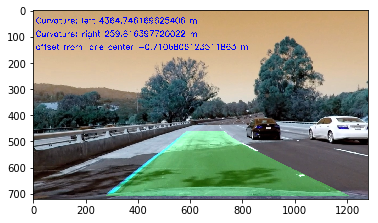

In [42]:
img=cv2.imread('test4.jpg')
print (check)
result=process(img)

plt.imshow(result)
plt.show()
check
plt.imsave('./test_images/final.png',cv2.cvtColor(result,cv2.COLOR_BGR2RGB))


In [48]:
offset

-0.71068061235118629

In [36]:
xx=np.array([  1.92390238e-01,  -7.71695704e+00,   3.09901786e+02])
yy=np.array([  1.92390238e-01,  -7.71695704e+00,   3.09901786e+02])

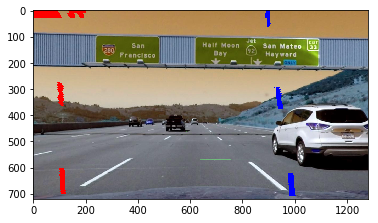

In [48]:
result=getlane(img,xx,yy)

plt.imshow(result)
plt.show()

In [70]:
ploty = np.linspace(0, out.shape[0]-1, num=out.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
out[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
out[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]
plt.imshow(out)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()


NameError: name 'out' is not defined

In [ ]:
warp_zero = np.zeros_like(out[:,:,0]).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#ploty = np.linspace(0, wraped.shape[0]-1, num=wraped.shape[0])
# Recast the x and y points into usable format for cv2.fillPoly()
#left_fit = np.polyfit(ploty, leftx, 2)
#left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#right_fit = np.polyfit(ploty, rightx, 2)
#right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
warp_zero = np.zeros_like(out).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
ploty = np.linspace(0, out.shape[0]-1, num=out.shape[0])
# Recast the x and y points into usable format for cv2.fillPoly()
#left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

In [ ]:
color_warp.shape

In [ ]:
plt.imshow(out,cmap='gray')
plt.show()

In [ ]:
plt.imshow(img)
plt.show()